In [1]:
from __future__ import absolute_import, division, print_function

import pathlib

from astropy.io import fits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import pickle

import time

from RHlib import calc_v_lc, calc_line_width, lc_find, calc_line_width, I_min_find

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Conv1D
import tensorflow.keras.backend as K
print(tf.__version__)


from scipy.io import readsav
from scipy import interpolate
from scipy.signal import correlate
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault) 

#TURBO CHARGE YOUR PYTHON
import multiprocessing
from joblib import Parallel, delayed


2.1.0


In [2]:
import matplotlib as m
fig_size = (8,6)
font = 'Helvetica'
params = {'backend': 'tkagg',
          'axes.labelsize': 9,
          'axes.titlesize': 9,
          'font.size': 8,
          'legend.fontsize': 9,
          'font.family': 'sans-serif',
          'font.sans-serif': font,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': True,
          'figure.figsize': fig_size,
          'figure.dpi': 80,
          'lines.linewidth': 1.0,
          'axes.linewidth':1.0,
          'image.interpolation'  : 'nearest',
          'xtick.major.size'     : 5,      # major tick size in points
          'xtick.minor.size'     : 3.5,      # minor tick size in points
          'xtick.major.width'    : 0.5,    # major tick width in points
          'xtick.minor.width'    : 0.3,    # minor tick width in points
          'axes.spines.top': False,
          'axes.spines.right':False,
          'xtick.top': False,
          'ytick.right': False,
          'axes.formatter.useoffset': False
}
m.rcParams.update(params)
m.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]

m.rcParams['mathtext.fontset'] = 'custom'
m.rcParams['mathtext.rm'] = font
m.rcParams['mathtext.it'] = font+':italic'
m.rcParams['mathtext.bf'] = font+':bold'
m.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [2]:
def build_conv_model1():
  #build the NN needed for the problem accomodating a single
  #convolutional layer and two densely connected hidden layer
  kSzConv1D = 5
  model = keras.Sequential([
    layers.Conv1D(30, (3,),
        activation='relu',strides=1,input_shape=[waveNumd,1]),
    layers.Conv1D(20, (3,),
        activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(15, (3,),
        activation='relu'),
    layers.Conv1D(15, (4,),
        activation='relu'),
    layers.MaxPooling1D(2),
    #layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(40,activation=tf.nn.relu),
    layers.Dense(40,activation=tf.nn.relu),  
    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    layers.Dense(waveNumd)])
  optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
          beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1,
  #                                          initial_accumulator_value=0.1, epsilon=1e-07)


  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model


def build_conv_model1():
  #build the NN needed for the problem accomodating a single
  #convolutional layer and two densely connected hidden layer
  kSzConv1D = 5
  model = keras.Sequential([
    layers.Conv1D(20, (3,),
        activation='relu',strides=1,input_shape=[waveNumd,1]),
    layers.Conv1D(15, (3,),
        activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(10, (3,),
        activation='relu'),
    layers.Conv1D(10, (4,),
        activation='relu'),
    layers.MaxPooling1D(2),
    #layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(20,activation=tf.nn.relu),
    layers.Dense(20,activation=tf.nn.relu),  
    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    layers.Dense(waveNumd)])
  optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
          beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1,
  #                                          initial_accumulator_value=0.1, epsilon=1e-07)


  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_conv_model():
    #build the NN needed for the problem accomodating a single
    #convolutional layer and two densely connected hidden layer
    kSzConv1D = 5
    y1 = layers.Input(shape=[waveNumd,1])
    y = layers.Conv1D(5, (3,), activation='relu')(y1)
    #y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(10, (3,), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)

    y = layers.Conv1D(15, (3,), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)
    #y = layers.Dense(20,activation='relu')(y)
    #y = layers.UpSampling1D()(y)
    y = layers.Conv1D(15,(3,), activation='relu')(y)
    #y = layers.Dropout(0.2)(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(10,(3,), activation='relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(5,(3,), activation='relu')(y)
    #layers.GlobalAveragePooling1D(),
    #y = layers.Flatten()(y)
    #y = layers.Dropout(0.5)(y)
    y = layers.Flatten()(y)
    y = layers.Dense(waveNumd,activation=tf.nn.relu)(y)
    y2 = layers.Add()([y,y1[:,:,0]])
    #y = layers.Dense(40,activation=tf.nn.relu)(y2)

    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    x = layers.Dense(waveNumd,activation='linear')(y2)
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model = keras.models.Model(inputs=y1, outputs=x)
    model.compile(loss=customLoss,
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])

    return model

def build_conv_model2():
    #build the NN needed for the problem accomodating a single
    #convolutional layer and two densely connected hidden layer
    kSzConv1D = 3
    waveNumd  = dl
    y1 = layers.Input(shape=[dl,1])
    y = layers.Conv1D(5, (kSzConv1D, ), activation='relu')(y1)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(10, (kSzConv1D, ), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(20, (kSzConv1D, ), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)
    #y = layers.Dense(dl,activation='relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(20, (kSzConv1D, ), activation='relu')(y)
    #y = layers.Dropout(0.2)(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(10, (kSzConv1D, ), activation='relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(5, (kSzConv1D, ), activation='relu')(y)
    #layers.GlobalAveragePooling1D(),
    #y = layers.Flatten()(y)
    #y = layers.Dropout(0.5)(y)
    y = layers.Flatten()(y)
    y = layers.Dense(waveNumd, activation=tf.nn.relu)(y)
    y2 = layers.Add()([y, y1[:,  :, 0]])
    y = layers.Dense(dl, activation=tf.nn.relu)(y2)

    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    
    x = layers.Dense(dl, activation='linear')(y2)
    optimizer = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=1.0, amsgrad=False)
    model = keras.models.Model(inputs=y1, outputs=x)
    model.compile(loss=customLoss, optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model


def build_dense_model():
    y1 = layers.Input(shape=[waveNumd,1])
    y = layers.Flatten()(y1)
    y = layers.Dense(128,activation='relu')(y)
    #y = layers.Dense(256,activation='relu')(y)
    y = layers.Dense(128,activation='relu')(y)
    #y = layers.Dropout(0.2)(y)
    y = layers.Dense(128,activation='relu')(y)
    y = layers.Dense(128,activation='relu')(y)
    y = layers.Dense(256,activation='relu')(y)
    #y = layers.Flatten()(y)
    y = layers.Dense(waveNumd)(y)
    y = layers.Add()([y,y1[:,:,0]])
    x = layers.Dense(waveNumd,activation='linear')(y)
    
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model = keras.models.Model(inputs=y1, outputs=x)
    model.compile(loss=customLoss,
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return model 

def load_spectral_profiles(directory,filename):
    hdul     = fits.open(directory+filename)
    spectrum = hdul[0].data
    return spectrum

def customLoss(yTrue,yPred):
    weights = K.constant(weights_8542_30p)
    return K.mean(K.square(yTrue-yPred)*weights)

def radial_dist(sizeX,sizeY):
    '''Prepare a flat array of the radial distance of the pixel
    from the optical center of the system -- used for removing 
    uncorrected blueshifts
    '''
    
    centerX = sizeX/2
    centerY = sizeY/2
    
    radialDistances = np.zeros((sizeX,sizeY))
    
    for ii in range(sizeX):
        for jj in range(sizeY):
            radialDistances[ii,jj] = (centerX-ii)**2 + (centerY-jj)**2
    
    radialDistances = np.reshape(radialDistances,(sizeX*sizeY))
    
    return radialDistances


def prepare_data(spectrum):
    shape = spectrum.shape
    spec = np.reshape(spectrum,(shape[0],shape[1]*shape[2]))
    spec = np.swapaxes(spec,0,1)
    return spec
    
def plot_spec_profile_comparison(wavescale,profile_FP1,profile_FP2,profile_inferred):
    plt.figure(dpi=250)
    plt.style.use('ggplot')
    plt.plot(wavescale,profile_FP1,'g.--',label='FP1')
    plt.plot(wavescale,profile_FP2,'b.--',label='FP2')
    plt.plot(wavescale,profile_inferred,'k.--',label = 'Inferred')
    plt.legend()
    plt.ylabel('Normalized Intensity')
    plt.xlabel('Wavelength, $\AA$')
    plt.show()
    
def Lorentzian(x0,x,gamma):
    x2  = (x0-x)*(x0-x)
    exp = gamma/(np.pi*(x2+gamma*gamma))
    return exp

def Gaussian(x,mu,sigma):
    
    return np.exp((-1)*(x-mu)*(x-mu)/(2*sigma*sigma))/np.sqrt(2*np.pi*sigma*sigma)
    
def produce_FP_transmission_peak(Type,dlambda,Dlambda,):
    
    return filterProfile

def convolve(signal,filterProfile):
    return np.convolve(signal,filterProfile)

def prepare_data(spectrum):
    shape = spectrum.shape
    spec = np.reshape(spectrum,(shape[0],shape[1]*shape[2]))
    spec = np.swapaxes(spec,0,1)
    return spec
    
def plot_spec_profile_comparison(wavescale,profile_FP1,profile_FP2,profile_inferred):
    plt.figure(dpi=250)
    plt.style.use('ggplot')
    plt.plot(wavescale,profile_FP1,'g.--',label='FP1')
    plt.plot(wavescale,profile_FP2,'b.--',label='FP2')
    plt.plot(wavescale,profile_inferred,'k.--',label = 'Inferred')
    plt.legend()
    plt.ylabel('Normalized Intensity')
    plt.xlabel('Wavelength, $\AA$')
    plt.show()
    
def Lorentzian(x0,x,gamma):
    x2  = (x0-x)*(x0-x)
    exp = gamma/(np.pi*(x2+gamma*gamma))
    return exp

def Gaussian(x,mu,sigma):
    return np.exp((-1)*(x-mu)*(x-mu)/(2*sigma*sigma))/np.sqrt(2*np.pi*sigma*sigma)
    
def produce_FP_transmission_peak(dlambda,lambda_0,Nlambda,FPnum,wavelength):
    wave_I = np.linspace((lambda_0-dlambda*Nlambda/2),(lambda_0+dlambda*Nlambda/2),num=Nlambda)
    ab = readsav('IBIS.FP1.FP2.profiles.6563.8542.sav')
    wave          = np.linspace(-24,24,num=48001)
    if wavelength == 6563:
        if FPnum == 1:
            t    = ab['ibis_fp1_profile_6563']
        if FPnum == 2:
            t    = ab['ibis_fp2_profile_6563'] 
    if wavelength == 8542:
        if FPnum == 1:
            t    = ab['ibis_fp1_profile_8542']
        if FPnum == 2:
            t    = ab['ibis_fp2_profile_8542']
    filterProfile = np.interp(wave_I,wave,t)
    return filterProfile

def convolve(signal,filterProfile):
    return np.convolve(signal,filterProfile)

In [12]:
print(waveNumd)
model = build_conv_model2()
model.summary()

30
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 28, 5)        20          input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_6 (MaxPooling1D)  (None, 14, 5)        0           conv1d_12[0][0]                  
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 12, 10)       160         max_pooling1d_6[0][0]            
_________________________________________________________________________________________

In [3]:
sizeX = 968
sizeY = 968


cutoutY = 100

waveCut0 = 30
waveCut1 = 60
waveNumd = waveCut1-waveCut0
dl = waveNumd

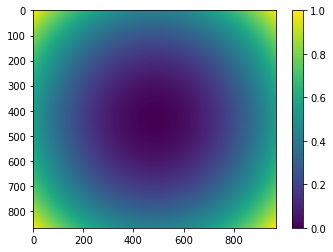

S
Shape of 2Fp spectrum is 89 868 968


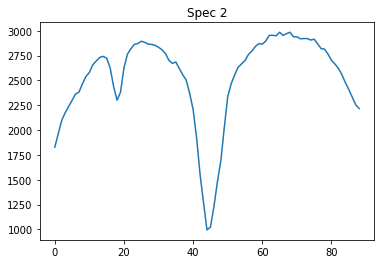

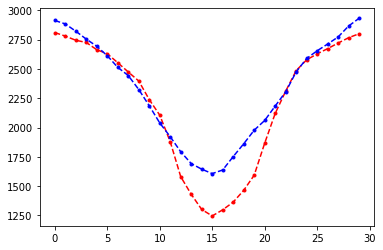

(840224, 30)
Average continuum in training set is 2858.403809
Average continuum in truth set is 2715.388916


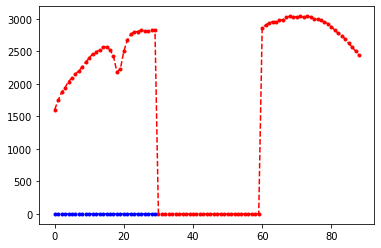

2FP set dimensions are: 840224, 1, 30
2FP set dimensions are:840224,30


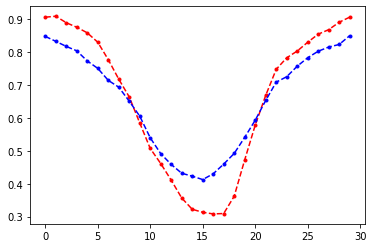

In [4]:
indices = radial_dist(sizeX-cutoutY,sizeY)

indices = indices / max(indices.flatten())
        
im1 = plt.imshow(np.reshape(indices,(sizeX-cutoutY,sizeY)))
plt.colorbar(im1)
plt.show() 

spec1 = (load_spectral_profiles('','even_ca_1fp.fits'))[:,cutoutY:,]
print('S')
waveNum  = (spec1.shape)[0]
spec1 = np.reshape(spec1,(waveNum,(sizeX-cutoutY)*sizeY))
spec1 = np.swapaxes(spec1,0,1)

spec2 = (load_spectral_profiles('','even_ca_2fp.fits'))[:,cutoutY:,:]
print('Shape of 2Fp spectrum is %d %d %d'%spec2.shape)
plt.plot(spec2[:,20,20])
plt.title('Spec 2')
plt.show()
spec2 = np.reshape(spec2,(waveNum,(sizeX-cutoutY)*sizeY))
spec2 = np.swapaxes(spec2,0,1)
train_set1 = spec1[:,waveCut0:waveCut1]
truth_set1 = spec2[:,waveCut0:waveCut1]
plt.plot(truth_set1[200000,:],'r.--')
plt.plot(train_set1[200000,:],'b.--')
plt.show()

print(train_set1.shape)
cont_train = np.mean((train_set1[:,3]+train_set1[:,-3]))/2
cont_truth = np.mean((truth_set1[:,3]+truth_set1[:,-3]))/2
print('Average continuum in training set is %f'%cont_train)
print('Average continuum in truth set is %f'%cont_truth)


# for ii in range(train_set1.shape[0]):
#     cont_12     =  (train_set1[ii,2]+train_set1[ii,-2])
#     if np.isnan(cont_12) == True:
#         print(np.isnan(cont_12))
#     #print(cont_12)
#     train_set1[ii,:] = train_set1[ii,:] / cont_12
# 
# for ii in range(truth_set1.shape[0]):
#     cont_12     =  (truth_set1[ii,2]+truth_set1[ii,-2])
#     if np.isnan(cont_12) == True:
#                 print(np.isnan(cont_12))
#     truth_set1[ii,:] = truth_set1[ii,:] / cont_12


for ii in range(train_set1.shape[0]):
    train_set1[ii, :] = train_set1[ii, :] / (1.2*cont_train)
    truth_set1[ii, :] = truth_set1[ii, :] / (1.2*cont_truth)
   
plt.plot(spec2[200000,:],'r.--')
plt.plot(train_set1[200000,:],'b.--')
plt.show()


train_set = np.zeros(((sizeX - cutoutY) * sizeY, 1, (waveNumd)))
truth_set = np.zeros(((sizeX - cutoutY) * sizeY, (waveNumd)))
print('2FP set dimensions are: %d, %d, %d'%train_set.shape)
train_set[:,0,0:(waveNumd)] = train_set1
#train_set[:,0,(waveNumd)]   = indices
truth_set        = truth_set1

train_set = (np.swapaxes(train_set, 1, 2))
print('2FP set dimensions are:%d,%d'%truth_set.shape)
#truth_set = (np.swapaxes(truth_set,0,1))
#print(truth_set.shape)


plt.plot(truth_set[20000, :], 'r.--')
plt.plot(train_set[20000, :], 'b.--')
plt.show()

In [15]:
EPOCHS = 100
skipP = 2
startP = 2 
endP   = -2
#print(train_set)

optimizer = 'Adam'
#optimizer = 'SGD'

if optimizer == 'Adam':
    model.optimizer = tf.keras.optimizers.Adam(lr=0.2, beta_1=.9,
              beta_2=0.999, epsilon=1e-8, decay=1.0, amsgrad=False)

if optimizer == 'SGD': 
    model.optimizer = tf.keras.optimizers.SGD(lr=1e-7, nesterov=True)
    
##print(train_set.shape)
##im2 = np.reshape(train_set,(868,968,waveNumd))
##plt.imshow(im2[200:,:,19])
##plt.show()
##print(truth_set.shape)
##im2 = np.reshape(truth_set,(868,968,waveNumd))
##plt.imshow(im2[200:,:,19])
##plt.show()
history = model.fit((train_set)[startP:endP:skipP,:,:], truth_set[startP:endP:skipP,:],
                    epochs=EPOCHS,validation_split=0.15 , verbose=1)

Train on 357093 samples, validate on 63017 samples
Epoch 1/100
357093/357093 [==============================] - 64s 178us/sample - loss: 0.0016 - mean_absolute_error: 0.0443 - mean_squared_error: 0.0034 - val_loss: 0.0016 - val_mean_absolute_error: 0.0450 - val_mean_squared_error: 0.0035
Epoch 2/100
357093/357093 [==============================] - 62s 175us/sample - loss: 0.0015 - mean_absolute_error: 0.0435 - mean_squared_error: 0.0033 - val_loss: 0.0016 - val_mean_absolute_error: 0.0443 - val_mean_squared_error: 0.0034
Epoch 3/100
357093/357093 [==============================] - 64s 179us/sample - loss: 0.0015 - mean_absolute_error: 0.0430 - mean_squared_error: 0.0032 - val_loss: 0.0016 - val_mean_absolute_error: 0.0439 - val_mean_squared_error: 0.0033
Epoch 4/100
357093/357093 [==============================] - 62s 172us/sample - loss: 0.0015 - mean_absolute_error: 0.0427 - mean_squared_error: 0.0032 - val_loss: 0.0016 - val_mean_absolute_error: 0.0436 - val_mean_squared_error: 0.00

357093/357093 [==============================] - 31s 87us/sample - loss: 0.0014 - mean_absolute_error: 0.0412 - mean_squared_error: 0.0030 - val_loss: 0.0015 - val_mean_absolute_error: 0.0422 - val_mean_squared_error: 0.0031
Epoch 70/100
357093/357093 [==============================] - 30s 84us/sample - loss: 0.0014 - mean_absolute_error: 0.0412 - mean_squared_error: 0.0030 - val_loss: 0.0015 - val_mean_absolute_error: 0.0421 - val_mean_squared_error: 0.0031
Epoch 71/100
357093/357093 [==============================] - 30s 84us/sample - loss: 0.0014 - mean_absolute_error: 0.0412 - mean_squared_error: 0.0030 - val_loss: 0.0015 - val_mean_absolute_error: 0.0421 - val_mean_squared_error: 0.0031
Epoch 72/100
357093/357093 [==============================] - 30s 83us/sample - loss: 0.0014 - mean_absolute_error: 0.0412 - mean_squared_error: 0.0030 - val_loss: 0.0015 - val_mean_absolute_error: 0.0421 - val_mean_squared_error: 0.0031
Epoch 73/100
357093/357093 [==============================] -

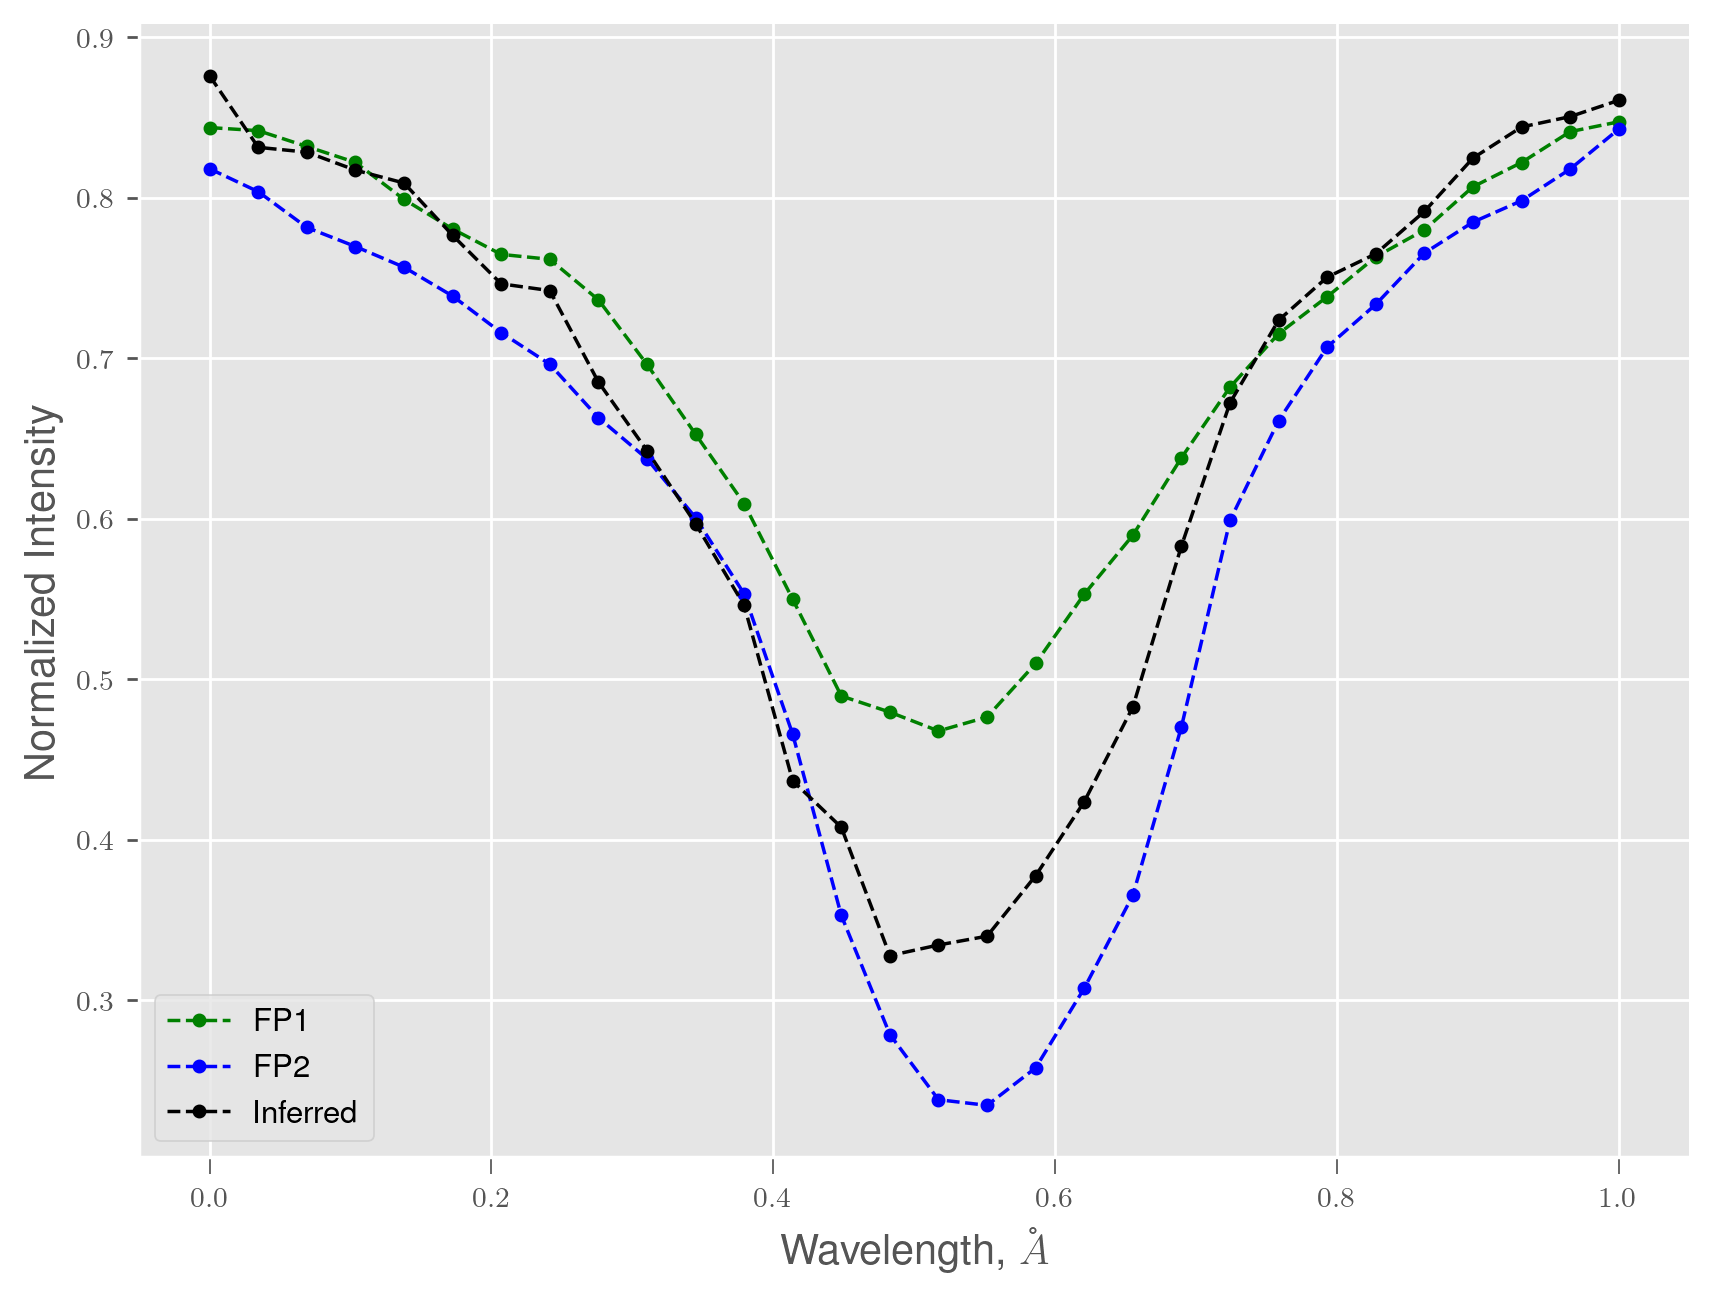

In [20]:
prevNum  = 5000
delta    = 2


#im       = model.predict(train_set[:,:,:])
#plt.figure(dpi=200)
#plt.imshow(np.reshape(train_set[:,30,0],(968,968)))
#plt.show()
#plt.figure(dpi=200)
#plt.imshow(np.reshape(im[:,30],(968,968)))
#plt.show()
#plt.figure(dpi=200)
#plt.imshow(np.reshape(truth_set[:,30],(968,968)))
#plt.show()

res = model.predict(train_set[prevNum:prevNum+delta,:,:])

wavescale = np.linspace(0,1,num=waveNumd)
plot_spec_profile_comparison(wavescale,train_set[prevNum,:,0],truth_set[prevNum,:],res[0,:])

###### train_set[:,0,50]   = indices
truth_set        = truth_set1

train_set = (np.swapaxes(train_set,1,2))
print(train_set.shape)
#truth_set = (np.swapaxes(truth_set,1,2))
print(truth_set.shape)

In [ ]:
im1 = np.reshape(train_set[:,0,0],(968,968))
im = plt.imshow(im1)
plt.colorbar(im)
plt.show()

The elapsed time for 1M Pixel inversion is:   0.00 seconds


NameError: name 'im' is not defined

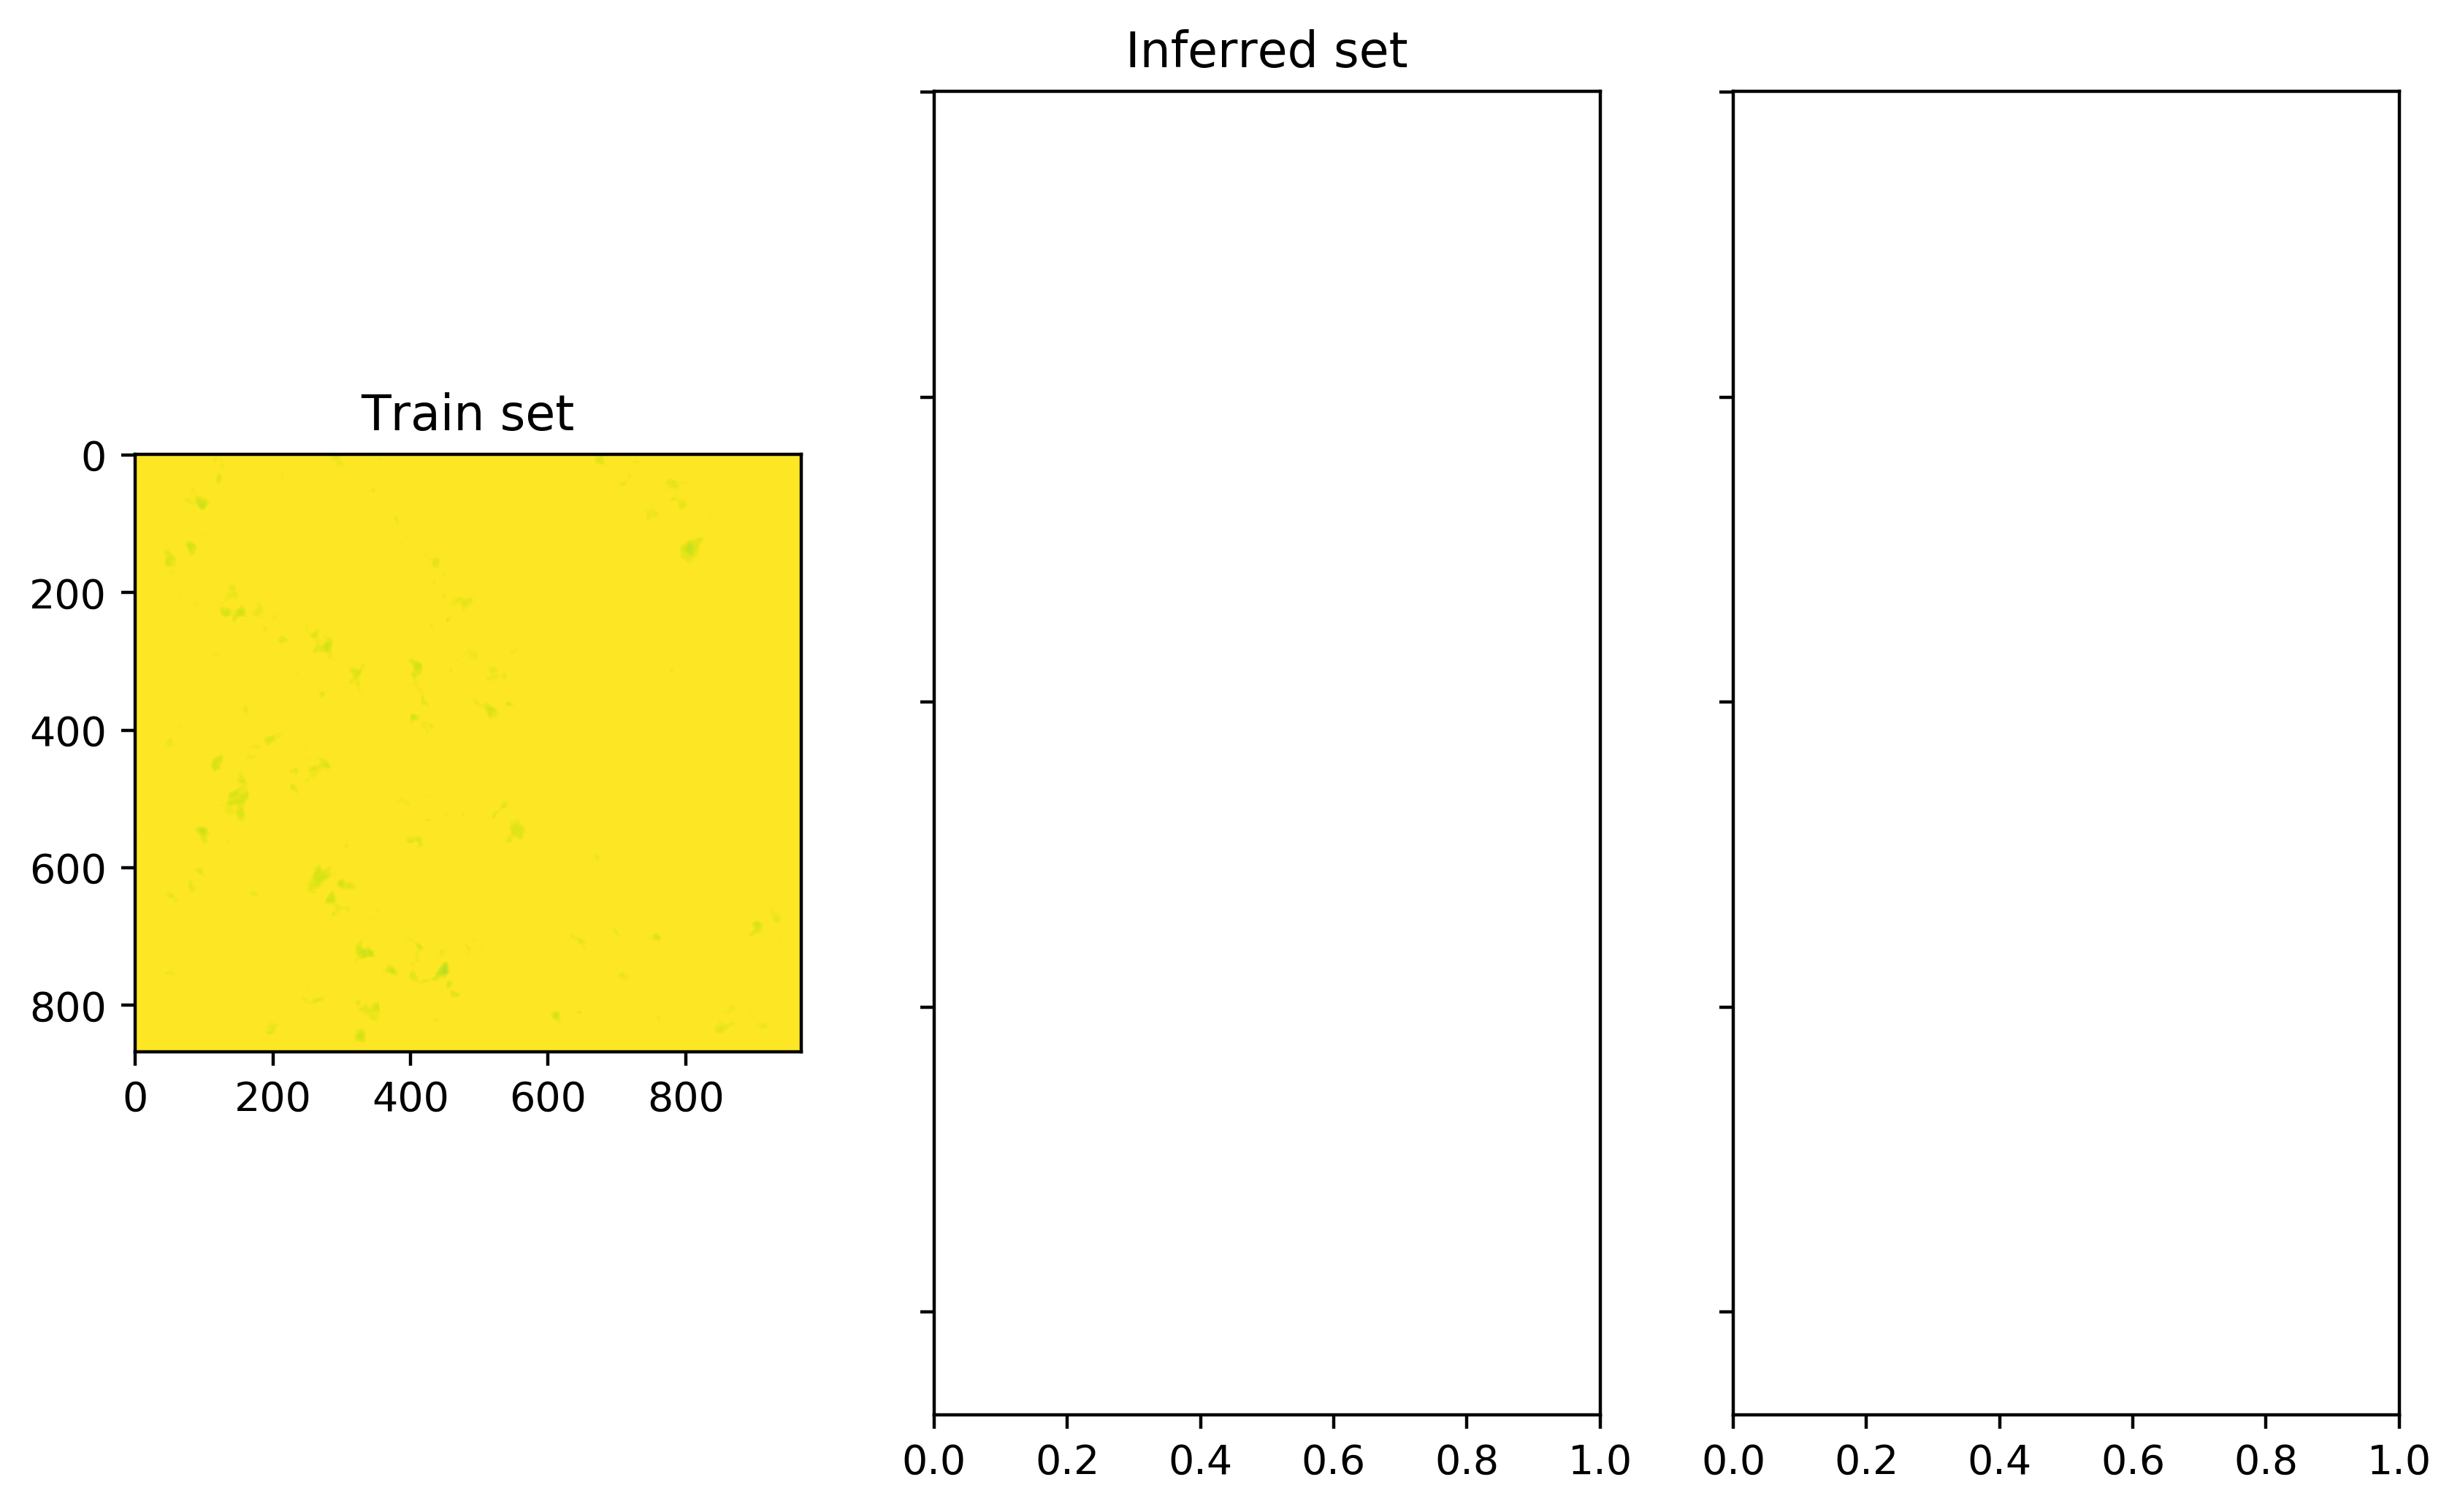

In [8]:
start = time.process_time()
#im = model.predict(train_set[:,:,:])
print("The elapsed time for 1M Pixel inversion is: %6.2f seconds"%(time.process_time() - start))

dim1 = 15
dim2 = 17

vmin_a = 0.01
vmax_a = 0.4


figure, ax = plt.subplots(1,3,sharey=True)
figure.set_dpi(400)
figure.set_size_inches(10,6)
ax[0].set_title('Train set')
im0 = ax[0].imshow(np.reshape(np.mean(train_set[:,dim1:dim2,0],axis=1),(sizeX-cutoutY,sizeY)),vmin=vmin_a,vmax=vmax_a)
#divider = make_axes_locatable(ax[0])
#cax0 = divider.append_axes("right", size="5%", pad=0.05)
#figure.colorbar(im0, cax=cax0)
                   
ax[1].set_title('Inferred set')
im1 = ax[1].imshow(np.reshape((np.mean(im[:,dim1:dim2],axis=1)),(sizeX-cutoutY,sizeY)),vmin=vmin_a,vmax=vmax_a)
#divider = make_axes_locatable(ax[1])
#cax1 = divider.append_axes("right", size="5%", pad=0.05)
#figure.colorbar(im1, cax=cax1)

ax[2].set_title('Truth set')
im2 = ax[2].imshow(np.reshape(np.mean(truth_set[:,dim1:dim2],axis=1),(sizeX-cutoutY,sizeY)),vmin=vmin_a,vmax=vmax_a)
#divider = make_axes_locatable(ax[2])
#cax2 = divider.append_axes("right", size="5%", pad=0.05)
#figure.colorbar(im2, cax=cax2)
plt.show() 

[[0.25357324 0.2559563  0.2550916  ... 0.25338072 0.2599587  0.28296918]
 [0.25151667 0.2561781  0.25301394 ... 0.25278828 0.25898367 0.28204447]
 [0.2505338  0.25588325 0.251787   ... 0.2535449  0.25953498 0.2801066 ]
 ...
 [0.26849306 0.26969892 0.2652846  ... 0.2672784  0.27291656 0.28172302]
 [0.29536462 0.30088642 0.27703372 ... 0.2846953  0.29035878 0.27919888]
 [0.29906228 0.30650473 0.27770975 ... 0.28584844 0.29399756 0.27919957]]


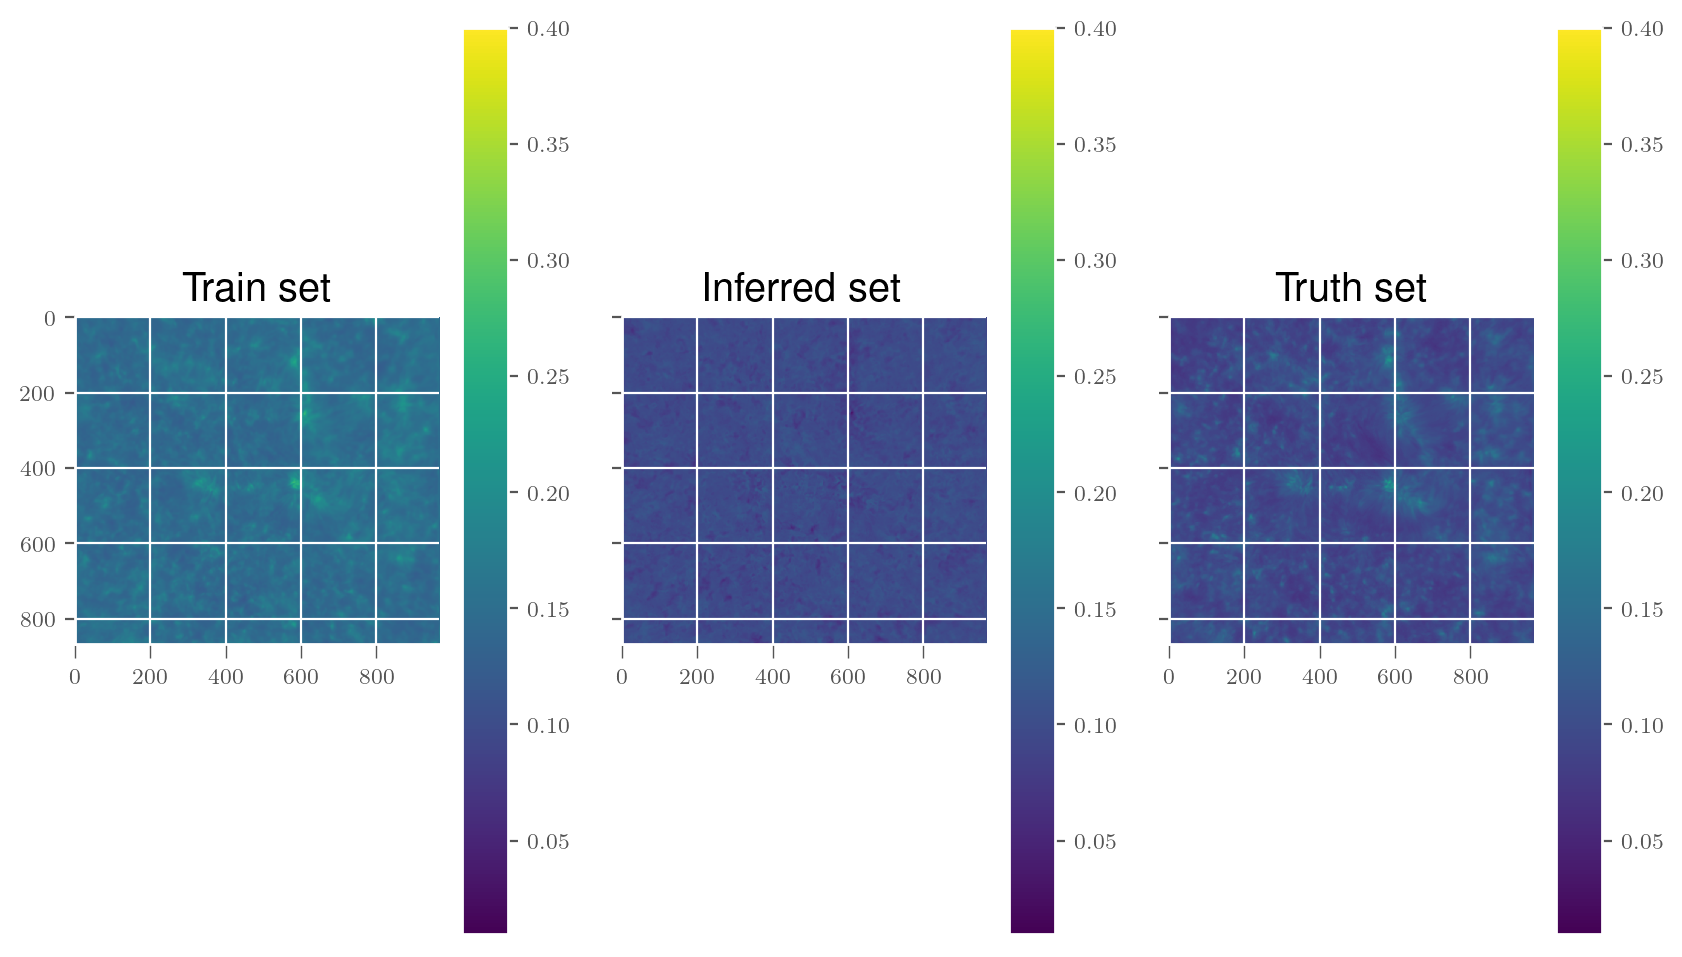

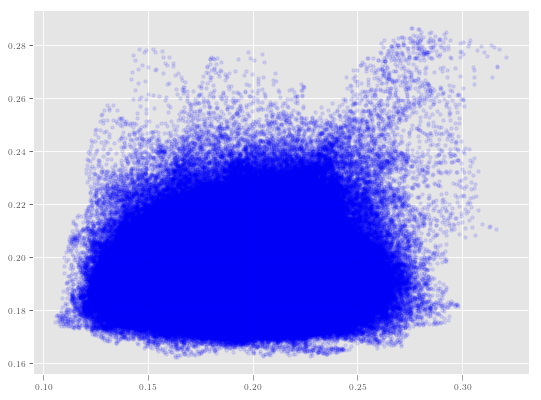

In [363]:
#im = model.predict(train_set[:,:,:])
print(im)

figure, ax = plt.subplots(1,3,sharey=True)
figure.set_dpi(200)
figure.set_size_inches(10,6)
ax[0].set_title('Trai set')
im0 = ax[0].imshow(np.reshape(np.amin(train_set[:,5:-5,0],axis=1),(sizeX-cutoutY,sizeY)),vmin=vmin_a,vmax=vmax_a)
figure.colorbar(im0, ax=ax[0])
                   
ax[1].set_title('Inferred set')
im1 = ax[1].imshow(np.reshape((np.amin(im,axis=1)),(sizeX-cutoutY,sizeY)),vmin=vmin_a,vmax=vmax_a)
figure.colorbar(im1, ax=ax[1])

ax[2].set_title('Truth set')
im2 = ax[2].imshow(np.reshape(np.amin(truth_set,axis=1),(sizeX-cutoutY,sizeY)),vmin=vmin_a,vmax=vmax_a)
figure.colorbar(im2, ax=ax[2])
plt.show() 

plt.plot(truth_set[:,10],im[:,10],'b.',alpha=0.1)
plt.show()

(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([0.06534635, 0.06552591, 0.06570547, ..., 0.24454713, 0.24472669,
       0.24490625]), array([0.02697845, 0.02709664, 0.02721483, ..., 0.14493271, 0.1450509 ,
       0.14516909]))


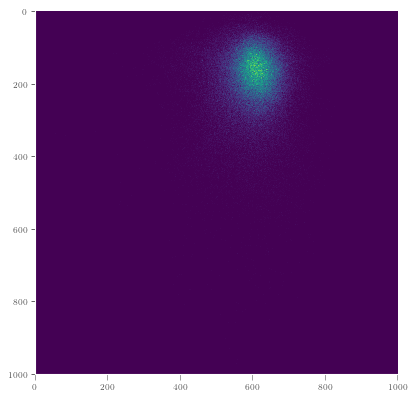

In [365]:
xmin = np.amin(truth_set[:,15])
xmax = np.amax(truth_set[:,15])
ymin = np.amin(im[:,15])
ymax = np.amax(im[:,15])


ab=np.histogram2d(np.amin(truth_set,axis=1),np.amin(im,axis=1),bins=(1000,1000),range=[[xmin,xmax],[ymin,ymax]])



print(ab)
plt.imshow(ab[0])
#plt.imshow(ab[0][0:400,0:400])
plt.grid(b=False)
plt.show()

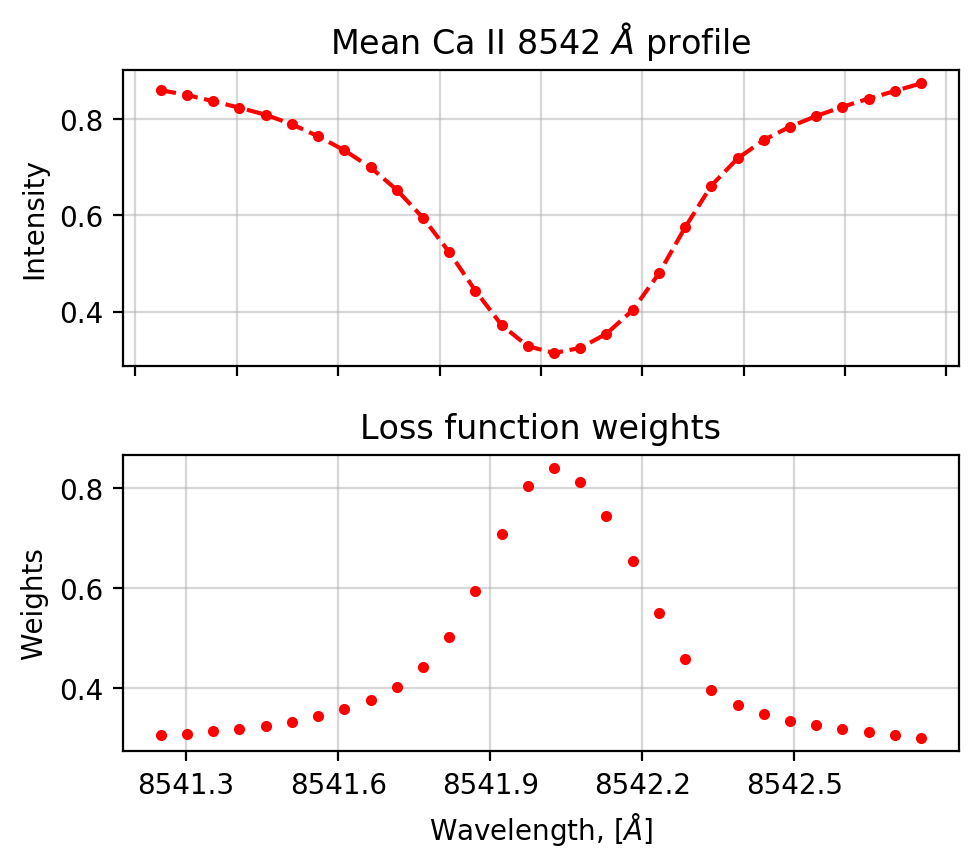

In [12]:
mean_profile_8542 = np.reshape(np.mean(truth_set,axis=0),30)
weights_8542_30p = 1/(3.8*mean_profile_8542[:])
caSpectralRes = 0.05
dll = mean_profile_8542.shape[0]
wave = np.linspace(caSpectralRes*dll/(-2),.5*caSpectralRes*dll,num=dll)+8542.0

fig, ax = plt.subplots(2,1)
fig.set_dpi(200)
fig.set_size_inches(5,4)
fig.tight_layout()
for element in ax: 
    element.grid(alpha=0.5)
ax[0].plot(wave,mean_profile_8542,'r.--')
#ax[0].set_ylim(0.08,0.3)
ax[0].set_ylabel('Intensity')
ax[0].set_title('Mean Ca II 8542 $\\AA$ profile')
ax[0].set_xticklabels([])

ax[1].plot(wave,weights_8542_30p,'r.')
#ax[1].set_ylim(0.5,3)
ax[1].xaxis.set_ticks(np.arange(8541.3,8542.8,0.3))
ax[1].set_ylabel('Weights')
ax[1].set_xlabel('Wavelength, [$\\AA$]')
ax[1].set_title('Loss function weights')

plt.savefig('Figures/Loss_function.png',transparent=True,bbox_inches = "tight")

plt.show()

NameError: name 'dim1' is not defined

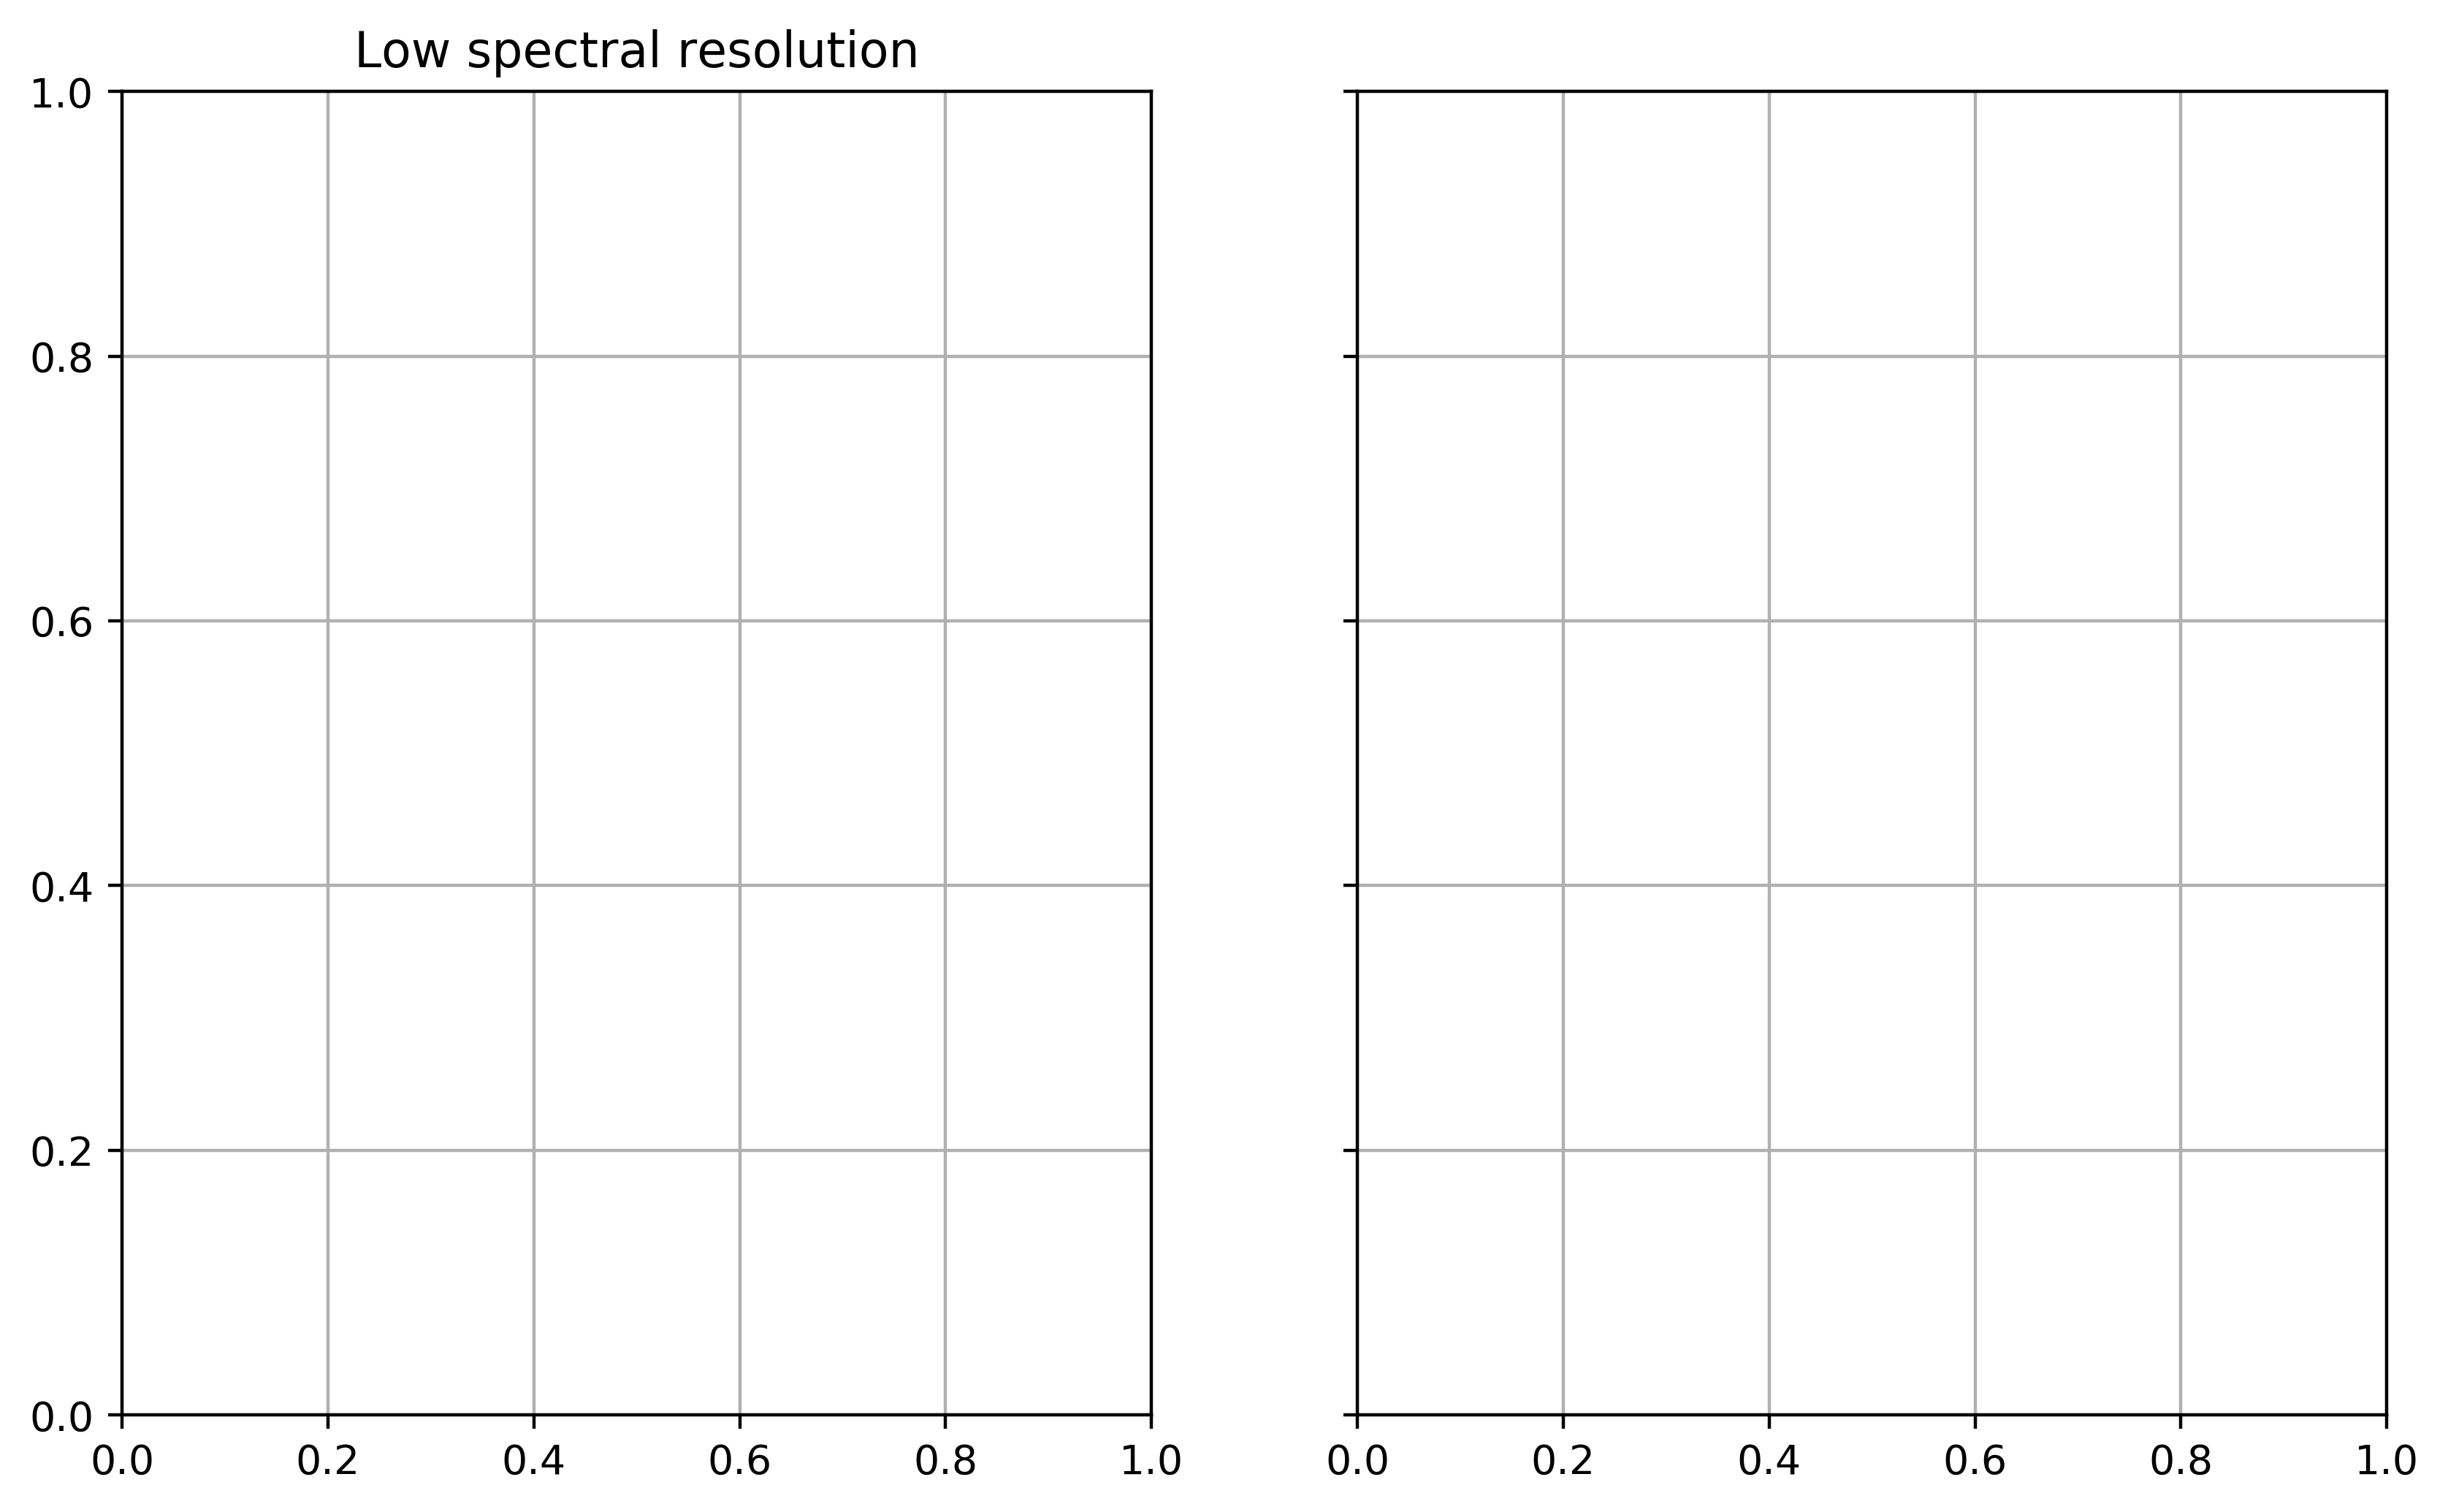

In [7]:
figure, ax = plt.subplots(1,2,sharey=True)
figure.set_dpi(400)
figure.set_size_inches(10,6)

csfont = {'fontname':'Helvetica'}
ax[0].set_title('Low spectral resolution')
for element in ax:
    element.grid(b='false')
im0 = ax[0].imshow(np.reshape(np.mean(train_set[:,dim1:dim2,0],axis=1),(sizeX-cutoutY,sizeY)),cmap='gray')
ax[0].set_ylabel('Solar Y, pixels',**csfont)
ax[0].set_xlabel('Solar X, pixels',**csfont)
#divider = make_axes_locatable(ax[0])
#cax0 = divider.append_axes("right", size="1%", pad=0.05)
#figure.colorbar(im0, cax=cax0)
                   

ax[1].set_title('High spectral resolution')
im2 = ax[1].imshow(np.reshape(np.mean(truth_set[:,dim1:dim2],axis=1),(sizeX-cutoutY,sizeY)),cmap='gray')
#divider = make_axes_locatable(ax[1])
#cax2 = divider.append_axes("right", size="5%", pad=0.05)
#figure.colorbar(im2, cax=cax2)

#ax[1].set_ylabel('Solar Y, pixels',**csfont)
ax[1].set_xlabel('Solar X, pixels',**csfont)
plt.savefig('Figures/IBIS_demo_FP1_inout.png',transparent = True)
plt.show()

## Convolve an IBIS sharp image and then train the network on that and then invert the unsharp image

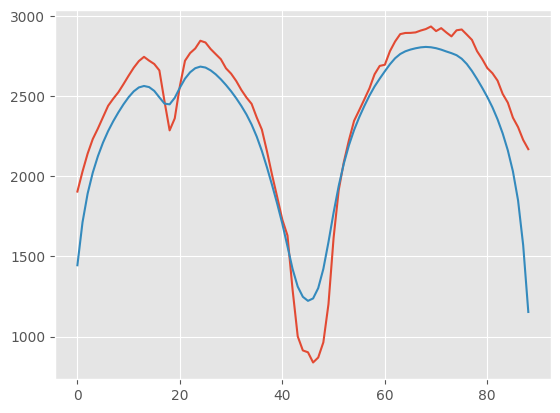

In [115]:
specData = (load_spectral_profiles('','even_ca_2fp.fits'))

specDataNx = specData.shape[1]
specDataNy = specData.shape[2]
specDataNz = specData.shape[0]

specData = np.reshape(specData,(specDataNz,specDataNx*specDataNy))
specData = np.swapaxes(specData,0,1)

TProfile = produce_FP_transmission_peak(0.05,0,specDataNz,2,8542)
TProfile_total = np.sum(TProfile)
TProfile       = TProfile/TProfile_total

specDataConv = np.zeros((specDataNx*specDataNy,specDataNz,1))

for ii in range(specDataNx*specDataNy):
    specDataConv[ii,:,0] = np.convolve(specData[ii,:],TProfile,mode='same')
    
plt.plot(specData[2030,:])
plt.plot(specDataConv[2030,:])
plt.show()

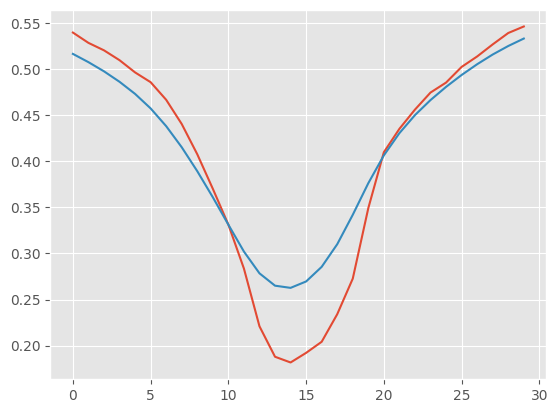

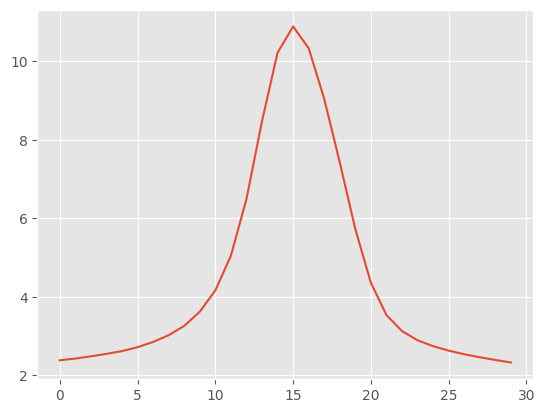

In [158]:
lStart = 30
lEnd   = 60
dl     = lEnd - lStart

specDataM     = specData[:,lStart:lEnd]/5000
specDataMConv = specDataConv[:,lStart:lEnd]/5000

plt.plot(specDataM[2000,:])
plt.plot(specDataMConv[2000,:])
plt.show()

weights = 1/(np.mean(specDataM,axis=0)**1.5)
def customLoss(yTrue,yPred):
    weights1 = K.constant(weights)
    return K.mean(K.square(yTrue-yPred)*weights1)


plt.plot(weights)

## Define a CNN for the IBIS model

In [79]:
model1 = build_conv_model()
model1.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_60 (Conv1D)              (None, 28, 5)        20          input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_61 (Conv1D)              (None, 26, 10)       160         conv1d_60[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_25 (MaxPooling1D) (None, 13, 10)       0           conv1d_61[0][0]                  
___________________________________________________________________________________________

In [80]:
EPOCHS = 1000
skipP = 2
startP = 2
endP   = -2
#print(train_set)

optimizer = 'Adam'
#optimizer = 'SGD'

if optimizer == 'Adam':
    model1.optimizer = tf.keras.optimizers.Adam(lr=1e-3, beta_1=.9,
              beta_2=0.999, epsilon=1e-8, decay=1.0, amsgrad=False)

if optimizer == 'SGD': 
    model1.optimizer = tf.keras.optimizers.SGD(lr=1e-7, nesterov=True)
    
##print(train_set.shape)
##im2 = np.reshape(train_set,(868,968,waveNumd))
##plt.imshow(im2[200:,:,19])
##plt.show()
##print(truth_set.shape)
##im2 = np.reshape(truth_set,(868,968,waveNumd))
##plt.imshow(im2[200:,:,19])
##plt.show()
history = model1.fit(specDataMConv[startP:endP:skipP,:], specDataM[startP:endP:skipP,:],
                    epochs=EPOCHS,validation_split=0.15 , verbose=1)

Train on 398233 samples, validate on 70277 samples
Epoch 1/1000
 79392/398233 [====>.........................] - ETA: 1:38 - loss: 0.4747 - mean_absolute_error: 0.3340 - mean_squared_error: 0.1931

KeyboardInterrupt: 

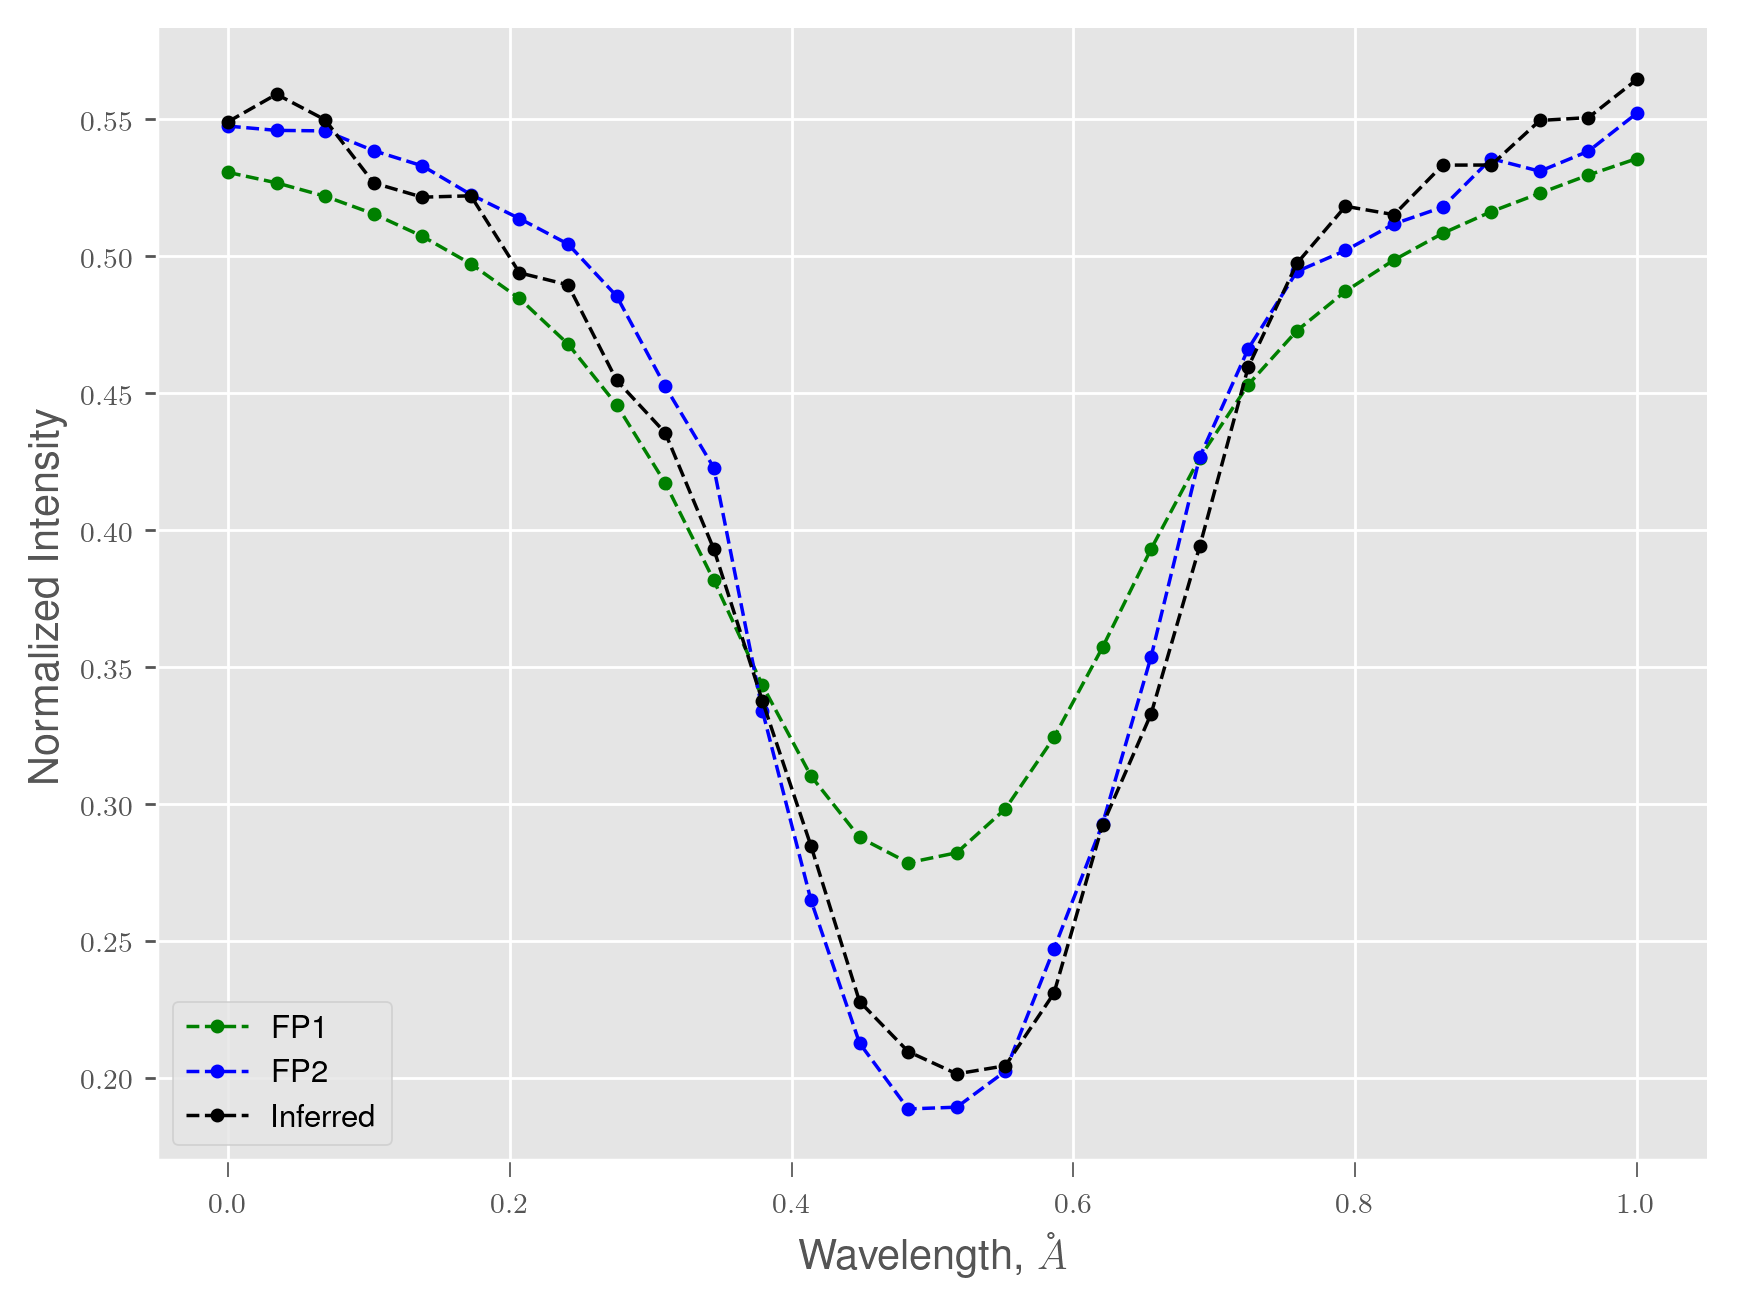

In [522]:
prevNum  = 31750
delta    = 1

res = model1.predict(specDataMConv[prevNum:(prevNum+delta),:,:])

wavescale = np.linspace(0,1,num=dl)
plot_spec_profile_comparison(wavescale,specDataMConv[prevNum,:,0],specDataM[prevNum,:],res[0,:])

### Choose only not-changing spectral profiles from the IBIS dataset

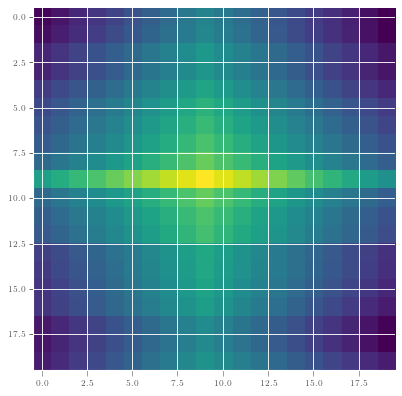

2.0021875287008775


In [34]:
x_size = 968
y_size = 868
dd     = 10

cor_matrix = correlate(np.reshape(truth_set1[:, 14], (x_size, y_size)),
                       np.reshape(train_set1[:, 14], (x_size, y_size)))
plt.imshow(np.log(cor_matrix[(x_size-dd):(x_size+dd), (y_size-dd):(y_size+dd)]))
plt.show()
print(np.argmax(cor_matrix, axis=None)/(x_size-1)/(y_size-1))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


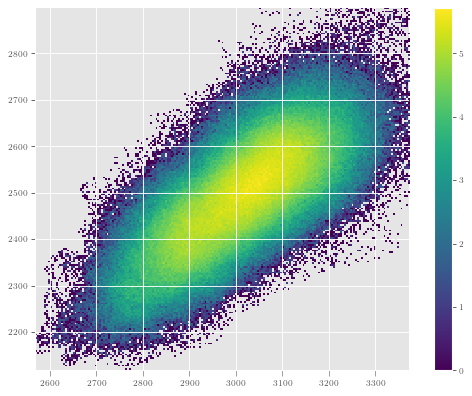

In [102]:
res   = 200
index = -2
xedges = np.linspace(np.amin(spec1[:, index])*1, 
                     np.amax(spec1[:, index])*.9, num = res)
yedges = np.linspace(np.amin(spec2[:, index])*1, 
                     np.amax(spec2[:, index])*.9, num = res)
H, xedges, yedges = np.histogram2d(spec1[:, index], spec2[:, index],
                                   bins=(xedges, yedges))
H = H.T
im1 = plt.imshow(np.log(H), extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           interpolation='nearest', origin='low')
plt.colorbar(im1)
plt.show()

In [89]:
# Calculate percentiles 

data_subset = 1
percentiles_x = np.linspace(0, 100, num=1000)

min_I_train = np.zeros(train_set1[:, 0].size)
min_I_truth = np.zeros(train_set1[:, 0].size)

width_train = np.zeros(train_set1[:, 0].size)
width_truth = np.zeros(train_set1[:, 0].size)

vmin_I_train = np.zeros(train_set1[:, 0].size)
vmin_I_truth = np.zeros(train_set1[:, 0].size)

waves = np.linspace(0, 29, num=30)

print("Calculate train set velocities")
vmin_I_train = Parallel(n_jobs=4)(delayed(calc_v_lc)(waves, i, 2, -2, 7) for i in train_set1)
print("Calculate truth set velocities")
vmin_I_truth = Parallel(n_jobs=4)(delayed(calc_v_lc)(waves, i, 2, -2, 7) for i in truth_set1)
print("Calculate widths")
# widths_train = Parallel(n_jobs=4)(delayed(calc_line_widths)(waves, i, 6, .5) for i in train_set1)
# widths_truth = Parallel(n_jobs=4)(delayed(calc_line_widths)(waves, i, 6, .5) for i in truth_set1)

print("Calculate I_min for train set")
min_I_train = Parallel(n_jobs=4)(delayed(I_min_find)(waves, i, 2, -2, 7) for i in train_set1)

print("Calculate I_min for truth set")
min_I_truth = Parallel(n_jobs=4)(delayed(I_min_find)(waves, i, 2, -2, 7) for i in truth_set1)

# width_train = Parallel(n_jobs=4)(delayed(calc_line_width)(waves, i, 6, .5) for i in train_set1)
# for i in range(int(train_set1[:, 0].size/data_subset)):
#     if i%(20000) == 0: 
#         print(str(int(i/833000*100*data_subset)) + ' %')
#     vmin_I_train[i] = calc_v_lc(np.linspace(1, 30, num=30), train_set1[i], 2, -2, 7)[0]
#     vmin_I_truth[i] = calc_v_lc(np.linspace(1, 30, num=30), truth_set1[i], 2, -2, 7)[0]
# print('Done with velocities calculation.')

vpercentiles_y_train = np.percentile(vmin_I_train, percentiles_x)
vpercentiles_y_truth = np.percentile(vmin_I_truth, percentiles_x)

f_vp_train = interpolate.interp1d(vpercentiles_y_train, percentiles_x, kind='slinear')
f_vp_truth = interpolate.interp1d(vpercentiles_y_truth, percentiles_x, kind='slinear')



print('Calculated min intensities successfully')

percentiles_y_train = np.percentile(min_I_train, percentiles_x)
percentiles_y_truth = np.percentile(min_I_truth, percentiles_x)

f_p_train = interpolate.interp1d(percentiles_y_train, percentiles_x, kind='slinear')
f_p_truth = interpolate.interp1d(percentiles_y_truth, percentiles_x, kind='slinear')

Calculate train set velocities
Calculate truth set velocities
Calculate widths
Calculate I_min for train set
Calculate I_min for truth set


KeyboardInterrupt: 

In [102]:
percentiles_y_train = np.percentile(min_I_train, percentiles_x)
percentiles_y_truth = np.percentile(min_I_truth, percentiles_x)

f_p_train = interpolate.interp1d(percentiles_y_train, percentiles_x, kind='slinear')
f_p_truth = interpolate.interp1d(percentiles_y_truth, percentiles_x, kind='slinear')

truth_set_modified = []
train_set_modified = []

dpercentile = 4

range_counter = int(train_set1[:, 0].size)

for ii in range(int(range_counter/data_subset)):
    if ii%(40000) == 0: 
        print(str(int(ii/range_counter*100*data_subset))+' %')

    if np.abs(f_p_train(min_I_train[ii]) 
              - f_p_truth(min_I_truth[ii])) <= dpercentile:
        if np.abs(vmin_I_train[ii] 
                  - vmin_I_truth[ii]) < .45:
            train_set_modified.append(train_set[ii, :, :])
            truth_set_modified.append(truth_set1[ii, :])

range_i = len(truth_set_modified)
print(f"The number of classified profiles is:{range_i}")
truth_set_modified
truth_set_modified_ML = np.zeros((range_i, 30))
train_set_modified_ML = np.zeros((range_i, 30, 1))

for ii in range(range_i): 
    truth_set_modified_ML[ii, :] = truth_set_modified[ii]
    train_set_modified_ML[ii, :, :] = train_set_modified[ii] 

0 %
4 %
9 %
14 %
19 %
23 %
28 %
33 %
38 %
42 %
47 %
52 %
57 %
61 %
66 %
71 %
76 %
80 %
85 %
90 %
95 %
99 %
The number of classified profiles is:38755


In [ ]:
i = 40
print(calc_v_lc(np.linspace(0, 29, num=30), train_set1[i], 2, -2, 7))
plt.plot(train_set1[i])

35621
[0.41875005 0.41773373 0.41705018 ... 0.         0.         0.        ]


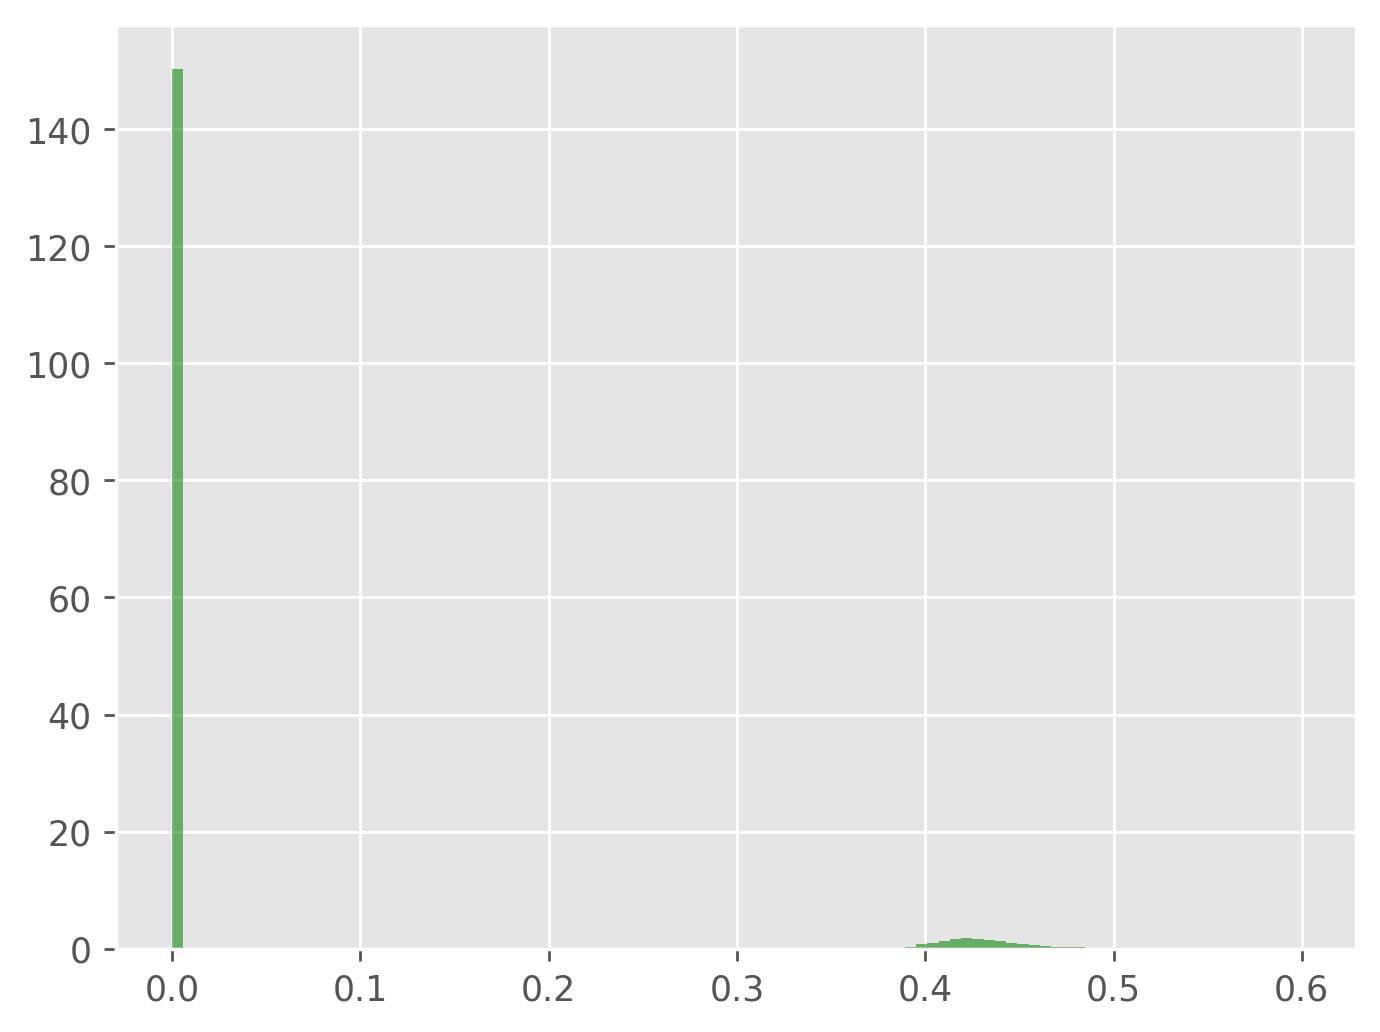

In [340]:
print(len(train_set_modified))

plt.figure(dpi=250)
n, bins, patches = plt.hist(min_I_train, 100, density=True, facecolor='g', alpha=0.55)
#n1, bins1, patches1 = plt.hist(truth_set1[:, 0], 200, density=True, facecolor='b', alpha=0.55)
print(min_I_train)
plt.grid(True)
plt.show()

In [106]:
EPOCHS = 1000
skipP = 1
startP = 1 
endP   = -1
#print(train_set)

optimizer = 'Adam'
#optimizer = 'SGD'

if optimizer == 'Adam':
    model.optimizer = tf.keras.optimizers.Adam(lr=.3, beta_1=.9,
              beta_2=0.999, epsilon=1e-8, decay=1.0, amsgrad=False)

if optimizer == 'SGD': 
    model.optimizer = tf.keras.optimizers.SGD(lr=1e-1, nesterov=True)

history = model.fit(train_set_modified_ML[startP:endP:skipP,:,:], truth_set_modified_ML[startP:endP:skipP,:],
                    epochs=EPOCHS,validation_split=0.15 , verbose=1)

Train on 32940 samples, validate on 5813 samples
Epoch 1/1000
32940/32940 [==============================] - 4s 122us/sample - loss: 0.0451 - mean_absolute_error: 0.0827 - mean_squared_error: 0.0996 - val_loss: 0.0014 - val_mean_absolute_error: 0.0430 - val_mean_squared_error: 0.0030
Epoch 2/1000
32940/32940 [==============================] - 3s 91us/sample - loss: 0.0016 - mean_absolute_error: 0.0444 - mean_squared_error: 0.0033 - val_loss: 0.0014 - val_mean_absolute_error: 0.0424 - val_mean_squared_error: 0.0029
Epoch 3/1000
32940/32940 [==============================] - 3s 90us/sample - loss: 0.0016 - mean_absolute_error: 0.0440 - mean_squared_error: 0.0033 - val_loss: 0.0013 - val_mean_absolute_error: 0.0417 - val_mean_squared_error: 0.0029
Epoch 4/1000
32940/32940 [==============================] - 3s 92us/sample - loss: 0.0015 - mean_absolute_error: 0.0437 - mean_squared_error: 0.0032 - val_loss: 0.0013 - val_mean_absolute_error: 0.0413 - val_mean_squared_error: 0.0028
Epoch 5/10

Epoch 35/1000
32940/32940 [==============================] - 3s 90us/sample - loss: 9.3951e-04 - mean_absolute_error: 0.0354 - mean_squared_error: 0.0022 - val_loss: 8.2803e-04 - val_mean_absolute_error: 0.0334 - val_mean_squared_error: 0.0019
Epoch 36/1000
32940/32940 [==============================] - 3s 90us/sample - loss: 9.3600e-04 - mean_absolute_error: 0.0353 - mean_squared_error: 0.0021 - val_loss: 8.2387e-04 - val_mean_absolute_error: 0.0333 - val_mean_squared_error: 0.0019
Epoch 37/1000
32940/32940 [==============================] - 3s 92us/sample - loss: 9.3296e-04 - mean_absolute_error: 0.0353 - mean_squared_error: 0.0021 - val_loss: 8.1834e-04 - val_mean_absolute_error: 0.0331 - val_mean_squared_error: 0.0019
Epoch 38/1000
32940/32940 [==============================] - 3s 91us/sample - loss: 9.2992e-04 - mean_absolute_error: 0.0352 - mean_squared_error: 0.0021


KeyboardInterrupt: 

In [105]:
print(waveNumd)
model = build_conv_model2()
model.summary()

30
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 28, 5)        20          input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_15 (MaxPooling1D) (None, 14, 5)        0           conv1d_30[0][0]                  
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 12, 10)       160         max_pooling1d_15[0][0]           
_________________________________________________________________________________________

[0.         0.03448276 0.06896552 0.10344828 0.13793103 0.17241379
 0.20689655 0.24137931 0.27586207 0.31034483 0.34482759 0.37931034
 0.4137931  0.44827586 0.48275862 0.51724138 0.55172414 0.5862069
 0.62068966 0.65517241 0.68965517 0.72413793 0.75862069 0.79310345
 0.82758621 0.86206897 0.89655172 0.93103448 0.96551724 1.        ]


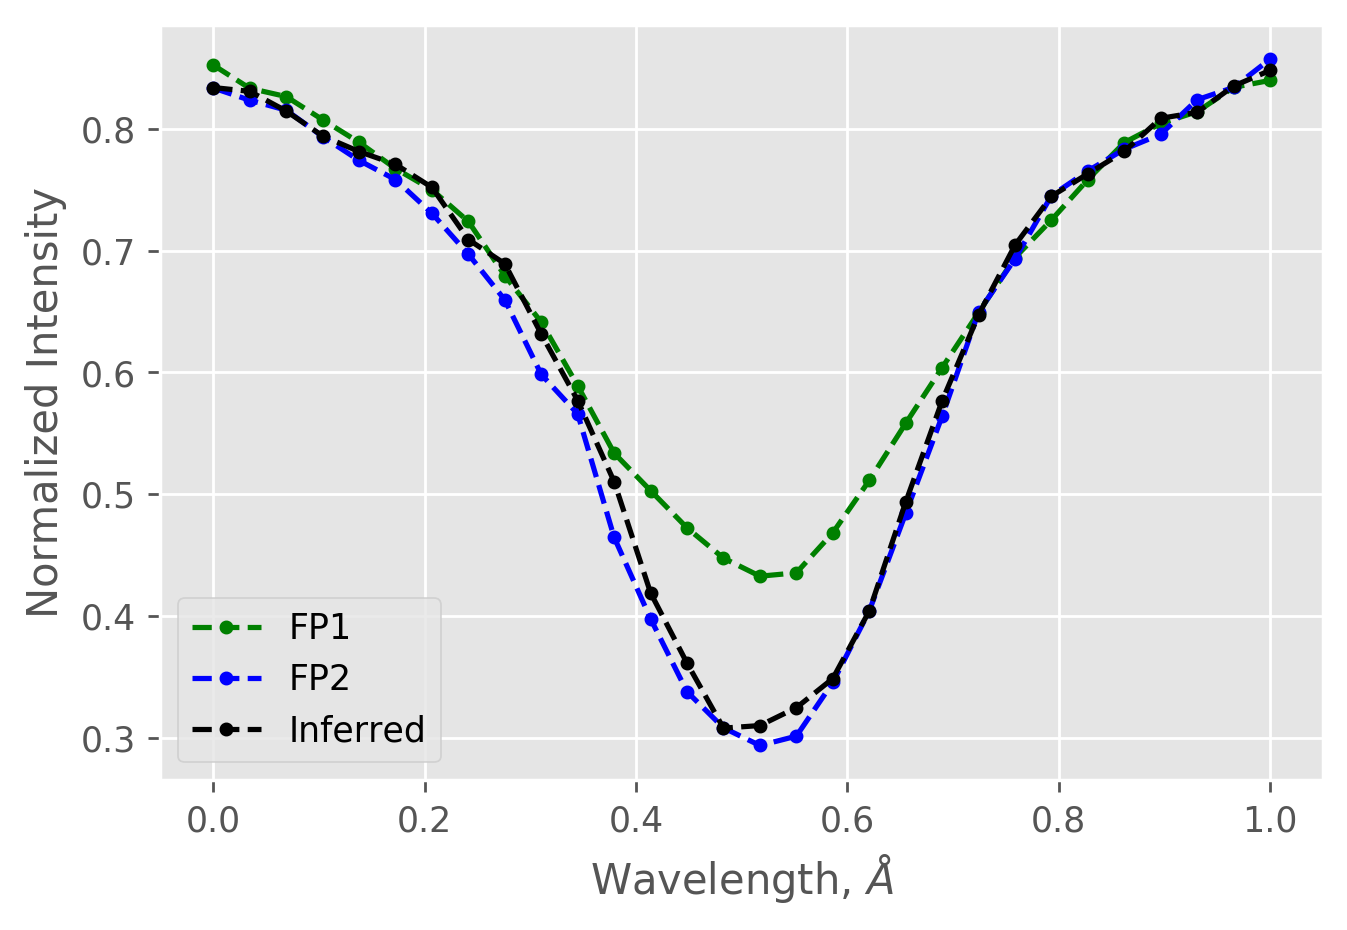

1 FP:nan, 2fp:0.2557915431025358, recovered:0.2462183949843531


In [109]:
prevNum  = 12000
delta    = 1

print(wavescale)
res = model.predict(train_set_modified_ML[prevNum:(prevNum + delta), :, :])

wavescale = np.linspace(0, 1, num=dl)
plot_spec_profile_comparison(wavescale, train_set_modified_ML[prevNum, : , 0],
                             truth_set_modified_ML[prevNum, :], res[0, :])

width_truth = calc_line_width(wavescale, truth_set_modified_ML[prevNum, :], .2, .5)
width_train = calc_line_width(wavescale, train_set_modified_ML[prevNum, :], .2, .5)
width_res = calc_line_width(wavescale, res[0, :], .2, .5)

print(f'1 FP:{width_train}, 2fp:{width_truth}, recovered:{width_res}')

38755/38755 [==============================] - 1s 32us/sample


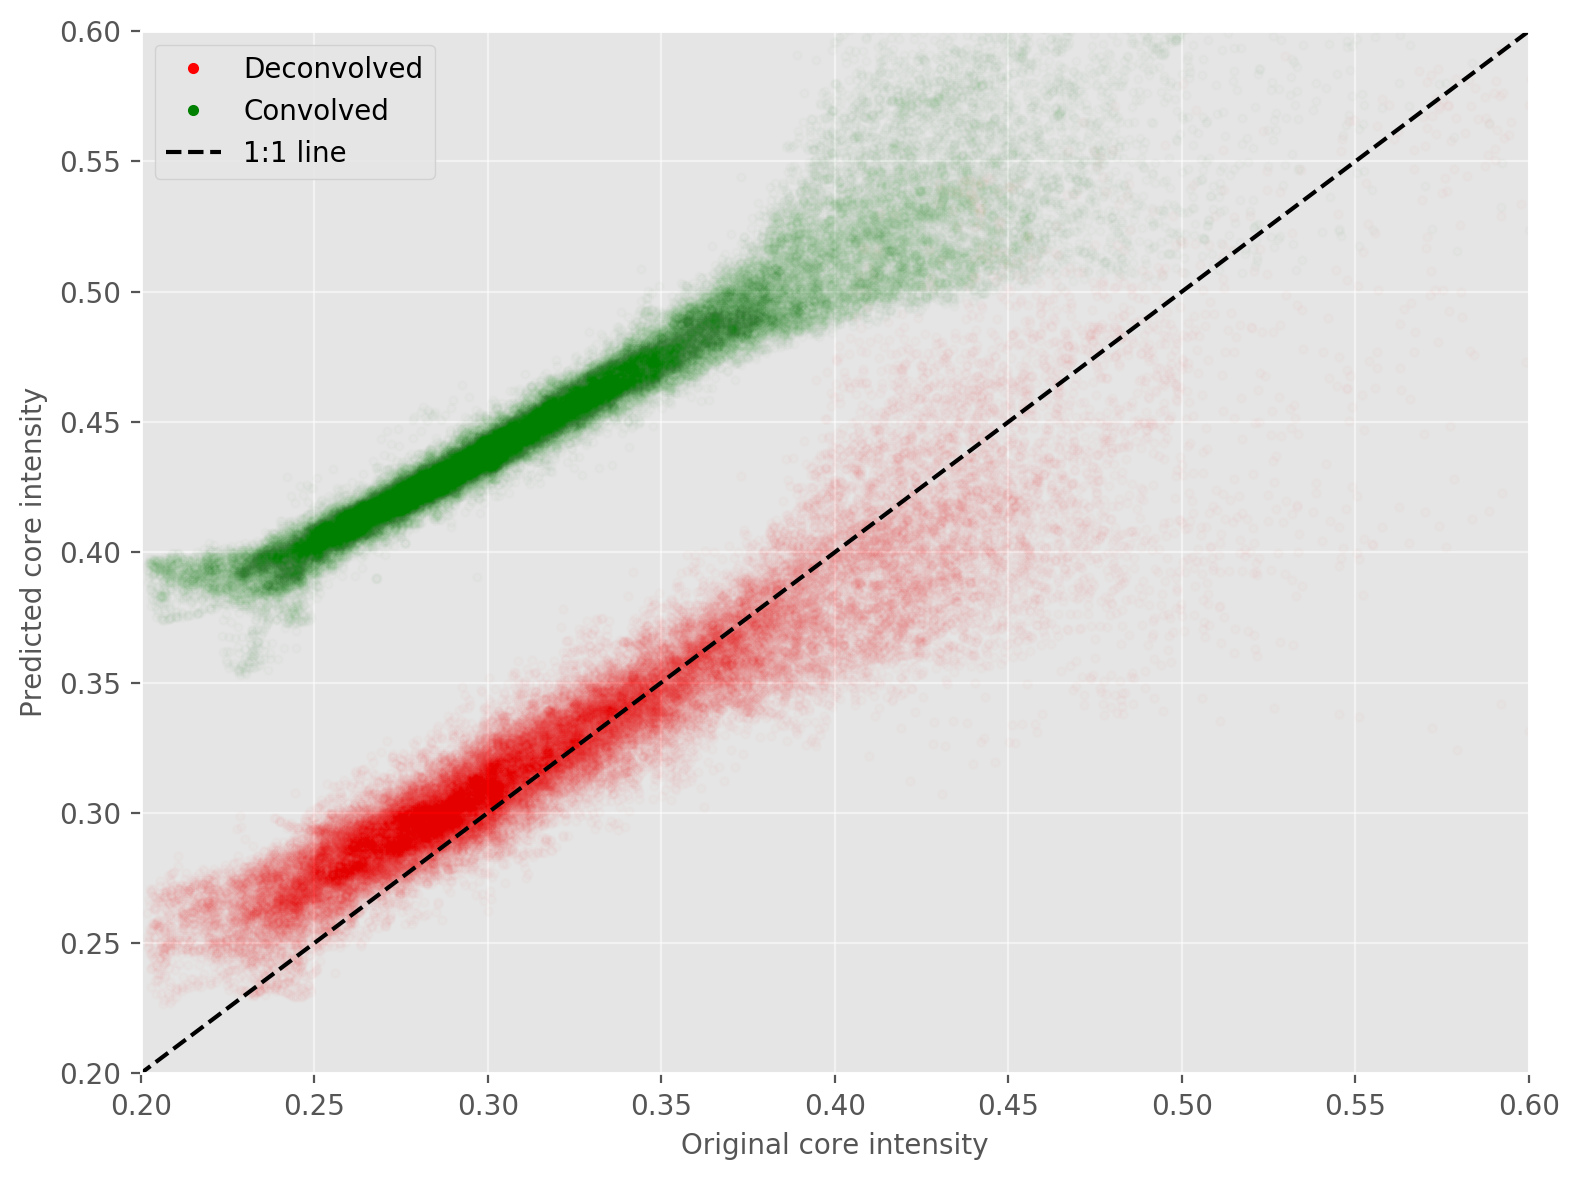

In [117]:
fSizeAxisLabel = 10

start = time.process_time()

predict    = model.predict(train_set_modified_ML, verbose=1)


min_I_predict  = Parallel(n_jobs=4)(delayed(I_min_find)(waves, i, 2, -2, 9) for i in predict)
min_I_truth_ML = Parallel(n_jobs=4)(delayed(I_min_find)(waves, i, 2, -2, 9) for i
                                    in truth_set_modified_ML)
min_I_train_ML = Parallel(n_jobs=4)(delayed(I_min_find)(waves, i, 2, -2, 9) for
                                    i in train_set_modified_ML)

wavex = np.linspace(np.amin(predict)-.05,np.amax(predict),num=1000)


plt.figure(dpi=200,figsize=(8,6))


plt.plot(min_I_truth_ML, min_I_predict, 'r.', alpha=0.012)
plt.plot(0, 0, 'r.', label='Deconvolved')

plt.plot(min_I_truth_ML, min_I_train_ML, 'g.', alpha=0.012)
plt.plot(0,0, 'g.', label='Convolved')
plt.plot(wavex,wavex,'k--', label='1:1 line')

np.savez('Fig3_2.npz', train_set_modified_ML, predict, truth_set_modified_ML, wavex)

plt.xlabel('Original core intensity', fontsize = fSizeAxisLabel)
plt.ylabel('Predicted core intensity', fontsize = fSizeAxisLabel)
plt.legend()
plt.xlim(.2, .6)
plt.ylim(0.2, .6)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

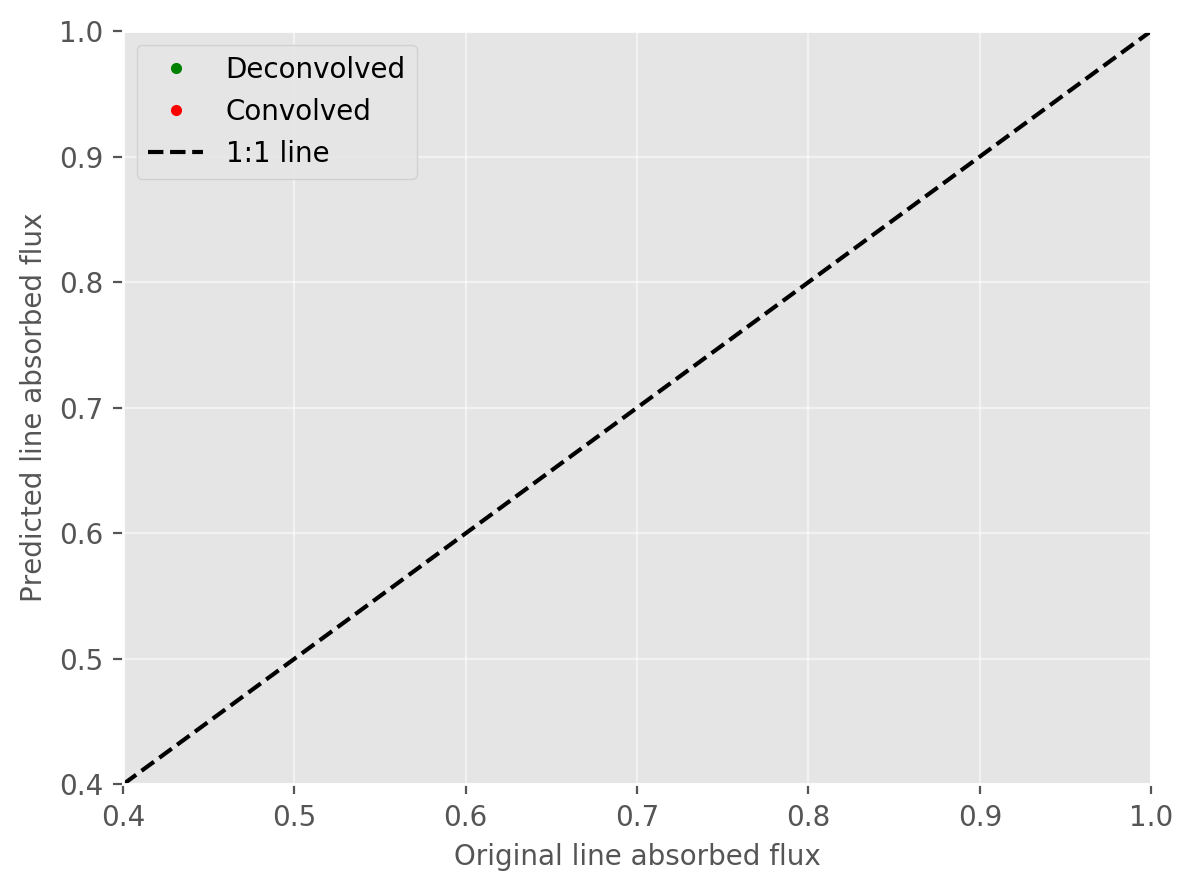

In [120]:
wavex = np.linspace(0,200,num=1000)
waves = np.linspace(0, 29, num=30)
plt.figure(dpi=200,figsize=(6,4.5))

size_datasets = (width_train_set_ML.shape)[0] #(train_set_modified_ML.shape)[0]
# print(size_datasets)

width_predict  = Parallel(n_jobs=4)(delayed(calc_line_width)(waves, i, 5, .5) for i in predict)
width_truth_ML = Parallel(n_jobs=4)(delayed(calc_line_width)(waves, i, 5, .5) for i
                                    in truth_set_modified_ML)
width_train_ML = Parallel(n_jobs=4)(delayed(calc_line_width)(waves, i, 5, .5) for
                                    i in train_set_modified_ML)


plt.plot(width_truth_ML, width_train_ML, 'r.', alpha=0.042)

plt.plot(width_truth_ML, width_predict, 'g.', alpha=0.042)

plt.plot(0, 0, 'g.', label='Deconvolved')
plt.plot(0, 0, 'r.', label='Convolved')

plt.plot(wavex, wavex, 'k--', label='1:1 line')

    
plt.xlabel('Original line absorbed flux', fontsize = fSizeAxisLabel)
plt.ylabel('Predicted line absorbed flux', fontsize = fSizeAxisLabel)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.ylim(0.4, 1)
plt.xlim(0.4, 1)
plt.show()


np.savez('Fig_3_3.npz', wavex)

10.095264776316014


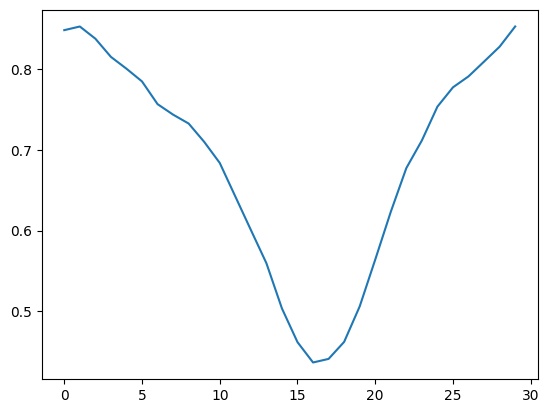

In [15]:
print(lc_find(np.linspace(0, 29, num=29), train_set1[20123], 2, -2, 9))
plt.plot(train_set1[20123])
plt.show()

cent_wave is 15.0
The dlambdas are 23.0 and 7.0
I_red and I_blue are 0.711944580078125 and 0.7381606698036194
the I blue and red thresholds are 0.5662451791012494 and0.5793532239639966


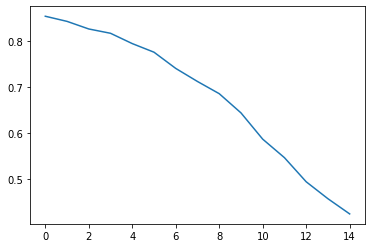

The bisector are blue: 10.521958846671804 and  red:19.40070574884038
The width is 8.878746902168576


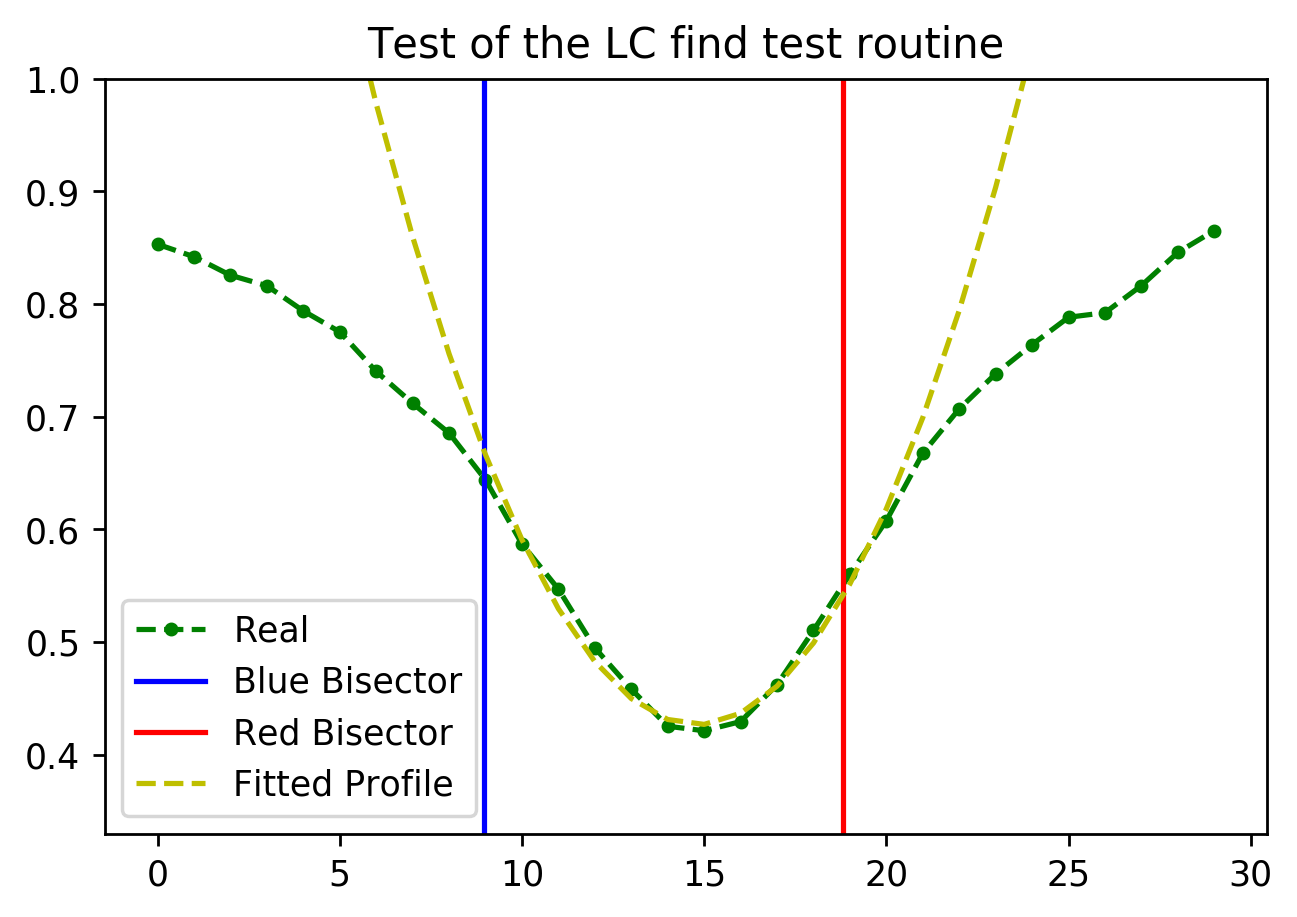

In [10]:
test_index = 10000

def parabola(waves, coeff):
    return [(coeff[0]*i**2 + coeff[1]*i + coeff[2]) for i in waves]

waves = np.linspace(0, 29, num=30)
coeff = lc_find(waves, train_set1[test_index], 2, -2, 9)

line_y = np.linspace(.2, 1, num=100)

width = calc_line_width(waves, train_set1[test_index], 8, .5)
print(f'The width is {width}')
plt.figure(dpi=250)
plt.plot(waves, train_set1[test_index], 'g.--', label='Real')
plt.plot(np.linspace(8.95, 8.95, num=100), line_y, 'b-', label='Blue Bisector')
plt.plot(np.linspace(18.8, 18.8, num=100), line_y, 'r-', label='Red Bisector')
plt.plot(waves, parabola(waves, coeff), 'y--', label='Fitted Profile')
plt.legend()
plt.ylim(0.33, 1)
plt.title('Test of the LC find test routine')
plt.show()

In [84]:
def calc_line_width(wave, Ic, offset, I_threshold):
    '''
    Compute the line width with bisector width following Cauzzi et al. (2009)
    ApJ and the IDL code in lc_find, calc_line_width.pro

    Parameters
    ----------
    wave   : wavelength grid
    Ic     : Intensity grid
    offset : offset for the bisector, given in units as the wave input
    I_threshold : What percentage of the intensity difference between center and
    the bisector to use for measurement of the width

    Returns
    -------
    width : width of the line measured in units of <wave> array, float

    '''

    # Find line center
    try:
        I_min = I_min_find(wave, Ic, 2, -2, 7)
        I_diff = np.abs(Ic - I_min)
        cent_index = I_diff.argmin()
        cent_wave = wave[cent_index]

        dlambda_blue = cent_wave - offset
        dlambda_red = cent_wave + offset
        # Find the wavelength points at half intensity <- Interpolate I in
        # wavelength and then search for them?

        I_blue = np.interp(dlambda_blue, wave, Ic)
        I_red = np.interp(dlambda_red, wave, Ic)

        bisector_blue = np.interp((I_threshold * (I_blue - I_min))
                                  + I_min, np.flipud(Ic[0:cent_index]),
                                  np.flipud(wave[0:cent_index]))

        bisector_red = np.interp(I_threshold * (I_red - I_min)
                                 + I_min, Ic[cent_index:-1],
                                 wave[cent_index:-1])

        width = bisector_red - bisector_blue
        return width

    except ValueError:
        return float('Nan')
    
res = model.predict(train_set_modified_ML)
    
for ii in range(900000):
    print(calc_line_width(wavescale, train_set_modified_ML[ii, :, 0], 5, .5))
    print(calc_line_width(wavescale, truth_set_modified_ML[ii, :], 5, .5))
    print(calc_line_width(wavescale, res[ii, :], 5, .5))
    print("\n")

0.35934055055777864
0.30049467617891984
0.3630622307703979


0.38276867834689027
0.31025101987739095
0.3535206690229733


0.3901131219999918
0.31613568951094295
0.35247563960574496


0.39480312353419583
0.321273487848729
0.351724132671041


0.39116045433022906
0.27258239103461734
0.3525792219894004


0.3635659851411005
0.3811565310413899
0.36716614589153984


0.3427638227924462
0.44968678802967815
0.37578622420929503


0.33694846037571263
0.45253304419069107
0.3783445314847524


0.32770589492624536
0.45147061168041375
0.3761747186907966


0.31250807199796105
0.452405366450973
0.3720145159615025


0.29788324164747065
0.4545666521971006
0.36506732351869


0.28750525415560885
0.45695395542085615
0.36222508006507115


0.27985085560587547
0.4542333013187029
0.3579939097199903


0.2659298230537122
0.44767495949602343
0.3587696252496303


0.27207872764349156
0.4292273297436492
0.3559259753008462


0.28396403625773037
0.4243154268766491
0.35714370807384105


0.30040149029164176
0.4172732127589

0.3832082690689146
0.2952330510730565
0.3529284203247561


0.3858972334651754
0.3039105380246488
0.3534205922219655


0.3896287632047827
0.3142517914382906
0.35426184797631216


0.3566101586643241
0.37261456750944844
0.36856909273073657


0.35622026625033004
0.3834369501577057
0.3699946597978236


0.4263911038400218
0.3441330064638687
0.3493368165626957


0.3462974649037919
0.29755275812925625
0.3513916997847139


0.349494267448109
0.2811823160180904
0.3586658174432403


0.35139258734238726
0.28112462878705663
0.36042681801369636


0.3534669747647742
0.2800416569308993
0.3621748843287288


0.3752984974465393
0.3231130453141104
0.35725482612870046


0.3817544793421404
0.29973277413898763
0.36185381632991187


0.3800770352498584
0.2983112040025687
0.36120994412844215


0.37650457839349033
0.2978135228230153
0.3613098402044277


0.36538956725601124
0.30123215990167074
0.3519397229133354


0.36395026903236194
0.301588248873232
0.354529379453875


0.3619731001139211
0.3025873361751052
0.353

0.3543405161729272


0.37182602231299927
0.2799862571899786
0.35715610359937194


0.37518396871178944
0.33975923618564857
0.3610783450316001


0.3744460266007706
0.3385926471029527
0.3629297238475015


0.3730894082031507
0.29826247848439186
0.3535224204597127


0.3648150362143759
0.299148712344238
0.34565806864282755


0.36218711976632495
0.29821916308935237
0.34133323652835185


0.36110076594704854
0.29756516374955044
0.33565136123032924


0.3610537592220083
0.29841019683481473
0.34674826094012867


0.36123592803792076
0.3002702885872815
0.3487151250281099


0.36091409445388367
0.30264713400163923
0.35267479432379467


0.36012057149925736
0.30558565406340443
0.3561270378107401


0.35761805855224305
0.3081709533636508
0.35854528448507295


0.35489151476938496
0.3101601416160825
0.3610589275978323


0.3511269856051527
0.31107644291249786
0.36283221388815384


0.346853292547229
0.31141947010572363
0.36273066797349696


0.3428976306737895
0.31189654450401555
0.36158860700002393


0.340923

0.38363128338932484
0.2816251572040665
0.3541376274069899


0.3663660914214546
0.3284045845598016
0.3633238775505678


0.3703190308158181
0.33462095853159357
0.3653790904424097


0.40173776236328185
0.3203671296657717
0.3388576668473386


0.36390268384450447
0.3203656660605721
0.35459525752999005


0.3618301324594605
0.32123703743405807
0.353280933514806


0.35531199231941907
0.3205990286638074
0.3535584832787234


0.349905849588027
0.3195366261615763
0.3559883708782802


0.3469978995570505
0.3185705034249889
0.3582933620097403


0.38310574721140306
0.3593902619232898
0.3462270845943568


0.39408619409156026
0.3646982596246841
0.3476122790140078


0.3997715308011299
0.36770813851586215
0.34918820021374675


0.3993143694604373
0.37007828648924596
0.35022680818602125


0.3966207844396482
0.3722892669434041
0.34827218675569244


0.39555049572666373
0.3739670077709695
0.3479575913295404


0.39877584423269885
0.3748648810043618
0.3475061649908413


0.386868666505784
0.3302398668395971
0.348

0.35898998074492083


0.3737907999688445
0.3326728627652461
0.3596691609112365


0.36941895828026444
0.3364667696431375
0.3590974455856001


0.3639172181170059
0.3317477674342146
0.34982228144376704


0.38820456162641337
0.3314931960033558
0.349926462963887


0.3464780062784102
0.2944924221438101
0.3497921306282168


0.46237835363253743
0.349088323215066
0.35522630682091955


0.458519146516907
0.33128853414532805
0.3590240665674107


0.4508210456072891
0.3208363051636953
0.3636043120288549


0.3655006583718078
0.3543839540441419
0.34826068291809276


0.38755941280827116
0.33170898481597416
0.36052360858141586


0.3869660490109192
0.32514566832470776
0.35475749797302936


0.4007682919750315
0.3484158731313131
0.3452894389247209


0.3947603979051384
0.3492901480988074
0.34533848506916787


0.3838136665394849
0.32375778251543846
0.35123171633325007


0.3904965892632756
0.31190152053975545
0.34981815309322


0.38921420690873215
0.311168369861466
0.3499260296727831


0.3622862785642934
0.36

0.3539531435829615


0.3922368171106903
0.35376934724996423
0.3489846888061962


0.40120316105588194
0.32091476083568554
0.34531551606071814


0.3833678028086287
0.3028312915083536
0.34554665304506144


0.34826717590304795
0.28832166121384367
0.3499629500283946


0.3528311306182476
0.2745589844201194
0.35197861295827887


0.3433907944005515
0.37113429803786135
0.34659903894171845


0.3352522737101607
0.37338846721328933
0.3429447558170241


0.3301471541653891
0.3747858260624861
0.356066352095052


0.3341264076693014
0.37575171554494297
0.3580254107798343


0.34645113825457186
0.3811111281321015
0.3541824170416323


0.410490211520252
0.3307721387927988
0.3615674021065446


0.43647045029755777
0.31556127432071757
0.36602347916729944


0.43688782324501163
0.3135737915705031
0.36700341291031263


0.4147445698735375
0.2829494525320442
0.35785287865627263


0.4107485878035424
0.2810916332999441
0.35698944312248787


0.40784249980856696
0.2815599211876487
0.3570441618998945


0.40580523790739

0.36848683402160837
0.290384543267847
0.34217564821143487


0.31980874597971226
0.31720592705748996
0.34973512208683755


0.37860238409157576
0.32102124164929563
0.36075754715879715


0.3802234226244571
0.39620964705065664
0.3570086755955588


0.34591388911475535
0.36345082443894383
0.3496842429553877


0.3385579656050964
0.36544705695352636
0.34457838793797435


0.3338890458749819
0.3653007119907228
0.3380386829480558


0.3315165305575597
0.3649614827830865
0.353432969304895


0.33535190132645876
0.37209602350580095
0.35341414912874114


0.3409996177195306
0.3776944476214081
0.35273831438739295


0.3457469125686345
0.3826722314392165
0.3494286035834734


0.348229666916024
0.3865895069592711
0.3462505249814818


0.3488682054683005
0.39008559601296194
0.3452847655785574


0.3486732158217529
0.39338139101705477
0.3466833610549606


0.41880432675607915
0.33260082242570566
0.3668513408925137


0.4219415244280966
0.32885908125052093
0.3684058229439512


0.42658975625183443
0.326000387303258

0.3244606948324658
0.343012347658851


0.44804850788316863
0.32374273486826327
0.3432655355288272


0.4473619790828842
0.31439048756591126
0.36096479194993303


0.44020758948529093
0.31306341765115797
0.36371828516494203


0.43256786175309436
0.31113819983678515
0.3649269023685309


0.4274229447976762
0.30843967793632326
0.3665036991921332


0.42518602032208624
0.3052140381964797
0.3673890384942449


0.36597832584099627
0.33189334800032216
0.34978318015467197


0.36212493696966125
0.3301020102927575
0.35158883838155613


0.4293473121895835
0.3043300071279177
0.37379129543826023


0.4290960709341262
0.30382517642940504
0.37429725894881344


0.41626719467354223
0.27234912372755854
0.3639520478359759


0.4098630275546298
0.2778837085370659
0.36570356066528514


0.39933767707251083
0.2742331257933164
0.36428216596231433


0.4066301227635955
0.27686649928316986
0.3665251108266854


0.40411162872585965
0.2809841046445044
0.3660008097175647


0.40178877578130556
0.28440159336757803
0.36437612

0.3237705545766851
0.3691976618997979


0.3785880254452704
0.3667691990798174
0.3543864833747379


0.4007610761788744
0.3212451494453966
0.35238084178167284


0.3983556604964671
0.32101313404550047
0.35054431373760325


0.3941593234101541
0.3183769679851785
0.35040300648133704


0.42355095649130603
0.32442395876191
0.35939816124949064


0.42084161294063477
0.33313319226713556
0.357835272289593


0.38697332590117434
0.324532705380685
0.3550301817211423


0.38859547771408
0.3352936773703495
0.35485366532781115


0.3924903598880595
0.34289062143545046
0.3492647722518842


0.3581808523452864
0.30981531110977173
0.343927215956168


0.36149046501186916
0.3047713422025111
0.3431756971674246


0.3734648550517552
0.2795942904537127
0.35707959603565714


0.36881528941467717
0.27539971305015
0.35696784557800326


0.35140315221556856
0.3104721426486504
0.3606990532169961


0.35836106189371286
0.3277610107185554
0.3620324536772319


0.39193650120462287
0.43176611593796727
0.3526618777106638


0.394

0.3160394518641709
0.3522809691758251


0.39699382627562285
0.3095168880104127
0.3512250294940907


0.3931530390903643
0.3054067122002871
0.3489667017374717


0.37785154469210586
0.31649517150697154
0.3682282249321635


0.3772999055368462
0.31983021251659804
0.36846116152678277


0.3988933783637805
0.3441342011064864
0.371316629383216


0.3605384819456154
0.36644963659896906
0.3582113557125601


0.36461504158916525
0.3733109710257715
0.3599101583566177


0.3959313116865299
0.4037341144953824
0.3649483775818496


0.38945423776145327
0.39796817575879617
0.3626177113095175


0.4375835574632239
0.36559629742374683
0.3153772308813081


0.43976042422115424
0.36331669713391984
0.3161413406975858


0.43916027355615395
0.3625551595141034
0.3178696847401236


0.43458546755259475
0.36174437597083386
0.3220923252247113


0.4242524381019256
0.3608134959070616
0.3567317341640834


0.41503015584532815
0.3593538719716196
0.3592299044152581


0.4093422922669422
0.3561029438326783
0.3606157109854935


0


0.47708992153729524
0.4136497642454296
0.348755406115358


0.47487434443545495
0.42106859373742606
0.3499027964154063


0.4741940577048677
0.4277401100512624
0.3512291066935859


0.47228065112638334
0.432989358491845
0.35147601355077973


0.4665855149412217
0.4339989235490027
0.35081037181373476


0.45815670508940076
0.42894475999435255
0.3503967163852774


0.43748351312757056
0.33329178861261016
0.3672586638371853


0.43921549096667595
0.3258582963828539
0.366431552731728


0.4374202798731297
0.32728438157349893
0.3658456865060971


0.4347719812088305
0.334464639953882
0.3630517260100785


0.43372195738603786
0.33947725783303245
0.3602933381039608


0.4318651003060826
0.3439012866919976
0.3617880156055569


0.40645015727537637
0.3483136441089542
0.36466673241392367


0.4018374519286431
0.35030173313555923
0.36582598334051475


0.3875696004229723
0.35563700751788485
0.36806096806201705


0.3803982193312674
0.35712404444427903
0.36782350513719253


0.3772157980426867
0.3622051259865970


0.3950195786945337
0.29564889561930546
0.3636660707838118


0.3896882188778517
0.3029039580028674
0.3684062783966893


0.3869104372338847
0.36718229963796273
0.3612823211798012


0.38965215569483
0.37211797535125796
0.36261537063720434


0.36737348247924384
0.34001489302137156
0.3664602654904007


0.3603919190324802
0.3368131562062258
0.3676309775844051


0.37292775400357214
0.3848811274447596
0.3603973305493598


0.3739836673530327
0.3849828993450606
0.3586979747331243


0.39429431837252293
0.37103952598506457
0.35815322282554996


0.39260047825959304
0.3236926036721443
0.35596439282063486


0.39632068572379314
0.3254233944107667
0.35297662200462143


0.3964967399162781
0.3281073496462063
0.3496581587322209


0.39496860862077365
0.3315935200646981
0.3460465194104682


0.3929008794920282
0.33503143206307606
0.3429997493093828


0.3915361983597648
0.33802628053863143
0.3411730677400389


0.390085528003364
0.34077799128232494
0.34017130285118996


0.38558731251737227
0.3491293762012437


0.3681389207030104


0.39544841503251466
0.4397815881115509
0.36967147191260435


0.39859758084438146
0.4391130009862293
0.37125486318669426


0.40392389427899966
0.43672345371315285
0.37281932465708767


0.40988583642141146
0.4327478060924721
0.37432205310170796


0.41724854919981086
0.4269000267352387
0.3750042155374252


0.4251721604450247
0.4193331917860151
0.37414649140660367


0.4401934773499613
0.37620463347291755
0.3456197982876373


0.44218794551028684
0.3712728671031879
0.3481719865887216


0.44168535397011244
0.36530792890376435
0.35067053371453527


0.3595200371288527
0.3238319539795893
0.3520721793025416


0.39104807716354945
0.32411439511273754
0.3649627849642713


0.3905702024071239
0.3265953362959426
0.36527541219375403


0.3898448639860329
0.3317835480207997
0.36621112894108665


0.3751089203319721
0.34196308926280794
0.3631259004302765


0.3536751332097863
0.3244454093730685
0.3632768214784243


0.4066652510188333
0.33062709936320717
0.36823763353733835


0.4093977172

0.36112242060516697


0.384262743489981
0.3758659263870671
0.3593725043910927


0.38454822562986624
0.38432630888583885
0.3576438192804308


0.38509099092223736
0.3934087353106896
0.3530930050617723


0.3881407148137004
0.36063247881437416
0.3491345923800293


0.39137755421035236
0.35635590502708353
0.35027254687683645


0.37774145508552176
0.3273130367528978
0.3478342801275529


0.3810212455078588
0.3286609487722956
0.3469906869743155


0.4012042257701015
0.34097427782050077
0.355673376023657


0.3963876072225091
0.34147426017669474
0.3569651858299359


0.39360221112313687
0.3401813470889363
0.35821516133307074


0.39901280617575813
0.33784093512259067
0.35745248064135726


0.4029881266726433
0.33718809657871923
0.3551684513872859


0.40605285978637745
0.338705491765397
0.3537201548764787


0.40609871656424407
0.34097045976704426
0.35273860097109694


0.4563229540265601
0.398377853979525
0.35855449331978295


0.3771128579701598
0.39662649935635713
0.3368579907855833


0.39042751761877

0.4188650802277387
0.3360932426423187
0.3548679019116419


0.4174694133718523
0.3371883078241062
0.35311394337651075


0.4048997534571443
0.33937993423492857
0.3524238476964341


0.39873131215756785
0.34337352549804034
0.35486830580469936


0.435054300574584
0.3929177001224104
0.3543147100339153


0.44569546527325005
0.3969866141592969
0.3467938608053683


0.4533892073403167
0.3980760233960616
0.3458477341183651


0.465624372901859
0.3616959171652196
0.35218706357209456


0.37100433085581275
0.38610611877573797
0.34420213885222223


0.3492316437324996
0.3112444363374872
0.36203484909416184


0.377745318827647
0.29990906312698085
0.33960627616237027


0.3833974129547122
0.3011321145347226
0.34060656037560216


0.3847808498514044
0.30390026620945665
0.3409267692204692


0.3803188798975844
0.3151172317245607
0.345577330079435


0.402591648820424
0.35007545065596846
0.3548066735739979


0.4033594760631517
0.3552825240512557
0.35262800491275464


0.40017231043806284
0.3581418740135426
0.352

0.3647375514397145


0.4114887546722274
0.33188141278596317
0.3621567692761086


0.4137149970698551
0.3266067395574821
0.36307774793917913


0.41690347618891915
0.3223007567552798
0.36488326852566155


0.41860432364289707
0.3174103369542012
0.36726498161490423


0.4206719297130908
0.3108265330776782
0.36839472964274406


0.42516452686340106
0.3023501812356951
0.3688675037675492


0.431472458184808
0.29221495081430554
0.36663779083309656


0.43532331215472403
0.28790512700597115
0.36868390338103263


0.41400144555235235
0.2957493463468881
0.3700135226065394


0.38655908619420287
0.3268539230508149
0.36542924273936683


0.3767299169205827
0.337902916729636
0.3667378422046129


0.36305514792035654
0.3832027859103589
0.36766159433809625


0.37659437014635955
0.32910873481622077
0.35686652310497774


0.3652012651719494
0.33232075522339366
0.33855079581752984


0.4184868361697552
0.335217366505302
0.35550815040769024


0.4129447283415557
0.3398107477499901
0.3567579039303119


0.397283638018

0.3583595132680359


0.38904367098819304
0.33024240001915767
0.35846935247933176


0.380593896133006
0.3326745381093118
0.36041723612998655


0.37370126346977683
0.3365194413783805
0.36148683465590553


0.3718658278914637
0.3424339407563277
0.36174298379462616


0.3755478694298793
0.3521118471897038
0.3638023616298238


0.3834412304908803
0.3644668979636792
0.3667795215578234


0.44300362566170215
0.35892057151573586
0.3588965559814491


0.4512729031410924
0.3572517968842512
0.3540512379650763


0.40049088871370425
0.37417825812280997
0.3577875723546018


0.33932214192717525
0.30492647546171975
0.3547323027589917


0.42777409538268085
0.3334925231869737
0.35722154328976485


0.3786698037902499
0.31815662071863104
0.3398070861954587


0.38601308557165986
0.3166949128282928
0.33893454488219815


0.3817049322601086
0.3222748669961473
0.3501489553746153


0.37869910388266026
0.3243917523584011
0.3524590784046454


0.37755525452658395
0.325606797024759
0.3541206077840856


0.377600107881984

0.34213417495675685
0.37433112160895454
0.3727427587602537


0.34407304535373623
0.37737438992192485
0.37176560945723874


0.3461206599380618
0.37905245785504377
0.3708497140014655


0.3846067289811635
0.3388695709000532
0.35200418033690606


0.38563909998648727
0.32910892622118065
0.3520152958919639


0.3660417855722339
0.31910650095278836
0.34378796352343227


0.3681845464986897
0.31616606212568144
0.3445591812378184


0.3729979864752746
0.2788331065073769
0.350943304697837


0.3697723524684606
0.2738551121626475
0.3495450394078652


0.366849558695494
0.2705556334268494
0.3479104952412662


0.3675511852818848
0.27834547142180976
0.3463618972771826


0.3719052545543847
0.2839422260558162
0.3453087106521216


0.3920089021103599
0.3259647213921146
0.35584502103804044


0.38770051782543097
0.3310949566537899
0.3558425048036793


0.3860401999357736
0.3359941774657539
0.3557147366565735


0.38699617226188715
0.3367439710478949
0.3566938628887487


0.38898471774518506
0.3286814219942601
0.3

0.36870947523991565
0.3724642860502724
0.3578141884511966


0.37224186188140107
0.36628895258981725
0.3583917029649578


0.40772992808876335
0.32411338692205266
0.36059740881375946


0.4107450699364563
0.3254339766837095
0.3610973967806557


0.41329073972391656
0.32488979922543587
0.36126698786054795


0.4140745122115728
0.3236737188618699
0.36108262804271407


0.40279774230987614
0.3194342223814703
0.3599613764911981


0.38423275648973526
0.2740920895009582
0.3652346966263188


0.45231070777980575
0.380054230617113
0.35637641082036875


0.4545989686974735
0.3752943166986308
0.3583772094781436


0.45635238053650795
0.3702713672822155
0.3599481660604734


0.4573831725749201
0.3621553089041617
0.3602286024283075


0.41937333302052454
0.3693081142839741
0.3638986960502288


0.4138234490352246
0.37142196521938886
0.3625091196733986


0.4039391278623579
0.37034094314278165
0.35694275972981815


0.40714121990408053
0.3690134963299282
0.35473764371172295


0.43592341368210863
0.37312568621850

0.3050712649298597
0.37161115499280284


0.403693808639251
0.36709358490746574
0.3557452316633504


0.39846056714653927
0.3657577072860115
0.3525559027647013


0.39078263052492296
0.36465231726426556
0.350670754310629


0.38244042224186137
0.36717907083671575
0.35042707607555224


0.3911790627960895
0.33979165174081316
0.36039712880761826


0.39080698948493675
0.3409165539433491
0.3603191132955721


0.38982666849056236
0.34223369086045713
0.3610049708266171


0.389528921595294
0.3432892336658625
0.3614539676262784


0.3804762565381294
0.361103797435171
0.35534700424799565


0.3881236647276424
0.3628305531649784
0.35653287144935425


0.41280602122678867
0.3389050449766269
0.35635051992581285


0.4212661008737806
0.3241599376569122
0.3573036903299493


0.4217654367609496
0.38845032121679723
0.3655232803514326


0.4208434377850539
0.367702118624387
0.36773029914792216


0.4244679843895325
0.35073085754344113
0.36727513065461


0.42918843586425687
0.3459934440419482
0.3670172722015251


0.

0.3649559977616411


0.39992362620764066
0.36304400571577233
0.36524575911476503


0.39654717568625975
0.36226379828146665
0.36606574734858865


0.3573463733109466
0.31338199817504986
0.3472062333909794


0.40232650231181827
0.3417398691245116
0.3653465919577482


0.40351291440820275
0.34080572078277893
0.36754232048238195


0.4117321581877337
0.29850362681591563
0.36545436387409874


0.3776127521895955
0.30515217668365613
0.36121186848956843


0.38199475370883035
0.34805688808560026
0.36146300321695846


0.381190567081971
0.34799128662201284
0.3610907485347414


0.3793260680277002
0.349239629084769
0.3601200979659883


0.39205422019708047
0.35854618969090146
0.3537078573133687


0.410182896681533
0.3645533981412857
0.3531317958581292


0.4086403414407169
0.3617015237145028
0.35185466152566364


0.4085552527971522
0.35359567047612944
0.35329241804824396


0.4214702506542478
0.37435407321280323
0.3682279170868303


0.4213298018189672
0.3580627950835763
0.3674346027681186


0.42366007153

0.3683773939698436


0.4103462462001955
0.33701934847373305
0.3665598471830059


0.419483486182769
0.3213085523519029
0.3646708928576086


0.42542992177322775
0.3096164566961335
0.36363462501254074


0.42992093270989673
0.30834416351059407
0.36232861820338774


0.43490248145316496
0.3084237520093844
0.36067857448419166


0.43967755165946987
0.3105007749612188
0.35692698507211823


0.38968722089767355
0.39213701744297436
0.37145173321458996


0.3866802779273073
0.3937851816416885
0.37047694890962546


0.36607755879024484
0.3264147470400616
0.3732088499725371


0.37203680858580057
0.3253282267043867
0.3716646692183572


0.37820183706972216
0.3254273627894037
0.36987327554745913


0.3832916692288691
0.32135427634574193
0.3685705657871917


0.3854632181459318
0.3176859096316367
0.3678102235069161


0.3860660146565082
0.3165779665109939
0.3668051377365046


0.38679538825092813
0.3161105344294901
0.3647131757915003


0.38565830329720246
0.3128919583933043
0.35641238638864847


0.362056373558

0.38277457202965226
0.3562563530874405


0.3815056226617527
0.32539672014161414
0.3736474219339427


0.3854471772798999
0.3270212346220775
0.3725213760103561


0.3893456634815782
0.32379527494729304
0.3706128828946136


0.3921094318165531
0.3226367094103113
0.36825323731998094


0.39287264713767234
0.3222255034918391
0.36625278017173457


0.39246486722454965
0.32114113890032714
0.3639889448959855


0.395675389752652
0.31473869169872715
0.3565359228283301


0.39897105147758033
0.31213585566175556
0.3554466126390919


0.40121027103948453
0.3112479293894477
0.3560087001228491


0.4004869903658946
0.31119923922044745
0.3576981414910606


0.38851025814642487
0.2734004597395089
0.36153646920445415


0.38833622415410674
0.2693971072122066
0.3615954354399513


0.38970726503922326
0.26762384229841163
0.36255498763143656


0.4214354185207757
0.30951311532527276
0.35164090964740075


0.4175635184388365
0.31473369607089396
0.3499354519867304


0.4172610080688276
0.3211148952054739
0.34979402331878

0.3662619732252959


0.3894092577612094
0.3306052697282588
0.36649457032037863


0.37406170023779445
0.34201481019387947
0.3706236080817516


0.4102819264498308
0.3344392573930737
0.36266840143500406


0.3997253835699148
0.34305400516759177
0.36491469652460234


0.3958515409463924
0.3372744645502094
0.365700645854529


0.39274582425947685
0.33068490966078673
0.3661423740199324


0.3908428240352385
0.3270110787126103
0.366597233639188


0.389679437728731
0.3249305774978489
0.3674058350448532


0.38730672104183983
0.32260711401361386
0.36792685092161465


0.3845294528790955
0.3209667407314387
0.3672391208400645


0.3679940386227045
0.35274328955130335
0.37120670990430005


0.37272924344417546
0.38980842712424524
0.3685727296173459


0.33942124569507287
0.33238090722444835
0.36964828793210386


0.3398545805319312
0.3296322879755118
0.37037696427079464


0.34179180907291085
0.32662727135617997
0.36941359597336393


0.34443371085787916
0.32314519839932876
0.3683154820361936


0.348690488331

0.4209678283219776
0.38942674261613464
0.35379386428224957


0.39855165778647517
0.37650053196456085
0.351025364596926


0.39230317220037947
0.3727439078400651
0.352774220941316


0.3552920387433216
0.3766086400515741
0.34424709373742673


0.40755767872632304
0.3079166262772922
0.36287762627377995


0.40545836226891324
0.3169892780240797
0.3612108349646871


0.4041503869625014
0.32393321070250847
0.3597414908013667


0.403198389280702
0.3303098000921418
0.3583582305914036


0.4026692445213899
0.3361695183074899
0.35779653630053687


0.4002566737541327
0.3303281591859686
0.36509578583872615


0.400601432430791
0.3188013148539653
0.3651931412872526


0.4003493917558672
0.31592767989186826
0.3635571962405043


0.3966173468954837
0.3157664257237306
0.3628251790240721


0.390231003383403
0.3163253956448004
0.36478356132124484


0.38468858047369686
0.31447445156743514
0.367356010128573


0.3814253605589229
0.3122930069381505
0.3682709393112135


0.3895421455988007
0.2997503585669294
0.357805

0.3782271582533422
0.3117565659821909
0.33462385922425025


0.3611307628605875
0.39289606402576205
0.3563675378025983


0.35549118540404534
0.39413371656451424
0.3549600405443069


0.40877140432168063
0.32794555070195586
0.3545268224673739


0.36656353403848824
0.32335531916258486
0.360953533616301


0.36533468086757387
0.3285815143649724
0.35742473828041216


0.3637262736717754
0.33386946978687015
0.3569435503469797


0.37338973817941934
0.31788116375175224
0.3712400184331302


0.3689780773554448
0.2980561904927791
0.3448627390746896


0.36794994651720087
0.35839409833743796
0.36225507357021286


0.3877656624674981
0.35462237161340093
0.35364605126153154


0.3854614835530219
0.352404507180874
0.3508993892989585


0.38362294607188213
0.3497558510609653
0.35241741863987636


0.4253760746940606
0.32253844422099126
0.34613731966311034


0.4272854460503553
0.3176629837124718
0.3460981798145017


0.4285670832796478
0.31607866203953877
0.3464685938028331


0.4238264605018567
0.36231738659267


0.43743631503324076
0.3237956449247213
0.3437705870648196


0.3940507981805533
0.3628124219706666
0.3641104752762514


0.38967847318090626
0.3603518769005291
0.365733592199745


0.3975206520065629
0.30655443099222707
0.3613728686038339


0.40460530689843716
0.35456641202333034
0.36464730437245363


0.3290731884561959
0.3399757756760644
0.36350294399210453


0.3686831051340463
0.3651765207323548
0.36833358077672734


0.36504143639267655
0.35894217334155704
0.36975178165749595


0.35739717792145914
0.35542104756714593
0.3571729120371724


0.3601149656369959
0.35635251770744314
0.3583128216804568


0.38524849315445914
0.30791568039597605
0.33443883197442836


0.4016480884997429
0.3050177633683524
0.33480522016295605


0.41154053910311583
0.3001009490916003
0.3358362956035734


0.41666527691131494
0.295663827660427
0.33707141080625364


0.41582686578656836
0.29888418675883444
0.33794958965994015


0.41338398760416467
0.3051169961648017
0.3391929533822904


0.40629091342569373
0.3702173285

0.35196102668414375


0.4071261720759588
0.3875471463812951
0.35324232618684476


0.40678310655471794
0.38950844392366946
0.35133766851436476


0.3724182810614738
0.393769721062928
0.34070606089809763


0.37133990664362077
0.39128059486938205
0.341414546681467


0.3636031552433959
0.38802758341553356
0.33965226058301795


0.3668443834029279
0.3876385666608934
0.3378123944640372


0.37040131986346525
0.38648794643067125
0.33738217421771255


0.3717996251100124
0.38407195838900277
0.3387840059723403


0.36819209250068835
0.3807325979930405
0.3401490269423995


0.3638089419695863
0.3519901027025435
0.3423721149763868


0.4165018582531091
0.44700327419854513
0.3706778942807235


0.4169327615643362
0.450929005064892
0.37176405970794624


0.3763722639245073
0.3426119289984437
0.36276138827669374


0.3727762877878429
0.33792421973534603
0.35941126948477775


0.3698825008604257
0.33909570209736706
0.3576734163459649


0.3660801563615352
0.3447209577868837
0.3576004171262781


0.371929762349295

0.3614094173615109


0.36259970655365703
0.35734361537858134
0.3635031838800699


0.3678243828169806
0.32767057008603406
0.35629386557930737


0.36622179499568347
0.32716168303974336
0.355176372472478


0.368183315324423
0.3265573222136666
0.35223954915497313


0.369587806999817
0.3267872860531027
0.35178725458655735


0.3675314022832701
0.329095728023482
0.35078773047265355


0.3621343758893298
0.3323509714985424
0.35055307355664916


0.3505160808979427
0.34707176836140724
0.3548151264366726


0.351105523640078
0.34871179025699706
0.35579796621701487


0.3511677141998012
0.34965598172078427
0.3569124522449416


0.41794178578790203
0.37865489636359084
0.3623078409266717


0.4194252061161805
0.32487031400211036
0.3508914365020682


0.39297376806949375
0.31314864907832146
0.3504910476058609


0.3834946150428029
0.31240862708073647
0.3466080826815981


0.38205115437462267
0.31655922020313176
0.34521001777671356


0.3809002717449008
0.3204229845155041
0.34516291488310746


0.40214412513350

0.3475230945788838


0.35553054528042505
0.3399619132612784
0.34555882653209014


0.3595981795012898
0.340878991726455
0.3404259000071453


0.40172595580719306
0.3715408234011265
0.35753742485652246


0.39694183061042704
0.36318744030922057
0.3562763821898942


0.44383099078242055
0.3296177063439693
0.35403273829640625


0.4371816621170702
0.3258867742076133
0.35277095799072006


0.3594274382324602
0.3404781056477107
0.3459983875375402


0.35910325377526986
0.3376193709189531
0.34820910198323873


0.35680363381860936
0.33360677315891485
0.34667015231735887


0.35268901864261115
0.32913429752523204
0.34720528419312857


0.3456878503606828
0.3270529233478364
0.34925969195522083


0.32730096318568896
0.3274310725621493
0.35213511535124753


0.3249220678667903
0.3287350867451465
0.35169285025738645


0.32155745589671975
0.3312798525456152
0.34980116718406173


0.3177262779480691
0.336470413323653
0.34636212845429926


0.31716152870176434
0.3493493362796704
0.32826068438143213


0.312322822

0.32436886611330695
0.34577736394863456


0.3597871230817518
0.3299204191238242
0.34565947469441355


0.35946581406278283
0.33349330933101984
0.34430424030325524


0.3602714856954268
0.3342967619058601
0.342350282028156


0.35970767846312124
0.3344869611682412
0.34052144154262187


0.3574627060418473
0.3356337653308107
0.33962351306513044


0.35589180332235815
0.3348805893000038
0.34015628390913694


0.35677110838460224
0.33358415969216554
0.34246468517476103


0.3595777872653215
0.33416157572916144
0.3454599551333239


0.36275724568567436
0.33736080648491495
0.3467001147198573


0.43432073043656233
0.30335980016883574
0.3475530616993527


0.43846970683775227
0.3053157726107384
0.3478747934777869


0.366704009817441
0.3086201272538017
0.3500502617530887


0.36350369800858084
0.31347364289924107
0.34959749904277854


0.3563408342060404
0.3341080065156407
0.3460770304172384


0.31190784776150665
0.32354297404268517
0.34639742574324073


0.372690709093028
0.322226592153311
0.3467805147679


0.39366964534733195
0.3616679403216187
0.35925229161753164


0.3663097044449919
0.35903478819530205
0.37300874730285993


0.36714508910030547
0.34899495579935413
0.3709458723706044


0.3618774339635111
0.34231169100838954
0.3702136804486905


0.3308213214941455
0.3262631092918979
0.3741311564961287


0.3260685380696804
0.31869600341985455
0.371196619685396


0.4030582594352954
0.40556054086944293
0.36562684046251465


0.40269744930723694
0.40726610595910123
0.36577001707097195


0.3630122913528252
0.3245778826197821
0.34224371219813243


0.3634133177683385
0.3288208876284388
0.34323395764190395


0.363573127866998
0.33152407255594096
0.3439126537718423


0.35809586912673835
0.34756642579142405
0.3476069078129243


0.3572643942949247
0.3476184997175216
0.3490421858929633


0.35782390694801186
0.3452865867266118
0.3502016821298197


0.358832418050181
0.34110534824935934
0.3503690250414417


0.3614472565932485
0.33617597090266427
0.3511540942903869


0.36259926879845117
0.332104684334718

0.3960474195985702
0.3973108963389868
0.3613261552251612


0.3587121050059197
0.3297583724479724
0.3520921177238638


0.36111209234036246
0.3265434509288738
0.35312916692545404


0.3616832547652691
0.323375678583709
0.35514620576588113


0.3584817125617747
0.3206433016665441
0.3595897919219337


0.35450169332534204
0.31923753282319506
0.3615967411569879


0.35320794556683943
0.3183019851195956
0.3614219078718982


0.3552487926327332
0.31621818446062205
0.3610770274086235


0.3587547066258339
0.31260743359865484
0.36090082316272426


0.37011832494543495
0.3131844157875999
0.35421788412193406


0.371406505318057
0.31313986252749315
0.35139177494542195


0.3726392210018134
0.31263497349792563
0.34985638654739865


0.37295347161146536
0.3115964163447849
0.34525684438385423


0.37257240188965884
0.31093621111041897
0.34292526116993854


0.37312122652232854
0.3124014538115997
0.3423286456048835


0.37548427976837023
0.31527451751319374
0.3430958222578794


0.3781376566292839
0.31806834592119

0.3736682972591626


0.40488832658314655
0.35181785937164856
0.3740497722080355


0.3710872614994788
0.36178357514358317
0.35874580984272186


0.36151572865620146
0.3612819650254653
0.3551086749332348


0.4183474042437905
0.3596099507184314
0.3747506985129708


0.41031042028344816
0.3561422694500935
0.37796234917599036


0.40557815652707996
0.35159203297445957
0.37888882902577964


0.38724088196593165
0.3319685120651981
0.3703398465726099


0.351909885810847
0.3418566204907054
0.3410563048498205


0.42934951532762866
0.3726058376158196
0.353778332626644


0.4122704068335459
0.3595068355580128
0.3584261650776686


0.4522918163768162
0.3424949382397581
0.35732612923887164


0.4485439452465681
0.3434917951059942
0.35443528212826986


0.4229543139597842
0.3705704033353467
0.35387616933613586


0.4204453676025929
0.3693422619101497
0.35178738037489665


0.4187325466892136
0.36846622445769006
0.350868274589973


0.41917057236149036
0.3668824385310316
0.34990402260320824


0.4334919349457104



0.3869547019637599
0.2784088354762422
0.3474185689907445


0.3842326849593588
0.285883918740305
0.345456040812036


0.37571664775788544
0.3390265752883099
0.35606580851943664


0.40356428591045623
0.35605788602353877
0.35965200096642275


0.41318533735840385
0.35799904454535125
0.35912007279576064


0.42640592764972646
0.38023042659262907
0.3534374883221752


0.4279894898739912
0.35074593450751784
0.34859430876862396


0.42850779870549616
0.34971376847788127
0.345978710174341


0.42512876181405174
0.34992554960838357
0.3436961876935386


0.43051693990009554
0.3524824186502844
0.3377359560608581


0.44645768905310124
0.31492090296435016
0.34598984586839604


0.44984598819269256
0.31128372580528896
0.34341949143357


0.4438746041619119
0.3098551285326366
0.3444795639136508


0.3998340822711371
0.37876995559939974
0.3573164388607656


0.38627499072694615
0.30428384771458356
0.3558372553871502


0.38488750133002064
0.3018151395711169
0.3603657896639031


0.38380621344113425
0.299302553233

0.4113570341730497
0.3910474266274601
0.36574860023448535


0.4004946262564957
0.40035553062641865
0.36641211472010715


0.3909394510234301
0.40934243942627097
0.3652709956123116


0.3793387746968223
0.4202896312028662
0.3640646340523756


0.366977692064515
0.4285251610768943
0.36331531105651566


0.3582861198505973
0.43107642725021766
0.3625374641413175


0.3506005439761079
0.42398492833653506
0.36155955151136515


0.3031104280650066
0.407229164694039
0.3613386919257539


0.30946403979734627
0.39430942236868194
0.36270123803314547


0.3157092197884557
0.3886235970111087
0.36295377058704575


0.3227673279369293
0.3817222772873822
0.3602644311845759


0.32994572595556526
0.3715461028884468
0.35701052806811734


0.3335886445338319
0.3782482268871098
0.3579747796883727


0.3317500497045298
0.4022333112449
0.3584603149926562


0.33081514835117076
0.40377288712450654
0.35695102545081336


0.3921672780994168
0.2981552590974774
0.3551022666987452


0.393948167237253
0.2924925149628843
0.35609

0.34229036780106126


0.42792560841654204
0.36901030607244145
0.3422517611297954


0.4340597785952843
0.36580162155258045
0.34136005617945664


0.43048965980176046
0.3550159943302357
0.3403533674661421


0.42802981611578017
0.34873308919073204
0.3411616729199801


0.4328277313714572
0.3462919712662406
0.3426650076962728


0.43184035079273503
0.3484713872471133
0.34299907551585923


0.4458572984089722
0.36704509310165845
0.34191676974763774


0.45686514318083044
0.3623729743950602
0.34344002184247346


0.47837935984889524
0.3347402271433196
0.352231114320078


0.4827915615927893
0.32624053993360796
0.3555153806169405


0.48173452428831215
0.32270124348769036
0.3584020153949943


0.4820975386253651
0.3205788483235909
0.3601512876279475


0.47840773655166435
0.320511524559641
0.3632327416602775


0.41840632123051574
0.360459900712801
0.36724312104706547


0.41654044178363164
0.36420253571337613
0.36684938983432613


0.38811309509099196
0.30294750909736445
0.3586843479676116


0.3888700970

0.3560231050430426


0.37878906494714515
0.3181216007870601
0.3452391042763498


0.3737735151485807
0.3121694201413304
0.3432726003328759


0.37112429966731775
0.30890297673542133
0.34246095406984517


0.36983823945407596
0.30701752838872665
0.3415112214437928


0.36922515715467497
0.3051015974234661
0.34119762157055605


0.36758072227445443
0.30269939663051443
0.3425026524629465


0.3665514390570624
0.2996397691778015
0.34489183870585344


0.3674289486075366
0.2972505875111657
0.3460144927553332


0.3669542272510994
0.29491106650796267
0.34498393948134465


0.36376229860937936
0.2949787400307204
0.3431532367502709


0.36135854756531316
0.29754853554707134
0.34155662243596785


0.3600338108956539
0.3001713940352878
0.3412844975001705


0.3584691486100517
0.30223379513763343
0.3415613542700987


0.3162597549938971
0.34171697113708355
0.34204820923723084


0.3115583823012297
0.3423153466433749
0.34238801516095757


0.3755582002154294
0.3174782228644867
0.35199333257182047


0.37455727724

0.3282373245110006
0.3588491778447536


0.4350930063462603
0.3457672719014737
0.35852157639782556


0.4357179690396173
0.3489430881508532
0.3592983166841184


0.45668479670181844
0.34843234417020597
0.3587556825275778


0.3664350032826715
0.3324843331749412
0.34123550862040214


0.3641836452453092
0.33735054607366766
0.341196519261056


0.36394534893498465
0.33957722990213174
0.3415725591625914


0.3629277483406015
0.34198720601451454
0.3419769198162244


0.36123544304556887
0.34252392011894817
0.3428871105775315


0.36025864215361425
0.3417698034547251
0.3446013673659701


0.3609548296226366
0.3416928466899154
0.34595376186647464


0.4077148888783199
0.29321195266077094
0.34970512391487474


0.41064322368923717
0.2965206838747254
0.35170720549381224


0.41197781702547587
0.30772557294449954
0.3535613414691006


0.41843915762761047
0.32571280930718277
0.3561824113158918


0.38876869999920316
0.36293966629733365
0.3399423407661518


0.389015733006784
0.2778954042530882
0.374047235010755

0.36518301755721144
0.35172255835632926


0.37365704852522574
0.327873546649037
0.3468391105222138


0.3719399495272796
0.3398306320560114
0.34313540420552563


0.37365843931464565
0.3710685412073543
0.3741740866119453


0.3700008947284425
0.38603139444061957
0.3748954876020537


0.3690990256790702
0.3986970155560471
0.3730426534238146


0.3683978857527654
0.40429840331800027
0.37106475128095306


0.36703555357817624
0.4066432699075775
0.3706633436926786


0.366541556240316
0.41064647230379225
0.3666193891535505


0.39130441680308636
0.3838084020139298
0.35424827687368543


0.3917179840274512
0.3827943723180833
0.35471271535207904


0.3920839581128435
0.3837637812082369
0.35353499358010315


0.39314362337810904
0.3848972157233752
0.3520840914743134


0.39408568390130716
0.38684605608534245
0.3523118460142328


0.3799420689929897
0.39125481658934597
0.3432149919654496


0.3768452150618848
0.3902984239042946
0.34035794815472564


0.374306387339401
0.3878646579811049
0.34007316733039084



0.38659984056667773
0.2694871733097061
0.35430557378681543


0.39525408221150216
0.26962146132622694
0.35376912060122967


0.40513664194972027
0.2723205445238287
0.35302482923016537


0.41515367133823416
0.27725861048252587
0.3501719018737752


0.4235683901011892
0.2916324393127002
0.3478615178281623


0.43031484117125424
0.30279422756665636
0.34760804164182935


0.4095609096356727
0.32863438503119585
0.3558326904556833


0.40864508760408963
0.30478976754652587
0.35512507028314033


0.40635463599116856
0.28067085380815504
0.35217621291220114


0.4016148355664088
0.26743586318645957
0.3502163198927507


0.38998437798099483
0.30890201088763886
0.35004220696205435


0.4004999251892568
0.36085239872081415
0.3474718208176046


0.4139230283415333
0.3660321959427333
0.3504793451123937


0.4263669409833066
0.36921185778391313
0.3536547809612922


0.4544439938800254
0.3769711830347642
0.3640833179492127


0.44484387367003264
0.3749256097116271
0.3651650587945494


0.43375059439789465
0.37221015

0.30343387361519064
0.34051842446462277


0.3579567120813309
0.3023826760874574
0.3390278596731119


0.3651778733045032
0.3025902276164076
0.33762253076136306


0.36798942856739486
0.3032157669286886
0.3387956485057327


0.368722220524755
0.30342435533389894
0.34134288413603764


0.36852940045889965
0.30300751563626294
0.34328664112095747


0.34648343902633266
0.3450984112660744
0.33523778540188826


0.3426335763163515
0.3464855152789449
0.33354995477447463


0.33850381351885206
0.34932881610949207
0.33272304114366924


0.3656996928991427
0.33679286619345006
0.3529614491641706


0.36739823844969915
0.32964757658710686
0.3541756332798982


0.370584945540934
0.3203963825538254
0.3540741703563377


0.37411013424799017
0.31789736243452676
0.3537360116836971


0.3773034983879186
0.3179994465709617
0.35274571033332636


0.38014467165847904
0.31984976599593085
0.35108999003008307


0.3823263891491479
0.32303779207254735
0.34998283535396724


0.3813497456904503
0.35563746979285915
0.3553005618


0.4000809878191768
0.34636715076637803
0.36345212987871706


0.4033880571768485
0.38227419057408674
0.3658800878275145


0.40431379132596795
0.3799902658481523
0.3663926737900211


0.40656196099940084
0.3798839916880608
0.36568870883095644


0.40740061590178983
0.38041821362707223
0.3645607701645345


0.40712230203779054
0.3807717696021708
0.36385172755795664


0.40514440395226375
0.38105835977692026
0.36480991082067654


0.41189760132489167
0.3844656369669374
0.37010068665417784


0.41352179232434005
0.3862774395269752
0.37056875380082704


0.4158136231591964
0.38669429342241246
0.37066913423975134


0.4187412988918524
0.39069391864844005
0.370173588656685


0.41104108194566247
0.3930148727101247
0.36252549883746027


0.4004297515365524
0.39598566163160936
0.36724921081606554


0.358084432066238
0.3656660991658103
0.36598091298624613


0.40033602766104365
0.33680050784910864
0.3619336357652486


0.44359192898622335
0.33567671032781954
0.3589286482472363


0.44612712635110674
0.338938

0.3257710956401577
0.35900180647269925


0.41465061558555055
0.30973104284768976
0.35876157494563954


0.4127551354247355
0.33394940691168545
0.3476356728845801


0.3589365097569596
0.3692549296858476
0.36446864667592216


0.3623442828327319
0.3768948823885181
0.36272840913761717


0.37671338839455193
0.40943644442364585
0.36428170559122247


0.38077934955748366
0.41224768659366234
0.36305057250434275


0.3962183754606703
0.35901877058771714
0.35061026909550347


0.3919112073488711
0.3312574382487941
0.35938430519361425


0.3934884766880543
0.33608333924952133
0.3588313695855506


0.3950638859782474
0.34041894153126395
0.3593111731919527


0.39677487156352415
0.3424542269107615
0.3586401588595734


0.3983567794158284
0.3432668983103304
0.3571151558382151


0.39738672652485263
0.34529838398010626
0.3561863893117209


0.39337562345386473
0.3485764243842728
0.35439444040546586


0.3892575370920862
0.35102168792715355
0.3538072598354807


0.3857253794719639
0.35210235928433464
0.3523198431

0.3636001145080252


0.4315626239926197
0.5118575074450127
0.3656706454781564


0.4254022233886162
0.5356741222203264
0.36797185446056924


0.4332663124785708
0.49304216442281923
0.36732901008876123


0.43113576216904137
0.47072262750680377
0.367203592231848


0.4263030411677001
0.45060361645850033
0.36761536121199767


0.42200542220409204
0.4323200761694358
0.3680430954802589


0.44577968179449395
0.39389762445522325
0.3750931212959924


0.4475652199266026
0.3890377151972877
0.3761601065903883


0.38734341647351456
0.3906245938295098
0.373115049982778


0.38709050468135364
0.39882428971278644
0.366372613689253


0.3880295701991674
0.3997938233452084
0.36472139597898523


0.4088019602889104
0.36444393024025945
0.3463108497115539


0.3340383496364581
0.3273960481990658
0.3345611516594957


0.3319732297771949
0.32606610868014285
0.3335775670624862


0.3298705124196617
0.3231220502146896
0.3357946365796061


0.3296523078997161
0.3174288744571225
0.33936388326190337


0.3347051645410513
0.

0.32125960055154273
0.36694032560637785


0.36767936824668984
0.39127628068022935
0.3671732655029292


0.3673999143539115
0.4207614725975256
0.3673353290695115


0.39687122270682507
0.45688791565969106
0.3651653115940262


0.45438567018741083
0.6991336992845273
0.3634969243193488


0.43821780830346385
0.03448275862068961
0.3686653148098545


0.4308236702237117
0.5457000456067005
0.36771296512640644


0.44430628307280656
0.3963720857969837
0.38018931825330105


0.42666976604575696
0.3327762083929169
0.36953410278904286


0.43006132820793086
0.33599315541476543
0.369586227641963


0.4301994318719181
0.3394674657825165
0.37074951590980704


0.425498514666368
0.3458174139166963
0.3716819989382914


0.4036702256924997
0.35334676514269336
0.3473500319725695


0.38845877745453755
0.37372015621434845
0.3598333106184872


0.39270213559659284
0.3739912243707506
0.3576812746748792


0.3962725644050554
0.3729371384343981
0.35561197704089736


0.39748202948835876
0.3709216133279476
0.35176204319485

0.41800164795039213
0.33658768097078995


0.423419829919975
0.3434911721843486
0.36114988930208614


0.40492911639801676
0.35642920838179665
0.36643455290380983


0.39591679215177866
0.3596986508046858
0.36812403299497115


0.4405698009267161
0.3971742733895466
0.3594623506864883


0.4465804675701732
0.38840543137063327
0.3439612080127025


0.4123960316805956
0.3598111971708632
0.36367261844396315


0.4153821813777121
0.32186279059213196
0.35851863546028345


0.4176339043281307
0.31412341682713213
0.3579028256854396


0.33802375162276377
0.29488128139832426
0.3367152223244498


0.39104750993469384
0.34920626634428253
0.3581830664461221


0.3980111298833354
0.34248930375027653
0.3579739262160618


0.4366584081237422
0.3151450610784064
0.3554355741006117


0.4300340776436385
0.32149878391825476
0.353842311320393


0.42252450856200635
0.31400593287654827
0.3622144075681802


0.4207039365074636
0.35954976867782024
0.35953298296065894


0.42025180960522096
0.37633193198059556
0.358301610204

0.37362880650105446
0.3540334002823982
0.3367443417115136


0.3822511008701137
0.3512985352151469
0.33644968363351885


0.3829651560240369
0.35153043040500576
0.3369819835302243


0.39360423366097885
0.38380690237406456
0.36367691000086155


0.3800568943479508
0.3898340136698738
0.362511354004476


0.3883432237011308
0.37588800054898597
0.3625002530720041


0.4001270729732524
0.37166929545212496
0.36122913819770264


0.41000977537189764
0.3663324294463119
0.34848910781190323


0.4211941185570403
0.36273335015599495
0.3531976590858053


0.4314046416413324
0.3579741684014961
0.3558339571173422


0.4372783006653668
0.3519172228620197
0.3552623096018558


0.41437914977963114
0.3836578929969546
0.344071826872861


0.417524947478539
0.38557803716920347
0.3448126723262312


0.4247375651544435
0.38785246131900397
0.3459996361876599


0.43151195955809063
0.3904616833424325
0.3447104383060462


0.4368639639830374
0.392921852127327
0.34393610782061246


0.442753700173247
0.3953492200623831
0.3444

0.3473302628145386
0.32034449152006783
0.36285362997143517


0.3451392277847076
0.3158337656660503
0.36499618188970384


0.382531283609801
0.3457554183757067
0.3544703458432382


0.3829798074031127
0.3461986739847081
0.3565501140168384


0.38417535260283425
0.3711415496363504
0.35863390576203336


0.37415354234687925
0.34014024744892263
0.35423164202920626


0.37180023876290746
0.3280587722666342
0.35457632776153625


0.3693502107400542
0.3150047091808176
0.3548898136307695


0.3667411017714702
0.30455855677151444
0.35381985151414624


0.3640316061830172
0.2961958309158528
0.35142937350947795


0.3613984171100167
0.29021936793439324
0.3498062732637741


0.3579762137771627
0.28659296645629945
0.35003662476099523


0.3736473686632927
0.30804573626456827
0.344454692535797


0.37765446539112435
0.3146735240695774
0.34199218677971394


0.3769575806050746
0.3421579131045627
0.36214489896873336


0.38290037707406666
0.34608393342699384
0.36306805299856804


0.37400164640612804
0.3556200043120

0.34631570291247415
0.3442775234924214


0.3587536325199876
0.3411768842018317
0.3432132164882728


0.3604406791777293
0.3357212992572053
0.3499149792569739


0.3610649078549322
0.3328731757716
0.35059212758861635


0.36153128757188785
0.34294243640525013
0.3443378312881272


0.3674072676795642
0.3394268183033913
0.3438170095575051


0.3729785565021991
0.33882814544394096
0.34373120442768557


0.37327243148098466
0.33766145769232037
0.3447607715957355


0.368578090111098
0.3320792645569683
0.3547961350340034


0.3917620111268562
0.331855253284138
0.3542452861778141


0.4071396364688915
0.3374049842925118
0.3541800001942586


0.4162231585672714
0.3466371390788579
0.3550312619745457


0.411942849763451
0.3101358705391398
0.36888139492503164


0.3549115305535694
0.30040070183378803
0.3675741097179097


0.4257936227007153
0.4255519718266658
0.35710151255483114


0.42920389630027533
0.4284837191345308
0.3554003798891017


0.4349301047908992
0.3920797040680599
0.3534352942270401


0.44177203


0.38592231845494407
0.31706038919133994
0.3665276412631173


0.36863281090568495
0.34398069875866105
0.35608173275047383


0.3678586070552606
0.34795124479462364
0.3552317720563843


0.3798431109112267
0.3514696822779985
0.36445554395263047


0.379890988739518
0.3512564386228524
0.3655497641716616


0.3870064760172421
0.350893730003612
0.3648099423919287


0.3920112397512267
0.35193224491652175
0.36348354417914497


0.37368736561923166
0.3554296313741199
0.3566183115836099


0.37359508286007403
0.3499694035082905
0.35832925984244673


0.36093418823155843
0.32487096740267385
0.35174173712522416


0.35958530945209105
0.31985334237511626
0.3505221616099704


0.3595774570108151
0.31495938849897476
0.3511335556408817


0.36087295942605907
0.30680364759569045
0.34943481596678894


0.36208210915237543
0.30237801245265317
0.34897599971073107


0.36357461466727103
0.29700690147297965
0.34906876136436016


0.3687120694963293
0.29504206906791636
0.3524227894893181


0.35525136104600874
0.3594390

0.35753308792694527


0.38417191835765674
0.30069885856476514
0.3535226384015409


0.4076689680222169
0.3201806781019646
0.3497537733747859


0.4047271393505245
0.32114695858278797
0.3539666502721896


0.36267507962554124
0.33077527828561515
0.34760456744938506


0.3649515358136161
0.3357039089457518
0.35200160991015017


0.40652323310400623
0.3414004431367867
0.3645960151631363


0.35996314146864583
0.33494759837901217
0.35339795455379375


0.3582546567871335
0.33205180842112053
0.3529380470521881


0.3598682412102272
0.30402785577863245
0.3496456233026667


0.36088057775856264
0.3027595203730676
0.3497711200668364


0.3612459027929878
0.3026224933458306
0.35030758991111577


0.38266440471927626
0.28801933838703264
0.35929929580943315


0.37712259843297646
0.28698344777185253
0.35703742317859305


0.37670650469619393
0.28772264617061066
0.35666440005602756


0.36257891147757654
0.35339253463305265
0.33872739854063366


0.36438313414303414
0.36187843152697324
0.3410292911282873


0.372

0.3532849882649043


0.40537927973173554
0.34921580969142935
0.3600654453058135


0.40586817547807097
0.34740372637804284
0.3594503171799865


0.4067971372080805
0.34705642178089124
0.35710729710939076


0.40677630233811596
0.3470914742441724
0.3586065024111835


0.40535965089525433
0.3467394207885858
0.3637334314141688


0.400902580917485
0.34645938345810495
0.36576037612448015


0.39454513890053916
0.3459168173726153
0.3650087030797181


0.39475276619760075
0.34786104452627215
0.36266455342550374


0.376971263127684
0.3251110674230906
0.3480143819994556


0.39189649481184746
0.2755514755518723
0.35016217443294606


0.39827211035800286
0.3354917843037665
0.336373558401201


0.36807570986773136
0.2942660420329961
0.34980264533520344


0.3708503124426302
0.29136278358368817
0.3482055175983873


0.3190085263999843
0.34358149696378854
0.3497956407118243


0.32076044918630575
0.3425521244862605
0.34667750310363266


0.3383061714422816
0.3244346107168601
0.34211086722360057


0.341622758137

0.3365367981180158


0.3950146909968476
0.2893951098705108
0.3551945175543325


0.3829972555329234
0.29761624311586277
0.35809088779859777


0.372833911385199
0.2990554447061527
0.3603993268956626


0.38160633716127046
0.29021952710320803
0.37052510804588934


0.3883824339563919
0.2955903301886234
0.3713597332736133


0.39663298549254583
0.300948200337823
0.3735288313516435


0.4073697187039241
0.3075723700717375
0.3690768884593733


0.42227850712556114
0.3137826487976678
0.362918542953559


0.43562859323944536
0.3170197065087518
0.35919220722384376


0.44457078149790463
0.3160160683761658
0.3588400959824838


0.41034915359941404
0.35075043604333617
0.3525059606163773


0.39759372591917314
0.35087555955481897
0.35205337474752846


0.35521675615710624
0.34255255367203563
0.35493162730904976


0.35230154494817456
0.34025346053882144
0.356117743796243


0.3460008883267112
0.34466951938635476
0.3564293117189388


0.3370646135135035
0.3614830959056891
0.35619997104557233


0.334953219464720

0.3073495339318206
0.3449245262174211


0.3881992577700673
0.31824010840732264
0.34378645401231017


0.38273049310903196
0.3320248672430116
0.34241064288914663


0.3760126683825381
0.34504575910128804
0.3417319172399499


0.3980560018087204
0.40470805538259663
0.3685858670252856


0.400965881588957
0.3977189833434499
0.36792783552450864


0.40598259165283385
0.3873760981980162
0.36705628286464875


0.3890145945876034
0.3170471069707114
0.3668631452808253


0.37609555903104525
0.2950408179594207
0.35078059891292296


0.3759720718561883
0.29280448417398497
0.34975607981928547


0.37756203652716624
0.29255736857563974
0.34718545856726907


0.37846658538884914
0.2940950671435692
0.3490146310873035


0.37599391319488334
0.33095901679457806
0.3380556541284957


0.39083234019286583
0.3440425727272109
0.364979239322694


0.39433365355665884
0.34694883314702124
0.3646428121462608


0.39093414324052084
0.3375141067246663
0.3423278499912177


0.3960450441378813
0.3326466037838928
0.33654781770691

0.35115935889483274


0.4100419174520923
0.34947547228693365
0.3549458847621395


0.38924945008658507
0.3432563032056627
0.358769928369617


0.3608607347707354
0.33961525565055795
0.35891612321088634


0.36230274791245104
0.3582422060294101
0.3571690740689134


0.34619856059336074
0.35622392000164554
0.35770848262512767


0.336143078715816
0.3433104623001277
0.3591579893149672


0.32274991461058516
0.3137560736370436
0.36154729592350193


0.31198025510059496
0.2816026655762929
0.36384298547446053


0.30544183247530465
0.2755603157550882
0.36418996583684515


0.30184840213290554
0.27048078698888606
0.363169860373071


0.299709464364585
0.27102946554217117
0.3621306763599279


0.3000167009307212
0.27230994032153244
0.36164136900367894


0.30656061548929925
0.2803579302386431
0.36377080912676063


0.31150332379216616
0.2919884861496354
0.36715727032027834


0.32116819485359477
0.30945812567699416
0.36908329526942474


0.33876962533605864
0.3277335908756668
0.3663097720138267


0.364534708

0.37467680133055115
0.33692606112377804
0.3564077324701895


0.37113053678068986
0.3294621607422495
0.35801013283111877


0.368481539457016
0.32527361490356277
0.3590082912825654


0.4123689438705725
0.3744362390992752
0.36606887060964405


0.40712988906004366
0.37737034052934243
0.36426827069798196


0.40115460868891156
0.3736320160907607
0.36228755462491546


0.3946853217927996
0.3639587150632656
0.3610020382852614


0.3886913352459953
0.3545828215504866
0.36100097219731625


0.38561675952581437
0.34788168564554767
0.3616900041352111


0.38457907105765915
0.34357860163406667
0.3619533064695953


0.38397558596735804
0.34586789062547646
0.3618225720859292


0.3821883856206952
0.35248642931063334
0.3614751086673866


0.3682476472216555
0.33518334355486373
0.35933840531898814


0.48292521954049417
0.4815977462418572
0.3677166035587522


0.4856394120259421
0.4962471375631747
0.28772181943382963


0.48295495756720547
0.48232819642591407
0.3029220742376696


0.43035322413597515
0.3670515212

0.3527435619681552


0.3774329694718533
0.34982436589604193
0.35540769600738326


0.37381053510070356
0.33888090234960994
0.3573735961125793


0.3710274717820958
0.3293457781526809
0.35780508595329547


0.35810085110936274
0.3312090769228776
0.36478871061774487


0.4162245321627309
0.36718285441242765
0.3676413427933923


0.4012464500194284
0.3696764280100882
0.36479236862161235


0.38930073831900025
0.36857417984980584
0.36119254728884265


0.38327727418685226
0.3629904843980725
0.3577714723969755


0.38262005090553197
0.35365032387245987
0.3564554551389965


0.3824085963429204
0.34765554972959584
0.35743925236815205


0.3818001385849685
0.34942544583475926
0.3583470235441754


0.3811581486395832
0.3534454992812438
0.35816198337912564


0.38040177255534596
0.3574173115715654
0.35728701496279275


0.3495484527928921
0.3539319623720713
0.35000676118073043


0.4865285430975958
0.21159802863127358
0.35654059773375685


0.4849951013462833
0.46593173865628107
0.3544665454362134


0.48538485


0.3845733120026023
0.2998510934712556
0.346600384842157


0.3822285255868822
0.29940341122634256
0.3510192770878605


0.34878992838387923
0.39112007488742745
0.34734398978653547


0.3536756029184801
0.3920732722884883
0.35069975236521006


0.4159650159294937
0.41034026886247826
0.35076986999754095


0.42203412402007234
0.4191339052107213
0.3505210598002338


0.421302110019034
0.42713446307658115
0.35261019445564545


0.4301283440413894
0.32042443905987095
0.35727849616076374


0.42726165690895834
0.3156072649113442
0.3602967352473428


0.4236570119314815
0.310026498885526
0.3593701553831065


0.4165598857801077
0.30846978220979365
0.3614728647224662


0.4320467740662729
0.3161717208339844
0.3526519330998946


0.43062515629947967
0.3189477318867602
0.35789487557276584


0.4458121789225434
0.3665983742662441
0.3623463062710578


0.43606146444544763
0.3672108238992705
0.3658732087809028


0.4237244127697017
0.3710261462723677
0.3641000330117636


0.41985060904132565
0.332703566204568
0.3

0.328574840351356
0.34348344765733657


0.33408247357282617
0.323618866060283
0.34767974376624816


0.3443601836193397
0.3128414418029707
0.35715071977483115


0.359486176914591
0.3048456378879938
0.35754602882943176


0.3628649705230875
0.3014497681548391
0.35525460453037844


0.36371804089469584
0.29786042791250744
0.35308221700646647


0.363150354698713
0.2943409794414945
0.3526411967906575


0.36054915068627247
0.2921371557756207
0.3526366955831348


0.35932086234683874
0.2915224466045659
0.35469190441926524


0.36111738230361223
0.29144476483242
0.35843270389552784


0.36351719181284736
0.291163785779951
0.3589980950690314


0.36849613755243976
0.29093290676144584
0.3570121743321425


0.37284593048214276
0.29507187873765617
0.35562216002166847


0.3763530371386204
0.29665836772950555
0.3553915973888509


0.3783351917291337
0.29682629591603027
0.3554407125134589


0.3777159014264009
0.29537667354421465
0.35486759120448264


0.3879846818012595
0.2909914839215486
0.33808025897479577


0.3528588464011216


0.3578602733062692
0.2938619576498117
0.3551524799615587


0.3594024593406626
0.29399117284921233
0.35971533617321083


0.3627072050755373
0.2946162245265541
0.3606013060470871


0.3688178439922654
0.2948524608108015
0.35870048876331057


0.37392737970740764
0.2970243842486258
0.3560848959687041


0.37755684450279564
0.2983239060259184
0.3542919236563486


0.37875615000457186
0.2991969341985998
0.3535925882505037


0.3757415984299812
0.29914665273168894
0.3545318862844468


0.3824095456367484
0.28643006849160024
0.33908178015427004


0.385443031465715
0.2890484706726257
0.33755723000359195


0.39004338863636184
0.29329477301904155
0.3378581458642754


0.39413447427933235
0.297888917880125
0.33942604601007986


0.39658884757131135
0.3019527241228608
0.34035262696964064


0.39683570810219543
0.30419404603275213
0.3410853891678913


0.3945980063901625
0.30443283547984645
0.34247657694380684


0.4180708477063057
0.30902370624734177
0.34864848938215376


0.4105316902139

0.3630493227076815
0.3505078270038585


0.45225099781024275
0.4083197511770059
0.3503839345868629


0.45958136230354757
0.4250746675056094
0.34696067481240206


0.47746078666634517
0.45955511767571433
0.34633735370480007


0.47995311255891343
0.4661084914895911
0.34762873895499086


0.48137908254484685
0.46542705547005225
0.34804722691142714


0.4934293278126034
0.4639685414375513
0.3417703456177128


0.48521979044430197
0.468258111372254
0.3433781835725413


0.4761002222484855
0.4608124446711134
0.34630073801436057


0.4704590036680123
0.4523277395548209
0.31171253691412326


0.4684435176221003
0.4422359407859891
0.3104134018466569


0.4675057407408619
0.42970344750000905
0.3490625164705816


0.46566239273557963
0.4201505572399111
0.351278855892685


0.4625828169338387
0.41576794593649624
0.35538209971639373


0.4625377212547198
0.4024762454879186
0.3583056852621952


0.4664838424479389
0.40686877423752343
0.35836884781528533


0.46963483175263876
0.4066722316422259
0.3569039545170318

0.3642223919833566


0.4926143341306964
0.3756227792227675
0.3653845239944997


0.4910974162484507
0.3807306596761684
0.36543253972704764


0.48741251918888884
0.3852797345525818
0.36424479943853616


0.37195029918259914
0.2678909888707989
0.37289814101999097


0.3690937332286485
0.2708725615038835
0.3737866510259313


0.3612679279882133
0.3284427806371639
0.3615927022309025


0.3650372298871378
0.3343893713184826
0.35907355306414307


0.370416705289838
0.33839594312921106
0.3580812369583981


0.376650012524512
0.34024841375644455
0.3571790444344993


0.38263836078894686
0.33953407730071783
0.3578756396968054


0.38474706358905847
0.33468739374412093
0.35570867775019765


0.3866503610335808
0.3248167040337599
0.353772905736731


0.3878234092775794
0.31811366559065757
0.3507534517423387


0.3911336480275584
0.3152370399923541
0.3495532242546125


0.3925838179993736
0.3160709048970911
0.34721604021146846


0.39117133752890293
0.31640150083908325
0.3470220542422677


0.38889196511941193
0

0.301217609347432


0.4712789746456394
0.40938042468976116
0.35055519822108305


0.45442696986339676
0.37588316524677695
0.355873076308587


0.4354224238466513
0.3774533524295109
0.35851234880504734


0.43826140516018347
0.3841009351212864
0.3606511278563323


0.4462591423611747
0.39224181402226654
0.3615467092391011


0.4555368497882593
0.39717906138153947
0.3613209711852692


0.4633297045981058
0.3981705531106155
0.36029242183095966


0.488194322333018
0.3826536799825911
0.3517514768376788


0.41713690258648634
0.34416179870758185
0.36670693778086566


0.4188229336748588
0.3442519807689486
0.3648203229285537


0.4021316421951623
0.33479459137454093
0.3593017678910005


0.3930970549831231
0.3292365306033555
0.35932958448736674


0.3361010491490152
0.3944339069583918
0.33937703629324967


0.3438866494399539
0.40221349118149713
0.3427221296376322


0.35124568367171305
0.4082044030318649
0.344495373158328


0.397755336191786
0.4315004306125345
0.340677687726488


0.40304431043338573
0.43

0.36736210157192983


0.4771711920948715
0.3621029799358304
0.3706096649681349


0.47385477287637995
0.3628759778736734
0.37070394828545467


0.374935750791513
0.2645240619193043
0.36960004317026535


0.398368624910772
0.33433629861451647
0.3405631566962125


0.39862434414809916
0.3359417200752981
0.34201341995192214


0.37441065792114137
0.31509295979838514
0.36076891648402276


0.3789130484616898
0.3128558835270212
0.35833583123387025


0.3811654154720572
0.3100281117161678
0.3558085072644224


0.38070880540125457
0.30718710786481096
0.35366950557088395


0.3793715651404393
0.30319776353154926
0.35211370072718967


0.37821720621730753
0.2988296301272768
0.34934283818868656


0.3804208879142982
0.2924045953821319
0.34886379144053603


0.37382834961323025
0.3077498864656352
0.3445268049797665


0.3699413335477543
0.30748174387788163
0.3430919380943604


0.36959061522816455
0.31012467130930266
0.3417273328009202


0.37129477810506556
0.3129830439463886
0.3405978095560482


0.37271330198

0.43380946929019965
0.3872766797670043
0.32607684592894826


0.43235294934306134
0.38826545529648404
0.3355030430885069


0.4204727804004361
0.3890362212010895
0.34583623516095985


0.4153216068157615
0.3856061941978659
0.3556687356678074


0.4044900167919105
0.37760317167135815
0.3580161238136514


0.3973934516207994
0.3728741394475955
0.35898102890145817


0.3958442772762605
0.3715431932375531
0.3598770245691231


0.37890064659122225
0.38208307076715586
0.36653183519264676


0.37645511754826944
0.3748508459464009
0.36548947164777507


0.3792509767239044
0.3672988918282212
0.3629534547721259


0.38260565131604507
0.3618444503541484
0.360401455122598


0.38974465617066545
0.36042000085906273
0.35998945144546085


0.4182036590793874
0.3611013460844883
0.36270865128908514


0.4280149316690709
0.3605922058528137
0.3631727570529215


0.43344778470868117
0.34188115353543075
0.3717687992701547


0.4265752752066757
0.33653053267935723
0.3700212196208025


0.41732814298132503
0.335253175118669

0.36316221161343876


0.4249820231314965
0.3079856655771274
0.364830258648572


0.38319412789305185
0.30996477251154336
0.337176041162518


0.37521128551873434
0.31480794096499215
0.3378727608164633


0.36452012198420847
0.3244407140418486
0.3395974675922


0.35282207264370075
0.3295996293730184
0.3409779313778545


0.34029473019850215
0.33005620771455124
0.341812649880777


0.3829955821442356
0.3568069093623614
0.3496405987108886


0.3858205733362528
0.3500443259971867
0.34835859042423367


0.3849713521624353
0.34896387675053175
0.3502915144700039


0.38202758759222116
0.3467626050344501
0.3549734274410972


0.37612665091743075
0.3459130126142592
0.36260761040013784


0.3669268409739881
0.3404524739702293
0.3647354813268868


0.3569258008332248
0.3411545561828584
0.36420417738157057


0.3498884400648987
0.34252188458634114
0.361586062144855


0.36374713958084015
0.318842148184108
0.3510524780665928


0.4311660728800359
0.3591359486212458
0.3588083853162568


0.44361713613061243
0.3730

0.3157118132556405
0.3473464799963787


0.38908825415469894
0.31729793154752556
0.34721039878780724


0.39043617635549627
0.3187050465501039
0.34689206937085054


0.3917425544524328
0.31950631248298916
0.3472419606053175


0.39076222855998965
0.3188584870630924
0.34752201135273186


0.3889183653980633
0.31397372211418006
0.34694157746476495


0.3922558984426057
0.3123455933302762
0.3461470863599683


0.39588102733599295
0.31163816158479374
0.3448588449971106


0.39674697350601257
0.3122987861863355
0.34437686481699553


0.3967058037564085
0.3054399172547688
0.35305313601180216


0.39705330210615364
0.3089160351165474
0.3515053813210452


0.38778554237140717
0.3805101426845048
0.36530724158132427


0.39523101016844286
0.37597144630815915
0.36361486923625286


0.40114575302239824
0.37953384477595475
0.3588594768822915


0.3934980055237583
0.3547601125742874
0.357693724337714


0.39252383561964993
0.35278999261611377
0.3594455401363036


0.3937359002848958
0.3529701029237638
0.36073425779

0.34161548354653204


0.3414217177498199
0.31053262625250644
0.34502471028933107


0.3603737103423926
0.33860899833478736
0.34892308939395533


0.3965867702933466
0.3073994571301386
0.3486931685871602


0.3966847978298126
0.3100284269178097
0.3495117033275712


0.3970780827256163
0.3100596008802104
0.34937442165663635


0.39896166614806766
0.30829330738466887
0.3490448833529468


0.4028818052766692
0.30636048134252875
0.34971532118588666


0.40606501218979196
0.305977706818806
0.3496838985869677


0.4055749585856859
0.30854458819809955
0.34842195902244744


0.40017406428971675
0.313992465137827
0.3478381458838322


0.39137845935749754
0.32069305690771466
0.3476131345462055


0.4002728350517064
0.3112864755728399
0.34851114177421283


0.39953005824328575
0.35200135926714865
0.3628764366236965


0.39822171082943214
0.34884305331250676
0.3605982878175328


0.39848149491721296
0.34687256572874176
0.36070792600128193


0.3969758920814928
0.3464952448118416
0.3610368530532373


0.39456011471

0.3635327760525871


0.4503365537902364
0.32419121368028747
0.36441076018601315


0.4385988765772168
0.32823554526058707
0.36262488636477247


0.43542304832496703
0.3396507600750815
0.35180686238182485


0.43510341179544876
0.33827011454478495
0.35122224961131876


0.41368241611455686
0.3305117605028373
0.34468096308878143


0.41255187736533716
0.3614466490228113
0.35475391338716816


0.414688009607433
0.3671942459936827
0.35555598763986196


0.4151778176771035
0.375943598897364
0.3569165727565716


0.36022099682881725
0.37834684455670503
0.3691151248974338


0.3555307649487714
0.3087477608965725
0.3388469789952878


0.35486994119143433
0.3092100759966399
0.33848849309912976


0.35733257080607056
0.3443594580425859
0.34495563895913917


0.4030306627916618
0.2972091517215397
0.3508137225082147


0.40362080889359303
0.2994787560211013
0.3505409172022407


0.4054847254454903
0.3019228574879089
0.3538661595947209


0.40831830362445554
0.30437540839595095
0.35664014324124427


0.40845507577

0.3201947899254861
0.35450787294136915


0.3619537168584397
0.3327762688485337
0.3483347338795153


0.43806626786958935
0.38583343508913
0.3527199252040919


0.4339000426927705
0.3879830802952337
0.3546276367580297


0.4299138989679152
0.39163461021607293
0.3579259807353709


0.42758174567049345
0.3963179470496556
0.3606444231948475


0.4539983123320405
0.3985177001060817
0.35615394710716963


0.4507208799994631
0.4033344065553129
0.35529491970372196


0.4289729580040186
0.39990473212560984
0.35357490729092245


0.43629403024088326
0.38535405861760885
0.35340514768881737


0.42348336213471105
0.3649383226501007
0.3473276147135099


0.42499608151146806
0.3732935316372847
0.34281405066619497


0.4198886910970339
0.37902300702520536
0.34127057272381206


0.4197184100499185
0.38301755699451534
0.3398895498504394


0.4141687841400004
0.3814552772527375
0.3393653004338833


0.4216726099692975
0.3731855720960485
0.34449894367921824


0.40723165452485577
0.3748117634547835
0.34272541080881186


0.3495661030134256


0.3947185386864922
0.33892881393026186
0.3513769934443202


0.39663528994062996
0.336729676123836
0.3545443895393041


0.3982144831987282
0.33684690525533784
0.35833991465119497


0.39815807823272154
0.34033916138572945
0.36079925652255346


0.39440094755603033
0.3425077504875442
0.3607658367744065


0.38358921390599066
0.3048885093357916
0.3634850600419278


0.40332671860187386
0.3021599378167417
0.351836750053666


0.4046890180482537
0.3004552896135305
0.3513857050189024


0.39565682183795486
0.29308553896587636
0.3537619881528196


0.39454407878129516
0.29667357110636405
0.3554932114549306


0.3734020570504491
0.32738967292736404
0.3656840043641759


0.37209600269370174
0.32608253692125794
0.36317115570434366


0.37021367277476963
0.3255757219870794
0.36221276292349636


0.37112725280625225
0.3272415563553574
0.36347196704223195


0.4004282369991252
0.33074755711206383
0.3669388825287711


0.423752774243257
0.31568091990269587
0.3634046045176408


0.425625818967

0.3836970072153309
0.3289159056598189
0.3656122757846508


0.38657563503530606
0.32819245224170135
0.3660392868938615


0.39248116331768523
0.3302591943959126
0.3669138829431111


0.39225976731199386
0.33528210478443615
0.36760051738921345


0.3923475641439143
0.343335888575262
0.3672774253829934


0.3922559745365409
0.347627832031648
0.36571218522279836


0.3896120106817793
0.350295575875187
0.3633333426225165


0.3877200101137976
0.3525529863854624
0.36087851282269306


0.3845710172132286
0.3549332569222031
0.35942883724384483


0.3811911452173221
0.35737783060541467
0.3582108620379144


0.37910542770317157
0.35912831614052143
0.3574884170882469


0.3770016932364931
0.36034542866370084
0.3574443388767632


0.37523564098757056
0.36149782735679853
0.3582792787885483


0.3580078132380303
0.3070161760072543
0.34380885017998714


0.35919486077876733
0.31269976549178086
0.3448166044635943


0.3616489054958763
0.3165633652421398
0.3457848988046165


0.36524397718775775
0.3180049383591948
0.

0.3375385081192622
0.36091056946919586


0.4012400087525942
0.3338546718731376
0.3632332240484365


0.37887616117801703
0.3530888542327041
0.3621607211702659


0.3735458384924451
0.3576151038650114
0.36126339363600934


0.36709407860832277
0.36054111773031733
0.3608827306386497


0.36342752624005664
0.3621333895862199
0.3586970787593182


0.3907630269103888
0.31720264999273484
0.35397865161642383


0.38781886647487535
0.3225478637093728
0.35295409571371184


0.38298451856496313
0.32973277186442096
0.3535766187511799


0.3597003223015433
0.30807705267696
0.3449461613763355


0.36102804586434895
0.3102123299575377
0.34479780213199224


0.3623044586080838
0.31221701450545
0.3449355773296562


0.37125080604161803
0.32661920670159156
0.34305981020081916


0.37083655927651626
0.3269986460919547
0.34318986806138985


0.3857600954604708
0.34391644923988207
0.35513286601681665


0.3890572860357208
0.3409268128930326
0.353804021224716


0.3943265093148596
0.33754640902403166
0.3517645207184349




0.3980321071088897
0.35350766775091813
0.34119188192915345


0.40265268757374034
0.35186964895414913
0.3412509398891767


0.37211305475944934
0.3546617714462001
0.34368213234424344


0.371807368624054
0.34252925547512786
0.3431956755072238


0.3856287784245199
0.33682353462419584
0.3444283939415873


0.35919955961787214
0.30067726602987016
0.3548430173525557


0.3583880135651803
0.305269211879978
0.35381179431678106


0.36268772122311327
0.30890652641842437
0.3538108912061195


0.38445917355030546
0.3143511659797793
0.3536605492983912


0.38784100166002416
0.29753987348595134
0.35404748567239663


0.38431728184648645
0.29395927817564066
0.3521847577525252


0.3897184400906022
0.3237844920431661
0.3706054896252174


0.37710694710330295
0.3238052810611399
0.36775654826928783


0.3761552904055247
0.3277137926639576
0.3679768181961475


0.3782791670578598
0.33866879604164246
0.3685287807065311


0.38025617815820545
0.34304230085896326
0.36861207519626304


0.38320934990784505
0.3468097940

0.31676436018401627
0.35452350540518485


0.368490532888181
0.3184691830365055
0.3438229619041356


0.37286654294936156
0.31515272676469525
0.3440459086173186


0.37453853614504573
0.31257400825753606
0.34663259419123477


0.3961592045522774
0.34524370575914715
0.3621933351770734


0.3948985531811251
0.36539648767079835
0.3617439774638762


0.39482554173639867
0.3776734262730986
0.3603230207275285


0.3945751123525501
0.3848016686461064
0.35863272903423843


0.3947029885113302
0.3885596375164186
0.357036340450246


0.3938094488292154
0.39180069296220754
0.355419092433551


0.395735876907127
0.3947064873429501
0.3541272803810977


0.39760164363349276
0.32897993514814333
0.3498050462773772


0.3969536149585199
0.33586436414786913
0.34826336274520514


0.3945137941250523
0.3425620842782017
0.3488195639740464


0.3653184734243441
0.3622901404156923
0.358731552518296


0.397072519961818
0.33659625899545914
0.3621520312136169


0.3938502310035888
0.33651108554745807
0.3608843195798382


0.39

0.3401540047603051


0.4250946833567497
0.35141175168790584
0.34979830521577193


0.37200238260872165
0.32230134544241945
0.3560025991786528


0.33714696409454686
0.32752280671148254
0.3325017039860765


0.3377504590781865
0.36101470060132734
0.33857996761549314


0.3771063331671229
0.2867429751469446
0.34915774313546083


0.42109785738680305
0.3773696733359186
0.3685937421530458


0.4124807900398082
0.364452442776062
0.36908255942261825


0.3902471879079012
0.2969948426727196
0.36506480932470753


0.39175963615335235
0.28191678862982283
0.36519031671055


0.36076080170608965
0.3613644858533128
0.3614619702075125


0.3935835306328165
0.3289139655883854
0.3647147252518633


0.3964550730641058
0.3288156262969543
0.3643917994541099


0.39603607915828654
0.32681359049239306
0.3643754782900813


0.39558735745036094
0.32235760271876673
0.36406042574737807


0.3466438930203995
0.3069857017756898
0.3646088374013309


0.35055194761399017
0.31092224879321234
0.3641338150942782


0.38672238503440

0.34784103512608155
0.3455313623013642


0.3914770707233454
0.38215125653979537
0.35806287120560626


0.39283327480219704
0.38453065962427585
0.35666811468598913


0.3934538045339943
0.3891533015855383
0.35615517937145635


0.41155391424484844
0.30707911658444226
0.3534793780058975


0.40243850487821337
0.3047429873613167
0.3550289898830508


0.3813048727281224
0.33403692895207754
0.34597704070204827


0.3794786133979109
0.3325826461497216
0.34559950776313425


0.3789457225488853
0.3307497709990852
0.3465366818903562


0.3682856960570496
0.3668115918351473
0.356660651844034


0.3856396108639926
0.345048177597858
0.3621392310735268


0.3841874088200312
0.34375340982319486
0.3628968205364153


0.3831611040664944
0.34376064622953334
0.3627526771126947


0.3865336173909314
0.34530019326163447
0.3673278556154924


0.38906957216114013
0.34516641690748956
0.36884188049711353


0.39028747488692384
0.34609424205456774
0.3698014374377537


0.39073301878099614
0.3469728537021862
0.370177616242932

0.36192019708572926


0.38807792185414314
0.32576959286402474
0.36886159160788884


0.37949707488601125
0.33232809855371276
0.3699530622228686


0.39263897416901716
0.328269812218109
0.3671688088716065


0.33836217970388566
0.3025182681873339
0.3639269802300731


0.34046196160637926
0.3081869766894891
0.3652254624806797


0.3434922391820835
0.31592927249411634
0.36575500120114424


0.38849349750375595
0.3869716496033331
0.3603656875563033


0.3975604337202227
0.3950738619825561
0.3589735667190529


0.39998544985728185
0.4016241786370327
0.3576336699551001


0.39632944921875213
0.40354082218817633
0.3572370435627757


0.38597469335602497
0.3955926736677936
0.35489395983170274


0.37004031246797403
0.3824741761169715
0.35054140106183634


0.3676251073574794
0.37054562792661727
0.3438716265159927


0.36928351636277357
0.36265622569497336
0.3439830395270934


0.3721196096914033
0.3573237247090686
0.3448086049632585


0.3733871690726083
0.35306826376332634
0.3457020338885751


0.31604681342

0.32296791641773365
0.3627210351933928


0.37475883498882634
0.3351607668634436
0.36412558033546


0.37647369641205997
0.32952468374167976
0.36503251313455437


0.3840329123992623
0.3435601027510766
0.36709612660232444


0.4078066606810437
0.3249842201538411
0.36989835682286976


0.4072010389232819
0.3272339187464277
0.3711321194978346


0.408971133549188
0.3513803015024433
0.36191816063230225


0.41640399110688403
0.34286910592512576
0.36030623045125754


0.41973289167877065
0.3319741529525687
0.35956054412255056


0.4225937693806858
0.33216379857079
0.3598202075795405


0.43162983068327326
0.3323627781241141
0.35786487074523465


0.43812159827302005
0.3321652823954808
0.35635361493050216


0.44591781751482884
0.3326912832010362
0.35666843775734686


0.4938491203843157
0.33129838673052403
0.36111530956988513


0.4856652279983067
0.31623794624760143
0.35715691173936354


0.45667190439006233
0.30249240307641945
0.3531986918408865


0.44432480475597325
0.2963979051286242
0.35554198966773

0.36068360278737


0.39965178099661336
0.33065002961482354
0.3711520707746551


0.39447624612794885
0.33247875006750294
0.3699132447405603


0.38671973878256666
0.33327609945289943
0.36901931035061636


0.3841000085148192
0.3321697556121148
0.3683828598780199


0.38221946645719557
0.33036690291997167
0.36766868439256917


0.37724538615211883
0.3293465311413483
0.36770253643919626


0.41768618708769345
0.37449084767339347
0.3583428672118075


0.38061246795609105
0.329637025918346
0.3677626658837785


0.3795557334359895
0.33610465148533786
0.36984791888236623


0.3974571760598164
0.34638872437475865
0.3648162111651966


0.32623253689170656
0.35391360804294525
0.3464708514191222


0.32728011314842353
0.3443030227384342
0.3452861096622086


0.3393787898745929
0.3416562289725219
0.36101412810374506


0.3476891398207071
0.37753265109230943
0.34870301239361917


0.35280342821716565
0.37316239427744624
0.3453293208307764


0.36522930542674137
0.35994006306130366
0.34326710350863554


0.3355531

0.41278108074217956
0.37146099471919075
0.36202980869905865


0.4161404083009037
0.3664709962513167
0.3622753084482542


0.42038086038042927
0.35827943784099003
0.36154495500378125


0.42416774543940017
0.35183081587040665
0.360024705461077


0.42733979392973376
0.3418361338144822
0.35774467555700357


0.4313402465484543
0.33944853390621665
0.3549662786035239


0.43766142673415526
0.33782211503526427
0.35256109177198136


0.44597774488616987
0.33589164851325154
0.3514227108253245


0.455822459690465
0.3348750991870806
0.35265439128266446


0.46631048929822616
0.3348256296936102
0.3540899029621304


0.4740567245976715
0.33696410352558853
0.3542417184900666


0.4776956819904609
0.3420379808844046
0.35494840763127866


0.4806921701470076
0.34686828930433977
0.3568658141259951


0.4835848075761265
0.3456876943385133
0.35710061288941414


0.4844373510412692
0.3418575677898052
0.35362814042554974


0.4828927741206885
0.3309351461800875
0.3498676100310946


0.47920728871084295
0.3120602120313


0.39047707437798146
0.43031882516407455
0.35382227739108807


0.39594867553315444
0.39942261830614484
0.3526381946605159


0.39766448665811005
0.37986984303411786
0.3509844475837776


0.38736523980541504
0.3508039277460317
0.3676908058353995


0.389200637763934
0.35331416510249275
0.3655456796083995


0.3902704700483063
0.35475373302061813
0.36436793036022824


0.3918467080570093
0.354945974698381
0.3646626269386839


0.39327012186586124
0.35588138324067764
0.3645027757630642


0.395904788281797
0.3582738778595561
0.36303500997619764


0.4004985472705542
0.3617740261739177
0.36210698304372424


0.4047697505101378
0.3672762936430723
0.3622011041092926


0.4042978158237783
0.3540186941136835
0.3569019392891879


0.40497937553358027
0.34697115250711696
0.35454758317617174


0.3871726939041582
0.39713713012836305
0.3513471796781688


0.37377634529406845
0.3776894294629093
0.3489628807190548


0.4032424484823247
0.37950389174784716
0.3428891566529586


0.3965296698074707
0.2991246279630425

0.37948620515411374
0.355731045628179


0.3781872284270959
0.38702021840852013
0.34952766575312594


0.38300732169081975
0.3837272708387783
0.34719867256858805


0.38594381600936034
0.3805454357386318
0.3470336596590703


0.3865987075229123
0.3731128542885123
0.3472497105662316


0.3937057475278417
0.35249981249728324
0.35830891556229316


0.3975187079549916
0.34440591103902635
0.36088997831317515


0.3979367875235665
0.3392218321294945
0.3640229415115243


0.38578884664805274
0.32313414146468333
0.33616893849724755


0.3931796148063301
0.32423406851817943
0.3347857639030306


0.3403863062755932
0.2638753579825518
0.3662217708830158


0.3350895069741548
0.27043182278821176
0.36560754823104075


0.3857884839017009
0.313343988992503
0.36695630586229


0.3894626825325339
0.32918379417626165
0.36563819445622403


0.41952917387409655
0.35109734290482164
0.3587616843222121


0.41522658657293526
0.3624280596017155
0.360523270235235


0.4156400506696095
0.3632932912562775
0.3619223931192383




0.3247580190437304
0.3551847580455862


0.4044857655290767
0.44573066756959184
0.36063530350793394


0.4082422356572395
0.4295279020333609
0.35790820136380175


0.4082234421312876
0.40636539725501536
0.35706049991092265


0.4270038612627263
0.3285591982470158
0.3614748748566814


0.4195258555517225
0.3261881619944571
0.3622690619259418


0.4119192294893908
0.3252632434938821
0.3618289932673828


0.40626707697316145
0.32448630647416266
0.3629536491497534


0.40996290599989643
0.382306016046089
0.35761136205800537


0.4094503651388748
0.38664354775248033
0.35545098899555383


0.39530678778109096
0.38668098951082686
0.3565514244886292


0.394879855135796
0.38502013643730204
0.3568270659988398


0.39565523551552306
0.3837136017264676
0.3567954249114279


0.39110550108605313
0.3991942708377633
0.35797050852645146


0.38969421365314255
0.4043088512426914
0.35223062216620227


0.38224356100127904
0.382098695656433
0.34892887002935496


0.3653847342318023
0.40060875127980905
0.3433815202688681

0.36682365406414624


0.377484819965907
0.3553608512748494
0.3669397747909463


0.37983285902133845
0.3487547671746691
0.36598098510982974


0.3825536707624136
0.34787412463175704
0.36429740389987453


0.38588263152152225
0.34889624600721975
0.3623154500533282


0.38773753968215835
0.35008617744702913
0.3613044984050403


0.38085804671470513
0.3166652516869963
0.33789894541656507


0.3708210047033675
0.3696977463471351
0.34460472951145643


0.43441635705233445
0.37016443486581285
0.35441476339421996


0.3300397632440711
0.2571466086816937
0.36851472798875384


0.3247656480167491
0.25876441798015565
0.3681813152720815


0.38174225601926876
0.3057742917071329
0.36556617611455233


0.3852707147849456
0.30861838937541447
0.3657094333696339


0.42061780723936343
0.3726731728965511
0.3539273483132131


0.4261331869858703
0.3777428815231893
0.3539002408675807


0.4355231798157379
0.3791448061804424
0.35466975705497106


0.4467726895889329
0.37472197207434177
0.354240926937344


0.453477901871

0.36388333406304374


0.39268196513896414
0.3690413804590478
0.3631324873332093


0.38440990647014434
0.37545556275352865
0.3610346388069861


0.38567119509209735
0.3738787450072478
0.3580552845640621


0.38268663997564045
0.3684185612011903
0.35707120875349385


0.3852576606518595
0.3281178108611425
0.3543459041534444


0.34258880374402967
0.34461570364896277
0.3674949712552602


0.35873146331434647
0.3374885496741057
0.3373255679475217


0.37493361244822937
0.3049928446868542
0.359975601598579


0.381114919788076
0.2945611942971233
0.3626430949497904


0.38679050885353006
0.28652114687790686
0.36401527463606215


0.3922727742584591
0.2780027467201882
0.3633713929767193


0.42368205601851994
0.25498963249195045
0.3674205765989513


0.416980801856202
0.25061512746345266
0.36472450459780237


0.4335127359142208
0.3103703102291995
0.3513686200628887


0.42341824360230734
0.3185394334501969
0.3471465976799514


0.36483186499288706
0.3402315050252069
0.3462977442366831


0.3860775589373235

0.3531697631012345


0.41219381938757776
0.4200604636112506
0.35475641134902514


0.4123214145739065
0.4195008066329226
0.353772332173032


0.4139919946110807
0.4182982149247155
0.3539285406412108


0.37892725861110504
0.3954559848880709
0.3382122830324939


0.3824923906510212
0.3962678674805091
0.3388539356075768


0.38694176913629624
0.3956749018238419
0.33909752846441316


0.3886544524962025
0.392141081800935
0.3481016579648836


0.38775940362322237
0.3868161783448144
0.35048988536897957


0.3874485299781664
0.3828163822504869
0.3533067624657567


0.38787790903379415
0.3829789414060424
0.35496111862109897


0.3885205181749655
0.38313405012707186
0.3559135142257931


0.38137017370674764
0.3838440871526092
0.3478173195376305


0.37886746189751
0.3787565615211408
0.3447335806521231


0.38257296314922523
0.37038664488538187
0.3434808029742132


0.39212499858865346
0.3648445422300581
0.34442835570666863


0.4268150457601693
0.3535062316011891
0.34631282419492837


0.4366463130347243
0.34

0.39032863265634554
0.362827970952938
0.36187709863844764


0.3887638807400473
0.35854586746493433
0.36159106090939075


0.388386161661872
0.3539990540307461
0.3621483094869511


0.3880967288313955
0.351189821291536
0.3622002885221084


0.3880644867316157
0.34958477976531066
0.3616668473963946


0.38968076557243747
0.34760464903204047
0.3613253319446807


0.3933807143596585
0.3453120232800627
0.3611893004396548


0.39883304627281496
0.3425926551797537
0.3602387986924007


0.40414503852616807
0.33936465829082885
0.35878694725478166


0.40805272774739404
0.3355637435161823
0.3580651022901927


0.4111442628105613
0.3311679532248024
0.35812632401779887


0.41307328345311356
0.32579774710924125
0.35834311211577463


0.40253624962984885
0.36701347466994233
0.3710541636879543


0.38665208906832266
0.3643453515487354
0.3686208157423562


0.38867652837573424
0.3787575227715322
0.3531034374803537


0.37802173266987593
0.3089958361767424
0.3670331356666442


0.3587510179793761
0.3513374777889519


0.3523771804145228


0.40204747808972946
0.2809050171549097
0.3538748085213161


0.398110063009042
0.2800131703200143
0.35424356872898594


0.39482535175079947
0.2788351098260629
0.35375531022462336


0.39009991113228176
0.289454205251858
0.3563782121100419


0.38764161836548144
0.2934111917142742
0.3573284630477122


0.3864603754014143
0.2982266830787274
0.3547965592030504


0.3860102835963269
0.3059719496144348
0.3475474190367205


0.3864757747499299
0.31352987531763005
0.3444855491757085


0.423681963421255
0.35399002943905816
0.35307033368749235


0.4246420994317129
0.3600783056829158
0.3538436451378001


0.4231160149342349
0.37296152930209886
0.35555349298705446


0.42010320472718266
0.3779637379561335
0.3583037044904375


0.4010770369079176
0.3266269663874943
0.36316253132334636


0.4071969386568326
0.32759957151098196
0.36290231746498663


0.40750626561407916
0.3518626060051818
0.35151288822174287


0.40537384669055365
0.3507890038041585
0.3544960438756771


0.404436380103437
0.

0.46309189532817757
0.3436033755136892
0.3416859160094404


0.4574268875740575
0.3401856988793672
0.3404488638595418


0.45681921471009335
0.34470667554109885
0.3388096700993252


0.4573762384702722
0.3495953134871253
0.3372484525117397


0.4588400561701227
0.3496169657362452
0.3358783129661985


0.4597271333699696
0.350593789162507
0.3345655279034919


0.45847439918489863
0.34479637662182727
0.3353575912605906


0.4691814554077924
0.3302285308398282
0.33690484119855524


0.49678797889956555
0.3160657884432833
0.33299375163707634


0.5251607989138214
0.308434007732885
0.33318912626517494


0.513675675227171
0.2928171726063982
0.334610686357808


0.4946534031411341
0.28811951566309124
0.33685737737353033


0.4528319828390476
0.28642870134978926
0.3399680530151689


0.42954091728251653
0.2847197016533746
0.3431373447159232


0.4485178255347931
0.28382847417813534
0.34639981073420417


0.4518564723942029
0.2779740441906275
0.34730054735500343


0.44305027297499877
0.2688096365829978
0.346



0.38860511599833536
0.35250090402119694
0.35287600280895964


0.3905287630213664
0.34273408699267616
0.34986910770549895


0.39422095046130057
0.33418475915487483
0.3493600205460043


0.3964914603490768
0.3303380690964862
0.35015059917953595


0.39920039978599625
0.3299290521435537
0.34963729889474776


0.4020818451005829
0.33049515191366696
0.3484368598587018


0.38727947390310424
0.35142154763082023
0.3578750273734162


0.4010761284720307
0.37921023578062973
0.3615124349897997


0.4045739215630515
0.3815115441779412
0.3605931258581148


0.4070238454064043
0.38214775655675437
0.3605897587581033


0.4112803297911677
0.3890154207405671
0.3631782249334129


0.41013490502162986
0.3933822667359985
0.36355458330340357


0.40788851030874257
0.3958216752806028
0.36452496656291167


0.4058569997973254
0.39225730672881254
0.3651622692157866


0.4049319412868506
0.3811475873749356
0.3660862653640232


0.40980283257683137
0.3536502362040737
0.36852441514966006


0.40851987455695093
0.3514932841

0.36949787041263804


0.35334662857282906
0.27540485763954964
0.36891087472108364


0.34810113962408124
0.2853086451795498
0.36848008498635243


0.3466175767967654
0.2891717846574342
0.36743220116812214


0.34592553379152824
0.3007224823147961
0.3606596194669629


0.34501851112705717
0.300358667293746
0.360122298769828


0.3450386774189305
0.3002745340859992
0.3597034489366363


0.3434918478719484
0.2988667236468033
0.35911997705271886


0.3414912643363919
0.2972441456045636
0.3588666347674929


0.3650576526888101
0.3452023612177142
0.36192877141199753


0.37069198139563025
0.35661182787471024
0.36045176895857195


0.4621479634597628
0.4025376854777519
0.3463018838132398


0.4651917095228648
0.3938528001502829
0.34687166706004297


0.4635285818512152
0.3835623497251246
0.3470714683059903


0.4578260393515574
0.37093338089969186
0.34629540497608585


0.45673599367169043
0.3285700180193003
0.3451780279288285


0.4679956099575776
0.3147121232167972
0.3441545813484866


0.45642605030334277

0.34487781733792494


0.39575277708883083
0.40145614949698877
0.3416088308439842


0.39862656834824906
0.40886005546374754
0.340375339851744


0.4139328330328605
0.4144441805800733
0.3440763815428819


0.42280353575441654
0.381185257049163
0.3426981907995298


0.4270295019076259
0.35069399717839045
0.3398795117909194


0.42393987018964296
0.4119187573533565
0.3457309065777462


0.41486150309272407
0.3851316879221604
0.354009143991232


0.41262996095954124
0.36266253781904906
0.354012087527714


0.4118021573762437
0.3534298643640843
0.3558945610963703


0.41282138499005233
0.35222012107088563
0.35691747524193873


0.39577970249506483
0.3237060816220571
0.36986546667971915


0.39838720830365315
0.329582433549626
0.3701014522221194


0.4065440439138724
0.381895116722387
0.3555995920695103


0.4065218476760575
0.3842775196193066
0.3555432287888144


0.40774826933974107
0.38977000857029714
0.3570895416855135


0.4086357862626986
0.39485117119475827
0.36140408824352166


0.40930797609430836


0.3567732804090073


0.3487406610168075
0.29551454969273244
0.35861854846330493


0.46479485012713606
0.3926993167943449
0.35016185652424603


0.4651162476806077
0.37838788221133013
0.3503242820676827


0.458433252785479
0.3568180578760189
0.35014283707348914


0.4489322825943277
0.33915237900182477
0.35080000697197544


0.44366013670041393
0.32986610689841306
0.3520640951864017


0.45721140616051775
0.30874559019704245
0.35150434736056957


0.4758040476235393
0.2946310634934317
0.3511947119588388


0.4937085891368851
0.2839723168322506
0.35261365037278364


0.4974684621270367
0.29323494769250275
0.350642636141008


0.48951834936985333
0.30375231909423384
0.34801609435544645


0.48604626778436344
0.3128895105502053
0.3486862526176183


0.4865800887025628
0.30823398661605966
0.3531854387354752


0.4294608350017887
0.2946295902859865
0.3582072961514204


0.45698103257185363
0.2837564002263794
0.3599142080057681


0.45354304271372126
0.27768032318641817
0.35827622203267806


0.44532214982

0.3871863862631718
0.36265115694278


0.34310426696552604
0.39824651371391123
0.37089855092407087


0.34559333216532484
0.3946634312127013
0.3710951392986816


0.3475932147777511
0.3900289742585428
0.37134715926442025


0.34931967947586395
0.3844138917990723
0.37157583485296153


0.4084342578830578
0.3549039465950436
0.3618707984967656


0.4130081767369732
0.35796192289950496
0.36199285558940003


0.41436821172971805
0.3627693232311997
0.36265811149023125


0.44625921613275277
0.3115340862458633
0.3556259415667704


0.41414475719192634
0.3986292559570196
0.35994025967670096


0.410249468932128
0.4051369444194947
0.35942020688141985


0.40571988983865737
0.4096714231312145
0.3573052164313349


0.4026047666131309
0.41172395714475446
0.3566479138153783


0.3994312640538396
0.41061753014202373
0.3582479540929252


0.3962942841327049
0.40357582336829867
0.3592302981813949


0.421175152091175
0.4307839863527882
0.3449968702081542


0.4712494766219287
0.35285751142998883
0.3469643143759703




0.4257211751537573
0.3447441629734419
0.3552175369032411


0.3912056235361294
0.34580834204032523
0.35576281941977433


0.384443673981548
0.3458610916595558
0.35474743655577534


0.37819576752901407
0.3433609720511377
0.3544413601384421


0.3747641137210192
0.3452862306720474
0.3545936069511422


0.36899266932227054
0.34371081138261184
0.34856140280669345


0.3658893708827332
0.3394502305950381
0.349032018896256


0.38877172898507456
0.36363888502509056
0.36558239777813895


0.38886956753111956
0.3685297973747668
0.36603470021622725


0.3908859067835395
0.3728741055450837
0.3654104370448708


0.4089573896413281
0.3792499883774127
0.36316394169000704


0.4132921213583833
0.3782987913591096
0.36204906986976626


0.41461139581916234
0.3783245903353303
0.36144690140734737


0.41380766310231465
0.3792436556999086
0.3616487668872502


0.43207151881452815
0.3700597067224466
0.347521045822274


0.39149906383609195
0.37269560975798427
0.357767974347858


0.35347754320577096
0.38745649093831863


0.37118450743932313


0.4159905220106396
0.3452366977377928
0.3735265092031702


0.3955361122569088
0.37667992129411565
0.37453451749871935


0.4036447227971361
0.39177019863600887
0.36119956616573445


0.40561991943784165
0.38882281823351833
0.35764638889082084


0.389959018552669
0.3494572967868959
0.36493822911146084


0.38557651997566655
0.351315841336641
0.36444397220757757


0.38090404858149735
0.3512719790274225
0.364663502343767


0.37695385824015115
0.3486485997397697
0.36662423153185825


0.3736785567281537
0.3468018643479017
0.36835314302662686


0.3653925111870473
0.3413309898274798
0.3570483811882984


0.36644992854648145
0.31463990698805266
0.35859933332243776


0.3600770139549552
0.28495040079828876
0.366507987743977


0.3629217651756569
0.28417630118888
0.3686716580893129


0.3778230068457089
0.29115714296466055
0.36557043851687687


0.37948278218630216
0.2934913838714461
0.3647831625343575


0.37997600005637433
0.29173087353125776
0.36319443982921584


0.39136850924708


0.37765616878126
0.3465331598892657
0.367504225578571


0.3684573817379653
0.37582745378908644
0.3614972453463636


0.3668935457118109
0.38471963320357094
0.36235159572327813


0.36619063347438213
0.3900384445240416
0.3634484846441797


0.36637917470475234
0.3907636182156982
0.36389056478459186


0.35861705326827287
0.3300085267151963
0.3606673704731103


0.3562558910650713
0.28045650283322426
0.3674388165347196


0.3613279990871272
0.28025205190116176
0.3689956193294743


0.3646589444984204
0.28208682388396183
0.36937348815327214


0.38814896343913535
0.28856362804132746
0.3622633450287676


0.39458507958444494
0.28776364671465543
0.35814266850259335


0.39498764427610666
0.2887714576060824
0.3576314602757979


0.3941327035282622
0.2900685208934312
0.35865272776743984


0.35050165095799735
0.32932296972435543
0.37282284778832353


0.3768250275272956
0.33760034796107735
0.3658298631701829


0.3992244086423699
0.31995049400639264
0.34497934659950025


0.4079260133011606
0.3245332292594

0.3689461323123139
0.35241919230286173


0.44115820676330497
0.37600985717381114
0.35640463691410085


0.44771622712756265
0.3936825404689846
0.35959212314983074


0.4533694760870711
0.4153732436124141
0.3605466057389541


0.4576262897530637
0.42396300259729147
0.3596023842354562


0.4598443883706841
0.41618797719217737
0.3576439226942768


0.46298184082715693
0.4119851053355199
0.3543247838085016


0.4671399518234902
0.4137052408557918
0.3507998165371622


0.46969204733553366
0.41047430277223595
0.349845781296952


0.4684889805879604
0.40092558781166054
0.352591620625493


0.46294344624459033
0.3895527677136568
0.3549590726991572


0.45428390188795825
0.3802314102078623
0.3557223659799651


0.44531794796872604
0.3680430501393905
0.3555958062055113


0.43800557060124085
0.3519309521682831
0.3552630642637955


0.43315282039144043
0.3445187014474214
0.3546893691648081


0.4309485646872003
0.3428473396126667
0.3550427741357691


0.4301051129909067
0.34138786426253886
0.35750030167413993



0.3581017591161413


0.4245885262859853
0.3450950453155759
0.36079791951682305


0.41782175386549397
0.3369222805635981
0.359817230766716


0.4121830363699971
0.3303848155037705
0.359213921863812


0.40919248641250633
0.32645390597956553
0.3548288527633721


0.4061662724722463
0.3235527759158615
0.351740620244256


0.40094625951385093
0.3252243967526674
0.3500936397269395


0.38921202390009035
0.32643155855697653
0.3521951668028436


0.38733517449160365
0.3283495912679939
0.3527456895935022


0.3885696894128207
0.32980783284160864
0.35664001333461437


0.3844669755667393
0.34217251790165015
0.35644799768454377


0.40130058776262406
0.3581100273679012
0.35914817110122566


0.3964347228244463
0.34109087206089095
0.3566510973130245


0.39080583355632964
0.3298284348401573
0.3546841632543656


0.3783197289343253
0.36343759687672567
0.363536881384446


0.3805584787244772
0.36040842486929076
0.3655365481469707


0.3840837936180485
0.3566312831218705
0.3662664992047566


0.3891604403621109
0.

0.32383550394152333
0.3697573151040676


0.3604030351806216
0.3449760348259575
0.3736182504985404


0.3550456152913546
0.3495522316090397
0.3738934258893928


0.33725141478434945
0.36033578991576676
0.36916342680254866


0.45910600906213495
0.3783083297954035
0.3453875137140958


0.45894606697056295
0.3709770977861749
0.34698642781422845


0.46289135674680126
0.34632602884180785
0.3461610427569373


0.45912926368603524
0.3515772954791953
0.34940375192019435


0.4013070961129042
0.2727485389126024
0.36624901900685325


0.5052391789460726
0.3621578888634806
0.34820104892145853


0.5025389195001915
0.3716643353449361
0.34934263640315044


0.4997211003983692
0.36722486205340643
0.3522349449931945


0.49828750760037827
0.3677699132423807
0.3523800881526045


0.49642852678943117
0.37339816264748593
0.3521663997499553


0.4932751949984803
0.3787782543337868
0.3525058348799959


0.4443091038313132
0.39168452983467317
0.3553065825652107


0.42905426457478596
0.3947317101162263
0.353708476283855

0.3322400759021075
0.3640748549178139


0.3907122492558426
0.3240438234346234
0.36961394124569963


0.3944294576152104
0.32011508935575156
0.36911784860478325


0.3981426072292799
0.3191169228941353
0.3681132539882432


0.3991766719566796
0.32104599340747836
0.3680036003429591


0.3993652554435884
0.3253323816778063
0.3687362508288109


0.4213366618661486
0.3792821836790636
0.359010697450233


0.41893210009821524
0.3677264488168098
0.35940502442453903


0.41501810060651895
0.3534579178446859
0.3588366326331257


0.40783809667847215
0.3362115873820857
0.35660534057130444


0.39926000570280284
0.32821232491692326
0.35316942714578925


0.438456670026346
0.3951465172712757
0.3557948141286623


0.44420697971683887
0.4027478918628047
0.3528017258475346


0.44889420918654616
0.4040863896554365
0.350250319957136


0.4624447132655619
0.3809910026098438
0.3478096964138941


0.4587285484237275
0.3737132802032236
0.34829408428839265


0.4568452701262619
0.3692395121793115
0.34683163365237196


0.4

0.34416260428154793
0.3492989639202582


0.40419837125473246
0.3319293763121631
0.3633755312403121


0.40881434692600854
0.2838936355332832
0.3661636738673186


0.48559699372425963
0.37062208931587853
0.35391797484610177


0.4875765677466263
0.3721904902094841
0.3534925425064801


0.4891397457374165
0.37521649670377566
0.35316643812906606


0.4878210581445411
0.3780493701412263
0.35364597299591566


0.4832425080235765
0.38185235817521923
0.3535358645963817


0.47505429483401324
0.38626107144777116
0.35213643956419505


0.4619800143388267
0.39484881151628964
0.35163275516152437


0.44723494631019106
0.39939404573101445
0.35193882871393983


0.43665308123232266
0.3957610134723579
0.35231036042819597


0.4350503647367426
0.3938646570866084
0.3524964876976392


0.44302812682860576
0.3977884205091375
0.3529104387078898


0.45401321533511574
0.4098698231018933
0.3549937620331916


0.4644535514514503
0.4313219708082709
0.35805064615909205


0.4728028365406107
0.4483293250862318
0.361814364824

0.3774743249970818
0.3524954838238003
0.37750316000846984


0.3800972140742375
0.35152409804139295
0.37704644708437474


0.38460018920136213
0.3387772680561292
0.37579584919063896


0.3889075137133465
0.33355054318342764
0.37470971313865714


0.39314514734343214
0.32924468473511515
0.3744457230176341


0.3977179617734731
0.32357809608651855
0.3740483221769192


0.3997952860449547
0.33462010551000054
0.37293192438152234


0.40022871928475917
0.320949052579002
0.3717065924487678


0.3963998724122255
0.31888369998479327
0.37058941414067614


0.39246223577667444
0.3202515674228272
0.3693789652474139


0.3881477216739324
0.32474437313228954
0.36887301149466734


0.38437918117268005
0.3270237410030031
0.36879010653275296


0.3825112338873813
0.32988007915794915
0.36825603683954755


0.37764370355853194
0.3304587012977163
0.3590391178874568


0.3655467722399467
0.3055358730240666
0.36056534926417894


0.36235267923824777
0.3059775270555152
0.36042728733739465


0.36054635929093937
0.307993870

0.35237872106888735


0.44050508370745567
0.3809479381824931
0.3553326599081279


0.4424014887837788
0.38286922137428087
0.35894101969954195


0.45349131263063885
0.38234385384165703
0.3622332499827601


0.46619328176468655
0.40289111222021573
0.36646971781837473


0.47080565037014144
0.4112549111134511
0.36765542995457373


0.47366071942712046
0.42344258338114904
0.3692544521695859


0.47716771354171644
0.43664429992080633
0.37046953479524575


0.48333085598658854
0.4389849157498656
0.37059974093796716


0.49043887480411713
0.4295797443567309
0.36694084266178617


0.4950852137968413
0.4086715059236358
0.35713444373498443


0.49318489404401455
0.38709514951660196
0.3463719224054675


0.48392152265878646
0.3669745681054537
0.3427053601571975


0.4212387797738587
0.3467283300814319
0.3418294409450794


0.4179291506182878
0.3319258563971552
0.3400923394536801


0.41661194725669826
0.3284672755384355
0.3399969196700764


0.4199151807095651
0.3263012661787289
0.3436795688363474


0.42759428


0.4210757186460555
0.32445628898070344
0.34448675021581787


0.4269379801125571
0.32675476268486203
0.3445705131463058


0.42587010161880823
0.3215652392117602
0.3464700031982423


0.43250680848172285
0.32648941537526616
0.3479280730192486


0.4468714459062097
0.34303366281328856
0.3514802837395204


0.36506730254449576
0.3083115917787168
0.3672293982601573


0.36120107096346366
0.3075013186397415
0.36794205276862973


0.35620520410821055
0.3047877024306498
0.36896394628362184


0.35128305911441116
0.3019331645479139
0.3697780800610705


0.3479371015656429
0.2996925578391914
0.3694273224312355


0.3476595710011225
0.29802845922025256
0.36830053496392245


0.3512558991748199
0.295336547495799
0.36753878486787844


0.35917708436304296
0.29210522256749827
0.36749070478562473


0.4171221739406629
0.3373958537078945
0.3578774645359357


0.412218671925813
0.3393813673795113
0.35710015346876917


0.41063261544853447
0.34044445504420406
0.35731775067117355


0.4240574571533438
0.3841874606123

0.35422070280540024


0.3797734808429137
0.2985534297878566
0.3534568116200031


0.3763034228244796
0.2994523924690019
0.3536016132441563


0.37315229600930344
0.30005189699651535
0.3538378785074407


0.3716800987275303
0.300926199255525
0.353007200051716


0.3707222213236663
0.3012186540316786
0.353564882906549


0.36901765180621415
0.3008893093261405
0.35426023350964153


0.3669226980556519
0.30145127826204576
0.35412424416056865


0.3901228346720216
0.3188764930614344
0.3608946709046398


0.39216132203194326
0.31949318072372423
0.3613735841722593


0.424696092447614
0.401251686288547
0.3463513276149058


0.38060929301106944
0.4087096303853948
0.3427226501311227


0.3814250035734151
0.42105062609047234
0.34459198270046537


0.38306816721139897
0.4282645667896313
0.343825496636482


0.38649354699787836
0.42969206077404964
0.3400039004898243


0.375764525048401
0.39719493398822203
0.36065148696947336


0.38022000288193314
0.39823039775682445
0.36266589040973246


0.3859572241672883
0.4

0.3607186605646834


0.3748405280961533
0.39794467704775943
0.3631305417789349


0.37906722072726734
0.3976116903828814
0.3650228851900978


0.38515245857107805
0.39933711800474275
0.36634470000274844


0.3919795787516275
0.4008145410966445
0.36716315203334804


0.4001298125739094
0.4000008749908102
0.3676229017269809


0.41109580678637775
0.3735371551981996
0.367185335498731


0.4100027507659724
0.3666127484363989
0.36672249084728265


0.40945297807066433
0.3618984106645291
0.3667792624970803


0.4075693546072533
0.35542726769518224
0.367565981393755


0.37856584182010644
0.2681391572270968
0.3613914722085015


0.4106801544395146
0.3669372580110331
0.368442894439943


0.4043768844746987
0.37446321903580415
0.3707902918131563


0.4201904160109661
0.3405065600247095
0.3653027892541156


0.4192997315803521
0.34722419237878177
0.3660417510238793


0.4227336103324354
0.3508132312246468
0.36625090028832813


0.42668682182679807
0.3544435173425473
0.3652959748370386


0.4302964805842985
0.35

0.313824948860815
0.3566850494023267


0.3987239264126843
0.31447975808136047
0.3578829981216297


0.40166525144268617
0.31446971484299235
0.35872575082065394


0.4083193826663958
0.31233271617991165
0.35881574987069703


0.4107587000589361
0.3071561300658272
0.3581615775574011


0.40534387134668654
0.28519510287627425
0.35746122530072233


0.40144288931417305
0.2895525117305906
0.3551862579003473


0.39821636692854717
0.29267567321316923
0.3528875568757516


0.3956483940558343
0.3560437241280677
0.33505874805721864


0.3990672220124301
0.36620145512609786
0.3429238911480406


0.40617134930996746
0.37453443947348064
0.3514166693873593


0.4189147634142237
0.37785282623494937
0.35530192307225594


0.4423338288704559
0.36410893531039007
0.3515628671472486


0.4409702065395094
0.3635432365974795
0.3512830809007519


0.43751542955190004
0.36531305449665014
0.3506469150031667


0.4383650905645844
0.3754437105626838
0.35057551835657147


0.43830204741041057
0.390208162004702
0.35104632219830

0.3989080625234634
0.35207223681497485


0.44626904886876556
0.401436873178446
0.35243982378045474


0.4248831397759798
0.4117927339622035
0.35734981978944297


0.41499375648351117
0.4096331566571431
0.3583757155793404


0.4040801000749028
0.40479245133378966
0.3583246151828903


0.4014071004610663
0.396746822196856
0.3584988734063672


0.4026029317758871
0.3951869354871008
0.3588272113257881


0.4029224511458034
0.3968990745844964
0.35900695228329293


0.4021913317992316
0.3964478744876455
0.35836118572288983


0.4021480035734473
0.39632011560097746
0.356820482411951


0.40155097932587097
0.3946210030491853
0.3556515741574001


0.4008084909697554
0.39273386059769444
0.35556251273511286


0.39991241925549825
0.3917986681910533
0.35630367680020597


0.3979906307637346
0.38878000164384496
0.3571023691686253


0.3989364076665007
0.3814982180138132
0.3566534404068533


0.4035261071115171
0.37122950089812273
0.35525209292867316


0.4080275529091752
0.3573747901246956
0.35417458018483927


0

0.4108583917859016
0.3561735878879613


0.4321950628612953
0.41642185783663654
0.3560525981890592


0.42607505104089394
0.40595876792969765
0.3580153804843806


0.42022033110738466
0.40200487158581794
0.3591794283500017


0.4099679853836371
0.39595098404427104
0.3588908508668511


0.40452209396946903
0.3903236314179657
0.35832070424805135


0.40636881557264626
0.386818171042023
0.35831543939289334


0.40711777283647727
0.3867384072817385
0.3591405452333998


0.4058715713170553
0.38585489878138435
0.3598227563533427


0.40404239247842916
0.3855491910002396
0.35947922046093606


0.4015943760866355
0.3866158884860759
0.3586269479528764


0.40069464660375304
0.38722314672066327
0.35790934548117814


0.39998322408933434
0.3865122665889547
0.3581670154848155


0.3981973247075242
0.3823967196015118
0.3586287275173015


0.39950185477934086
0.37359660949095
0.35775775056120857


0.40315304259475976
0.36278415685242565
0.35643163353766116


0.4074524318483496
0.35081322445612434
0.35581322757595

0.39597274792460146
0.260477790340232
0.3698025095405827


0.38844926545299857
0.25864707125217135
0.3684771404964777


0.3839319374055735
0.25868311701328034
0.3667735657333985


0.41369129845214586
0.35168719115547414
0.36337690897041147


0.40003785373678774
0.28700085739236847
0.347452222424413


0.4483259924925944
0.3384916115331168
0.3423057858307146


0.4496796042030239
0.33052285847811164
0.33799342240497543


0.45175850103262155
0.32486823085219496
0.33728172411817103


0.4525418162538947
0.3222258119494602
0.34328203856282


0.3773449145324712
0.36760123863006583
0.34391216374511047


0.3731203740508551
0.35103084843757176
0.3402604883358143


0.3719262945532369
0.3315705914206126
0.33896747342440414


0.3707468938203607
0.31880972665060203
0.3382547625418141


0.3631406252140735
0.3180055165608031
0.33765847268440347


0.34874801499868036
0.32637452307883386
0.33196779631650847


0.3734508622400519
0.44696159569325933
0.33813097884204857


0.37786463936651404
0.4335120871925

0.4180239056306868
0.340823849041824
0.3633095460681896


0.39756197697653434
0.2858359422335154
0.3504852278935865


0.44557367411592175
0.32867693192580466
0.34650377367446444


0.4465384522457552
0.3234395255248571
0.3448937214674777


0.447610104138634
0.32053754003427876
0.34860663455085494


0.4483138056074737
0.3193576905091767
0.3524875676376455


0.4190396157938901
0.3246070593737288
0.35702433440989967


0.41421615801637424
0.32817257915744846
0.3597031512503008


0.4115414144528634
0.331314785763282
0.361804722966323


0.3696531799387239
0.3681747469378319
0.36373624561253515


0.3666150242127
0.36411373976116906
0.36267393078216975


0.3683859783872635
0.3567567581851886
0.3629737252612046


0.37747694354632694
0.3478085346544892
0.3437483562863316


0.3753461030694919
0.33011724145154203
0.3414094566630573


0.3759966209769282
0.3142428753949903
0.3407312198254831


0.37067779631289227
0.44759881635060783
0.3342366872854069


0.3507592108118853
0.331860165979983
0.36428737


0.3945314391466833
0.33174769315767344
0.3624661244845812


0.40016518689698083
0.3389598813071626
0.3624905200760364


0.3676285701732939
0.33359218507574595
0.36642025293611796


0.40875576361134763
0.3607198598905579
0.3660050230212844


0.4321763627163244
0.40484563386210354
0.35905800271093147


0.42976339847488965
0.4064617283019109
0.3600421919055989


0.4267357829277839
0.4050336146717581
0.36190598628775184


0.39887558811510593
0.3734153433924565
0.3507509715276166


0.39226813199901583
0.3767475788357113
0.3498074927443577


0.3845485558410039
0.3922420014821694
0.3652669676472669


0.38481963408448866
0.39807868716815814
0.364191421769815


0.3871358038532887
0.4041288684448846
0.35885663395532397


0.391207765809325
0.41192542868110127
0.3453917688334692


0.3937689966003543
0.41658383356030326
0.34473860222523794


0.382419175303587
0.25685761133916285
0.36476649814762935


0.38281812512402286
0.2604640522301985
0.36325047981094755


0.39644242628740806
0.290259037085065

0.40562492744447076
0.27416749399722184
0.36261344897368136


0.4371459191969635
0.3553462931933268
0.3579689371345404


0.43208469585990633
0.34156783523111167
0.35903177931491503


0.4271639197320689
0.32656308682386664
0.35998464496972343


0.4226162402904395
0.3161797361190596
0.3606790771628104


0.41778991391342246
0.3183480294540783
0.36236973927229266


0.414108171720589
0.3318037683002662
0.363634329742609


0.4414277880871607
0.39053065402919446
0.3503775630161686


0.43744760092082696
0.3896190304337927
0.3634452207320965


0.4265699621216156
0.3854395482134494
0.36099234156687643


0.4063166589465142
0.36290029469369595
0.3596644130265023


0.4019146006930519
0.34659188957160636
0.35953412325619993


0.3975682446514746
0.33948406272968296
0.3593389004523041


0.39351155971366586
0.3344172944560243
0.35643182974519205


0.39394234543025963
0.3294092083274903
0.3585262280537591


0.3975044584502471
0.32716431169747245
0.3578356276501161


0.40355918950581077
0.327244207800017

KeyboardInterrupt: 

In [ ]:
print(ii)